In [1]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
%matplotlib inline

import csv

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout
from tensorflow.keras.losses import mse, mae
from tensorflow.keras import backend as K
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.models import load_model
from keras.backend import clear_session

import optuna

np.set_printoptions(suppress=True)

## Monte Carlo Simulation

In [2]:
#Converting cartesian to spherical
def cart2sph(x, y, z):
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    theta = np.arctan2(hxy, z)
    phi = np.arctan2(y, x)
    return r, theta, phi

#Converting spherical to cartesian
def sph2cart(r, theta, phi):
    rsin_theta = r * np.sin(theta)
    x = rsin_theta * np.cos(phi)
    y = rsin_theta * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z        

#Calculating theta from x,y,z
def calcTheta(x,y,z):
    return np.arctan(np.sqrt(x**2+y**2)/z)

#Calculating phi from x,y,z
def calcPhi(x,y,z):
    if x > 0:
        return np.arctan(y/x)
    elif x < 0 and y >= 0:
        return np.arctan(y/x) + np.pi
    elif x < 0 and y < 0:
        return np.arctan(y/x) - np.pi
    else:
        print("Error in calculating phi")

In [6]:
#All possible particles
#particles = ['u','d','c','s','t','b','e','mu','tau','w']

#The set that we are going to look at
particles = ['u', 't']

#Getting a mass from the mass range of a given particle
def mass(x):
    return {
        'u': rng.uniform(low=1.8*1e-3, high=2.8*1e-3),
        'd': rng.uniform(low=4.2*1e-3, high=5.1*1e-3),
        'c': rng.uniform(low=1.25, high=1.38),
        's': rng.uniform(low=92*1e-3, high=104*1e-3),
        't': rng.uniform(low=172.5, high=173.7),
        'b': rng.uniform(low=4.15, high=4.22),
        'e': 0.511*1e-3,
        'mu': 105.7*1e-3,
        'tau': 1.776,
        'w': 80.385*1e-3,
    }[x]

#Creating empty lists
E1_list = []
E2_list = []
px1_list = []
px2_list = []
py1_list = []
py2_list = []
pz1_list = []
pz2_list = []
M_list = []
theta1_list = []
theta2_list = []
phi1_list = []
phi2_list = []

#Looping 100.000 times
for i in range(100000):
    #Choosing mass
    if i < 50000: 
        particle = 'u'
    else:
        particle = 't'
        
    M = mass(particle)
    E = 200
    E1 = E*rng.normal(1,0.1) #Smearing
    E2 = E*rng.normal(1,0.1) #Smearing
    P = np.sqrt(E**2 - M**2) #Calculating |P|
    
    #Generating angles
    theta1 = np.pi*rng.random() #Uniformly distributed
    phi1 = 2*np.pi*rng.random()   #Uniformly distributed
    theta2 = np.pi - theta1
    phi2 = phi1 + np.pi 
    
    #Smearing
    #theta1 = theta1*rng.normal(1,0.05) 
    #theta2 = theta1*rng.normal(1,0.05) 
    #phi1 = phi1*rng.normal(1,0.05) 
    #phi2 = phi2*rng.normal(1,0.05) 
   
    #Calculating cartesian coordinate values of p
    px1, py1, pz1 = sph2cart(P, theta1, phi1)
    px2, py2, pz2 = sph2cart(P, theta2, phi2)
    
    #Appending to lists
    E1_list.append(E1)
    E2_list.append(E2)
    px1_list.append(px1)
    px2_list.append(px2)
    py1_list.append(py1)
    py2_list.append(py2)
    pz1_list.append(pz1)
    pz2_list.append(pz2)
    M_list.append(M)
    theta1_list.append(theta1)
    theta2_list.append(theta2)
    phi1_list.append(phi1)
    phi2_list.append(phi2)

#Converting to numpy arrays
E1_list = np.array(E1_list)
E2_list = np.array(E2_list)
px1_list = np.array(px1_list)
px2_list = np.array(px2_list)
py1_list = np.array(py1_list)
py2_list = np.array(py2_list)
pz1_list = np.array(pz1_list)
pz2_list = np.array(pz2_list)
M_list = np.array(M_list)    
    
#Shuffling
perm = np.random.permutation(100000)
E1_list = E1_list[perm]
E2_list = E2_list[perm]
px1_list = px1_list[perm]
px2_list = px2_list[perm]
py1_list = py1_list[perm]
py2_list = py2_list[perm]
pz1_list = pz1_list[perm]
pz2_list = pz2_list[perm]
M_list = M_list[perm]
    
#Creating .csv file with dataset
#header = ['ID', 'E1', 'E2', 'p_x1', 'p_x2', 'p_y1', 'p_y2', 'p_z1', 'p_z2', 'M']

#with open('MC_data.csv', 'w', encoding='UTF8', newline='') as f:
#    writer = csv.writer(f)
#    writer.writerow(header)
    
#    for i in range(100000):
#        writer.writerow([i, E1_list[i], E2_list[i], px1_list[i], px2_list[i], py1_list[i], py2_list[i], pz1_list[i], pz2_list[i], M_list[i]])

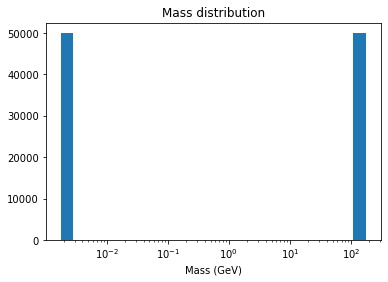

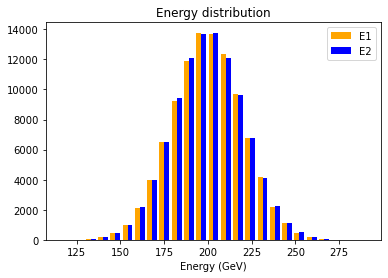

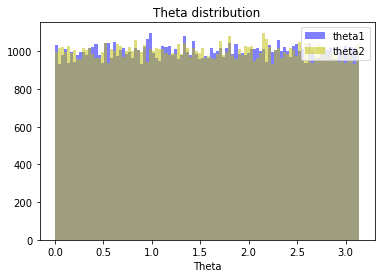

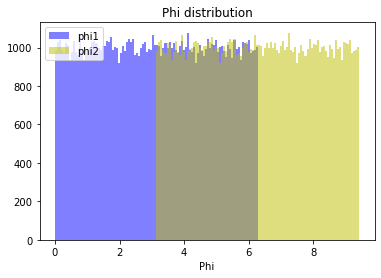

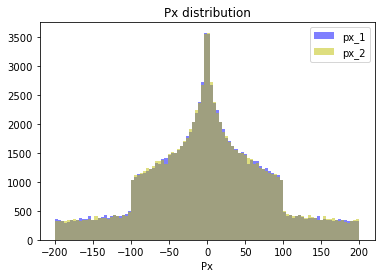

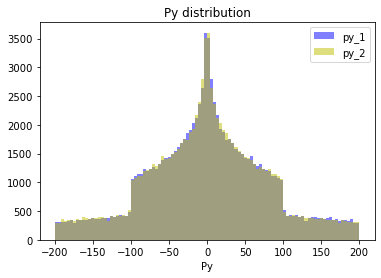

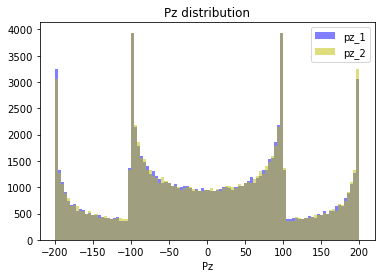

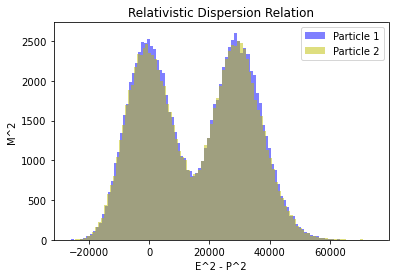

In [7]:
#Plotting histograms
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins)
    plt.xlabel("Mass (GeV)")
    plt.title("Mass distribution")
    plt.xscale('log')
    plt.show()

#Mass distribution
plot_loghist(M_list, 25)

#Energy distribution
plt.hist([E1_list, E2_list], label=['E1', 'E2'], bins=25, color=['orange','b'])
plt.title("Energy distribution")
plt.xlabel("Energy (GeV)")
plt.legend()
plt.show()

#Theta distribution
P1, theta1, phi1 = cart2sph(px1_list,py1_list,pz1_list)
P2, theta2, phi2 = cart2sph(px2_list,py2_list,pz2_list)

plt.hist(theta1_list, bins=100, label='theta1', alpha=0.5, color='b')
plt.hist(theta2_list, bins=100, label='theta2', alpha=0.5, color='y')
plt.title("Theta distribution")
plt.xlabel("Theta")
plt.legend()
plt.show()

#Phi distribution
plt.hist(phi1_list, bins=100, label='phi1', alpha=0.5, color='b')
plt.hist(phi2_list, bins=100, label='phi2', alpha=0.5, color='y')
plt.title("Phi distribution")
plt.xlabel("Phi")
plt.legend()
plt.show()

#Px distribution
plt.hist(px1_list, bins=100, label='px_1', alpha=0.5, color='b')
plt.hist(px2_list, bins=100, label='px_2', alpha=0.5, color='y')
plt.title("Px distribution")
plt.xlabel("Px")
plt.legend()
plt.show()

#Py distribution
plt.hist(py1_list, bins=100, label='py_1', alpha=0.5, color='b')
plt.hist(py2_list, bins=100, label='py_2', alpha=0.5, color='y')
plt.title("Py distribution")
plt.xlabel("Py")
plt.legend()
plt.show()

#Pz distribution
plt.hist(pz1_list, bins=100, label='pz_1', alpha=0.5, color='b')
plt.hist(pz2_list, bins=100, label='pz_2', alpha=0.5, color='y')
plt.title("Pz distribution")
plt.xlabel("Pz")
plt.legend()
plt.show()

#Relativistic dispersion relation
px1_list = np.array(px1_list)
py1_list = np.array(py1_list)
pz1_list = np.array(pz1_list)
px2_list = np.array(px2_list)
py2_list = np.array(py2_list)
pz2_list = np.array(pz2_list)
E1_list = np.array(E1_list)
E2_list = np.array(E2_list)

P1_list = np.sqrt(px1_list**2 + py1_list**2 + pz1_list**2)
P2_list = np.sqrt(px2_list**2 + py2_list**2 + pz2_list**2)

plt.hist(E1_list**2 - P1_list**2, bins=100, label='Particle 1', alpha=0.5, color='b')
plt.hist(E2_list**2 - P2_list**2, bins=100, label='Particle 2', alpha=0.5, color='y')
plt.title("Relativistic Dispersion Relation")
plt.ylabel("M^2")
plt.xlabel("E^2 - P^2")
plt.legend()
plt.show()

## Generative Model

In [5]:
#Extracting data from datafile
data = np.genfromtxt('MC_data.csv', delimiter=',') #Reading datafile
data = np.delete(data, 0, 0) #Removing header
data = np.delete(data, 0, 1) #Removing ID column
mass = data[:,-1] #Making mass a separate array
data = np.delete(data, -1, 1)


maxima = []
minima = []

#Normalizing
for i in range(8):
    imax = max(data[:,i])
    imin = min(data[:,i])
    data[:,i] = (data[:,i] - imin)/(imax - imin)
    maxima.append(imax)
    minima.append(imin)
    
X_train = data
y_train = mass

print(maxima)
print(minima)

[291.2167811518605, 283.89847772642014, 199.99496309740064, 199.9777312774691, 199.99369143654667, 199.99019853997123, 199.9999998802648, 199.9999998969173]
[112.60953952741993, 114.3396506683545, -199.97988556875922, -199.98280981341838, -199.98504924121696, -199.97611272386885, -199.99999996716505, -199.9999999656865]


In [6]:
#Sampling class
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
#VAE class
class VAE(keras.Model):
    #Initializing variables
    def __init__(self, encoder, decoder, input_shape, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        self.build((None,) + input_shape)
    
    #Custom call function
    def call(self, inputs):
        x = self.encoder(inputs)[2]
        return self.decoder(x)
    
    #Custom metrics
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    #Custom train step
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data) #Calculating z, mean and variance
            reconstruction = self.decoder(z) #Reconstructing data using decoder
            reconstruction_loss = tf.reduce_mean( #Calculating reconstruction loss
                tf.reduce_sum(
                    mse(data, reconstruction)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) #Calculating kl-loss
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + self.beta * kl_loss #Calculating total loss
            
        #Updating values
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    #Custom test step
    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data) #Calculating z, mean and variance
        reconstruction = self.decoder(z) #Reconstructing data using decoder
        reconstruction_loss = tf.reduce_mean( #Calculating reconstruction loss
            tf.reduce_sum(
                mse(data, reconstruction)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) #Calculating kl-loss
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + self.beta * kl_loss #Calculating total loss
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

## Optimisation

In [9]:
def objective(trial):
    latent_dim = 2
    input_shape = (8,)
    
    #Building encoder
    encoder_layers = trial.suggest_int("encoder_layers", 3, 8)
    encoder_inputs = keras.Input(shape=input_shape) 
    
    num_hidden = trial.suggest_int("encoder_units_l1", 16, 1024, log=True)
    x = layers.Dense(num_hidden, activation="relu")(encoder_inputs)
    for i in range(encoder_layers-1):
        num_hidden = trial.suggest_int("encoder_units_l{}".format(i+2), 16, 1024, log=True)
        x = layers.Dense(256, activation="relu")(x)
        
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    #Building decoder
    decoder_layers = trial.suggest_int("decoder_layers", 3, 8)
    latent_inputs = keras.Input(shape=(latent_dim,))   
    
    num_hidden = trial.suggest_int("decoder_units_l1", 16, 1024, log=True)
    x = layers.Dense(num_hidden, activation="relu")(latent_inputs)
                                       
    for i in range(decoder_layers-1):
        num_hidden = trial.suggest_int("decoder_units_l{}".format(i+2), 16, 1024, log=True)
        x = layers.Dense(256, activation="relu")(x)
                                       
    decoder_outputs = layers.Dense(input_shape[0], activation="sigmoid")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
                                
    #VAE                                   
    early_stop = EarlyStopping(monitor='loss',
                                    patience=10,
                                    mode='min',
                                    verbose=1)

    reduce_lr = ReduceLROnPlateau(monitor='loss', 
                                         factor=0.5, 
                                         patience=3, 
                                         verbose=1,
                                         mode='min',
                                         min_lr=1e-6)

    beta = trial.suggest_categorical("beta", [0.2, 1, 5])
    vae = VAE(encoder, decoder, input_shape, beta)
    vae.compile(optimizer=Adam(learning_rate = trial.suggest_categorical("lr", [1e-2, 1e-3, 1e-4])))
    vae.fit(X_train,
            epochs=300, 
            batch_size= trial.suggest_categorical("batch_size", [64, 128, 256, 512]),
            callbacks=[reduce_lr, early_stop]
           )

    z_mean, z_log_var, z = encoder(X_train) #Calculating z, mean and variance
    reconstruction = decoder(z) #Reconstructing data using decoder
    score = mean_squared_error(X_train, reconstruction) #Score is mean squared error of reconstruction vs original
    clear_session()
                                       
    return score

#Optimize
study = optuna.create_study(direction="minimize")
    
study.optimize(objective, n_trials=100)


#Print results and save to file
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
#Save results
with open('C:/Users/lucbu/Documents/ML Projects/MLforPandA/best_values.txt', "w") as hf:
     hf.write("Value: {} \n \n".format(trial.value))
     hf.write("Params: \n")
     for key, value in trial.params.items():
         hf.write("   {}: {} \n".format(key, value))

[I 2022-08-05 08:22:46,884] A new study created in memory with name: no-name-d2ee4e16-e042-44db-b763-618631618b64


Epoch 1/300
196/196 [==============================] - 2s 7ms/step - loss: 19.1318 - reconstruction_loss: 15.4030 - kl_loss: 0.9402 - lr: 1.0000e-04
Epoch 2/300
196/196 [==============================] - 1s 7ms/step - loss: 12.5385 - reconstruction_loss: 9.1931 - kl_loss: 2.2392 - lr: 1.0000e-04
Epoch 3/300
196/196 [==============================] - 2s 8ms/step - loss: 10.5010 - reconstruction_loss: 7.9537 - kl_loss: 2.5616 - lr: 1.0000e-04
Epoch 4/300
196/196 [==============================] - 1s 7ms/step - loss: 10.4364 - reconstruction_loss: 7.8605 - kl_loss: 2.5829 - lr: 1.0000e-04
Epoch 5/300
196/196 [==============================] - 1s 7ms/step - loss: 10.3754 - reconstruction_loss: 7.6374 - kl_loss: 2.6356 - lr: 1.0000e-04
Epoch 6/300
196/196 [==============================] - 1s 7ms/step - loss: 10.0968 - reconstruction_loss: 7.2001 - kl_loss: 2.7752 - lr: 1.0000e-04
Epoch 7/300
196/196 [==============================] - 1s 7ms/step - loss: 9.7641 - reconstruction_loss: 6.8124

196/196 [==============================] - 1s 7ms/step - loss: 7.1586 - reconstruction_loss: 3.3597 - kl_loss: 3.7924 - lr: 1.0000e-06
Epoch 103/300
196/196 [==============================] - 1s 7ms/step - loss: 7.1726 - reconstruction_loss: 3.3599 - kl_loss: 3.7953 - lr: 1.0000e-06
Epoch 104/300
196/196 [==============================] - 1s 7ms/step - loss: 7.1591 - reconstruction_loss: 3.3583 - kl_loss: 3.7950 - lr: 1.0000e-06
Epoch 104: early stopping


[I 2022-08-05 08:25:16,831] Trial 0 finished with value: 0.006579539926431266 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 60, 'encoder_units_l2': 54, 'encoder_units_l3': 513, 'encoder_units_l4': 492, 'decoder_layers': 7, 'decoder_units_l1': 42, 'decoder_units_l2': 41, 'decoder_units_l3': 85, 'decoder_units_l4': 96, 'decoder_units_l5': 1019, 'decoder_units_l6': 163, 'decoder_units_l7': 197, 'beta': 1, 'lr': 0.0001, 'batch_size': 512}. Best is trial 0 with value: 0.006579539926431266.


Epoch 1/300
391/391 [==============================] - 3s 7ms/step - loss: 7.1364 - reconstruction_loss: 5.8099 - kl_loss: 2.2001 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 3s 7ms/step - loss: 4.0659 - reconstruction_loss: 2.9888 - kl_loss: 3.9289 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 3s 7ms/step - loss: 3.1876 - reconstruction_loss: 2.1878 - kl_loss: 4.4930 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 3s 7ms/step - loss: 2.8563 - reconstruction_loss: 1.8939 - kl_loss: 4.7700 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 3s 7ms/step - loss: 2.8439 - reconstruction_loss: 1.8415 - kl_loss: 4.8320 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 3s 7ms/step - loss: 2.7411 - reconstruction_loss: 1.7967 - kl_loss: 4.9572 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 3s 7ms/step - loss: 2.7764 - reconstruction_loss: 1.7246 - kl_loss: 4.8695 - lr: 0.0010

[I 2022-08-05 08:28:05,084] Trial 1 finished with value: 0.004936496311177702 and parameters: {'encoder_layers': 5, 'encoder_units_l1': 278, 'encoder_units_l2': 68, 'encoder_units_l3': 27, 'encoder_units_l4': 644, 'encoder_units_l5': 123, 'decoder_layers': 8, 'decoder_units_l1': 141, 'decoder_units_l2': 524, 'decoder_units_l3': 62, 'decoder_units_l4': 373, 'decoder_units_l5': 44, 'decoder_units_l6': 187, 'decoder_units_l7': 70, 'decoder_units_l8': 45, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 1 with value: 0.004936496311177702.


Epoch 1/300
1563/1563 [==============================] - 6s 3ms/step - loss: 2.5290 - reconstruction_loss: 2.0496 - kl_loss: 0.4060 - lr: 1.0000e-04
Epoch 2/300
1563/1563 [==============================] - 5s 3ms/step - loss: 2.4129 - reconstruction_loss: 1.9614 - kl_loss: 0.4565 - lr: 1.0000e-04
Epoch 3/300
1563/1563 [==============================] - 5s 3ms/step - loss: 2.4180 - reconstruction_loss: 1.9578 - kl_loss: 0.4617 - lr: 1.0000e-04
Epoch 4/300
1563/1563 [==============================] - 5s 3ms/step - loss: 2.4108 - reconstruction_loss: 1.9539 - kl_loss: 0.4585 - lr: 1.0000e-04
Epoch 5/300
1563/1563 [==============================] - 5s 3ms/step - loss: 2.4204 - reconstruction_loss: 1.9571 - kl_loss: 0.4602 - lr: 1.0000e-04
Epoch 6/300
1563/1563 [==============================] - 5s 3ms/step - loss: 2.4128 - reconstruction_loss: 1.9558 - kl_loss: 0.4614 - lr: 1.0000e-04
Epoch 7/300
1561/1563 [============================>.] - ETA: 0s - loss: 2.4088 - reconstruction_loss: 1.9

[I 2022-08-05 08:31:18,054] Trial 2 finished with value: 0.030475393185873525 and parameters: {'encoder_layers': 6, 'encoder_units_l1': 68, 'encoder_units_l2': 17, 'encoder_units_l3': 55, 'encoder_units_l4': 172, 'encoder_units_l5': 105, 'encoder_units_l6': 17, 'decoder_layers': 8, 'decoder_units_l1': 65, 'decoder_units_l2': 555, 'decoder_units_l3': 514, 'decoder_units_l4': 22, 'decoder_units_l5': 382, 'decoder_units_l6': 704, 'decoder_units_l7': 937, 'decoder_units_l8': 209, 'beta': 1, 'lr': 0.0001, 'batch_size': 64}. Best is trial 1 with value: 0.004936496311177702.


Epoch 1/300
782/782 [==============================] - 3s 4ms/step - loss: 3.7034 - reconstruction_loss: 2.4653 - kl_loss: 2.3400 - lr: 1.0000e-04
Epoch 2/300
782/782 [==============================] - 3s 4ms/step - loss: 2.4754 - reconstruction_loss: 1.8847 - kl_loss: 2.8514 - lr: 1.0000e-04
Epoch 3/300
782/782 [==============================] - 3s 4ms/step - loss: 2.2481 - reconstruction_loss: 1.4937 - kl_loss: 3.2177 - lr: 1.0000e-04
Epoch 4/300
782/782 [==============================] - 3s 4ms/step - loss: 1.9608 - reconstruction_loss: 1.2605 - kl_loss: 3.3993 - lr: 1.0000e-04
Epoch 5/300
782/782 [==============================] - 3s 4ms/step - loss: 1.9042 - reconstruction_loss: 1.2024 - kl_loss: 3.4444 - lr: 1.0000e-04
Epoch 6/300
782/782 [==============================] - 3s 4ms/step - loss: 1.8828 - reconstruction_loss: 1.1732 - kl_loss: 3.4835 - lr: 1.0000e-04
Epoch 7/300
782/782 [==============================] - 3s 4ms/step - loss: 1.8547 - reconstruction_loss: 1.1436 - kl_l

782/782 [==============================] - 3s 4ms/step - loss: 1.5521 - reconstruction_loss: 0.7351 - kl_loss: 4.0910 - lr: 1.0000e-06
Epoch 103/300
782/782 [==============================] - 3s 4ms/step - loss: 1.5514 - reconstruction_loss: 0.7346 - kl_loss: 4.0874 - lr: 1.0000e-06
Epoch 104/300
782/782 [==============================] - 3s 4ms/step - loss: 1.5500 - reconstruction_loss: 0.7349 - kl_loss: 4.0832 - lr: 1.0000e-06
Epoch 105/300
782/782 [==============================] - 3s 4ms/step - loss: 1.5522 - reconstruction_loss: 0.7350 - kl_loss: 4.0832 - lr: 1.0000e-06
Epoch 106/300
782/782 [==============================] - 3s 4ms/step - loss: 1.5540 - reconstruction_loss: 0.7345 - kl_loss: 4.0854 - lr: 1.0000e-06
Epoch 107/300
782/782 [==============================] - 3s 4ms/step - loss: 1.5609 - reconstruction_loss: 0.7343 - kl_loss: 4.0963 - lr: 1.0000e-06
Epoch 108/300
782/782 [==============================] - 3s 4ms/step - loss: 1.5506 - reconstruction_loss: 0.7331 - kl_l

[I 2022-08-05 08:37:54,121] Trial 3 finished with value: 0.005736962354173272 and parameters: {'encoder_layers': 6, 'encoder_units_l1': 58, 'encoder_units_l2': 463, 'encoder_units_l3': 210, 'encoder_units_l4': 59, 'encoder_units_l5': 39, 'encoder_units_l6': 42, 'decoder_layers': 6, 'decoder_units_l1': 125, 'decoder_units_l2': 241, 'decoder_units_l3': 409, 'decoder_units_l4': 131, 'decoder_units_l5': 833, 'decoder_units_l6': 25, 'beta': 0.2, 'lr': 0.0001, 'batch_size': 128}. Best is trial 1 with value: 0.004936496311177702.


Epoch 1/300
196/196 [==============================] - 3s 12ms/step - loss: 19.0204 - reconstruction_loss: 15.0816 - kl_loss: 1.1577 - lr: 1.0000e-04
Epoch 2/300
196/196 [==============================] - 2s 12ms/step - loss: 13.8638 - reconstruction_loss: 12.2797 - kl_loss: 1.4535 - lr: 1.0000e-04
Epoch 3/300
196/196 [==============================] - 2s 12ms/step - loss: 13.4467 - reconstruction_loss: 10.6085 - kl_loss: 1.8815 - lr: 1.0000e-04
Epoch 4/300
196/196 [==============================] - 2s 12ms/step - loss: 10.5660 - reconstruction_loss: 7.9646 - kl_loss: 2.5632 - lr: 1.0000e-04
Epoch 5/300
196/196 [==============================] - 2s 13ms/step - loss: 10.4594 - reconstruction_loss: 7.6651 - kl_loss: 2.6203 - lr: 1.0000e-04
Epoch 6/300
196/196 [==============================] - 2s 12ms/step - loss: 9.7130 - reconstruction_loss: 6.5044 - kl_loss: 2.9002 - lr: 1.0000e-04
Epoch 7/300
196/196 [==============================] - 2s 12ms/step - loss: 8.7350 - reconstruction_loss

196/196 [==============================] - 2s 13ms/step - loss: 7.1798 - reconstruction_loss: 3.3775 - kl_loss: 3.7857 - lr: 6.2500e-06
Epoch 105/300
196/196 [==============================] - 2s 13ms/step - loss: 7.1519 - reconstruction_loss: 3.3670 - kl_loss: 3.7814 - lr: 3.1250e-06
Epoch 106/300
196/196 [==============================] - 2s 13ms/step - loss: 7.1726 - reconstruction_loss: 3.3647 - kl_loss: 3.7848 - lr: 3.1250e-06
Epoch 107/300
196/196 [==============================] - 2s 13ms/step - loss: 7.1760 - reconstruction_loss: 3.3647 - kl_loss: 3.7828 - lr: 3.1250e-06
Epoch 108/300
196/196 [==============================] - 2s 13ms/step - loss: 7.1576 - reconstruction_loss: 3.3684 - kl_loss: 3.7885 - lr: 3.1250e-06
Epoch 109/300
196/196 [==============================] - 2s 13ms/step - loss: 7.1592 - reconstruction_loss: 3.3561 - kl_loss: 3.7931 - lr: 3.1250e-06
Epoch 110/300
194/196 [============================>.] - ETA: 0s - loss: 7.1598 - reconstruction_loss: 3.3694 - kl

[I 2022-08-05 08:44:11,590] Trial 4 finished with value: 0.006558732777398353 and parameters: {'encoder_layers': 7, 'encoder_units_l1': 211, 'encoder_units_l2': 400, 'encoder_units_l3': 603, 'encoder_units_l4': 22, 'encoder_units_l5': 200, 'encoder_units_l6': 35, 'encoder_units_l7': 462, 'decoder_layers': 6, 'decoder_units_l1': 837, 'decoder_units_l2': 66, 'decoder_units_l3': 16, 'decoder_units_l4': 734, 'decoder_units_l5': 194, 'decoder_units_l6': 59, 'beta': 1, 'lr': 0.0001, 'batch_size': 512}. Best is trial 1 with value: 0.004936496311177702.


Epoch 1/300
782/782 [==============================] - 3s 3ms/step - loss: 3.4928 - reconstruction_loss: 2.8601 - kl_loss: 1.9434 - lr: 0.0100
Epoch 2/300
782/782 [==============================] - 2s 3ms/step - loss: 2.9999 - reconstruction_loss: 2.5339 - kl_loss: 2.1195 - lr: 0.0100
Epoch 3/300
782/782 [==============================] - 2s 3ms/step - loss: 2.9045 - reconstruction_loss: 2.4494 - kl_loss: 2.2194 - lr: 0.0100
Epoch 4/300
782/782 [==============================] - 2s 3ms/step - loss: 2.9575 - reconstruction_loss: 2.4943 - kl_loss: 2.3618 - lr: 0.0100
Epoch 5/300
782/782 [==============================] - 2s 3ms/step - loss: 3.1747 - reconstruction_loss: 2.7438 - kl_loss: 2.1695 - lr: 0.0100
Epoch 6/300
779/782 [============================>.] - ETA: 0s - loss: 3.0497 - reconstruction_loss: 2.5861 - kl_loss: 2.1530
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
782/782 [==============================] - 2s 3ms/step - loss: 3.0495 - reconstructi

Epoch 54/300
782/782 [==============================] - 2s 3ms/step - loss: 2.4266 - reconstruction_loss: 1.8207 - kl_loss: 3.0216 - lr: 0.0012
Epoch 55/300
782/782 [==============================] - 2s 3ms/step - loss: 2.4308 - reconstruction_loss: 1.8118 - kl_loss: 3.0298 - lr: 0.0012
Epoch 56/300
782/782 [==============================] - 2s 3ms/step - loss: 2.4238 - reconstruction_loss: 1.8097 - kl_loss: 3.0645 - lr: 0.0012
Epoch 57/300
782/782 [==============================] - 2s 3ms/step - loss: 2.4028 - reconstruction_loss: 1.7789 - kl_loss: 3.0781 - lr: 0.0012
Epoch 58/300
782/782 [==============================] - 2s 3ms/step - loss: 2.3481 - reconstruction_loss: 1.7420 - kl_loss: 3.1059 - lr: 0.0012
Epoch 59/300
782/782 [==============================] - 2s 3ms/step - loss: 2.3461 - reconstruction_loss: 1.7278 - kl_loss: 3.1248 - lr: 0.0012
Epoch 60/300
782/782 [==============================] - 2s 3ms/step - loss: 2.3768 - reconstruction_loss: 1.7717 - kl_loss: 3.1617 - lr:

[I 2022-08-05 08:47:36,920] Trial 5 finished with value: 0.0123174558060212 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 31, 'encoder_units_l2': 62, 'encoder_units_l3': 34, 'encoder_units_l4': 38, 'decoder_layers': 5, 'decoder_units_l1': 23, 'decoder_units_l2': 115, 'decoder_units_l3': 174, 'decoder_units_l4': 46, 'decoder_units_l5': 19, 'beta': 0.2, 'lr': 0.01, 'batch_size': 128}. Best is trial 1 with value: 0.004936496311177702.


Epoch 1/300
391/391 [==============================] - 3s 6ms/step - loss: 7.6281 - reconstruction_loss: 5.0677 - kl_loss: 1.7327 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 3s 7ms/step - loss: 6.2637 - reconstruction_loss: 4.0632 - kl_loss: 2.0964 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 3s 7ms/step - loss: 5.8373 - reconstruction_loss: 3.3750 - kl_loss: 2.3730 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 3s 7ms/step - loss: 5.5985 - reconstruction_loss: 3.1225 - kl_loss: 2.4435 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 3s 6ms/step - loss: 5.5365 - reconstruction_loss: 3.0576 - kl_loss: 2.4629 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 3s 6ms/step - loss: 5.4968 - reconstruction_loss: 3.0091 - kl_loss: 2.4791 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 3s 7ms/step - loss: 5.4975 - reconstruction_loss: 2.9868 - kl_loss: 2.4881 - lr: 0.0010

[I 2022-08-05 08:51:34,631] Trial 6 finished with value: 0.009531441478586561 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 134, 'encoder_units_l2': 44, 'encoder_units_l3': 17, 'decoder_layers': 6, 'decoder_units_l1': 330, 'decoder_units_l2': 25, 'decoder_units_l3': 287, 'decoder_units_l4': 901, 'decoder_units_l5': 27, 'decoder_units_l6': 119, 'beta': 1, 'lr': 0.001, 'batch_size': 256}. Best is trial 1 with value: 0.004936496311177702.


Epoch 1/300
391/391 [==============================] - 4s 9ms/step - loss: 10.9984 - reconstruction_loss: 10.8762 - kl_loss: 0.0026 - lr: 0.0100
Epoch 2/300
391/391 [==============================] - 4s 9ms/step - loss: 10.8671 - reconstruction_loss: 10.8466 - kl_loss: 8.4906e-09 - lr: 0.0100
Epoch 3/300
391/391 [==============================] - 4s 10ms/step - loss: 10.8646 - reconstruction_loss: 10.8475 - kl_loss: 2.0230e-08 - lr: 0.0100
Epoch 4/300
391/391 [==============================] - 4s 10ms/step - loss: 10.8889 - reconstruction_loss: 10.8476 - kl_loss: 2.0466e-07 - lr: 0.0100
Epoch 5/300
389/391 [============================>.] - ETA: 0s - loss: 10.8883 - reconstruction_loss: 10.8578 - kl_loss: 1.7406e-07
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
391/391 [==============================] - 4s 10ms/step - loss: 10.8880 - reconstruction_loss: 10.8467 - kl_loss: 1.7317e-07 - lr: 0.0100
Epoch 6/300
391/391 [==============================] - 4s 10m

[I 2022-08-05 08:55:57,371] Trial 7 finished with value: 0.04239506880183041 and parameters: {'encoder_layers': 7, 'encoder_units_l1': 205, 'encoder_units_l2': 163, 'encoder_units_l3': 375, 'encoder_units_l4': 61, 'encoder_units_l5': 416, 'encoder_units_l6': 668, 'encoder_units_l7': 38, 'decoder_layers': 6, 'decoder_units_l1': 65, 'decoder_units_l2': 32, 'decoder_units_l3': 19, 'decoder_units_l4': 100, 'decoder_units_l5': 17, 'decoder_units_l6': 65, 'beta': 1, 'lr': 0.01, 'batch_size': 256}. Best is trial 1 with value: 0.004936496311177702.


Epoch 1/300
1563/1563 [==============================] - 5s 3ms/step - loss: 2.8194 - reconstruction_loss: 2.7160 - kl_loss: 0.0027 - lr: 0.0100
Epoch 2/300
1563/1563 [==============================] - 5s 3ms/step - loss: 2.7112 - reconstruction_loss: 2.7144 - kl_loss: 4.5203e-08 - lr: 0.0100
Epoch 3/300
1563/1563 [==============================] - 5s 3ms/step - loss: 2.7137 - reconstruction_loss: 2.7145 - kl_loss: 9.1032e-08 - lr: 0.0100
Epoch 4/300
1563/1563 [==============================] - 5s 3ms/step - loss: 2.7187 - reconstruction_loss: 2.7143 - kl_loss: 2.0758e-06 - lr: 0.0100
Epoch 5/300
1563/1563 [==============================] - 5s 3ms/step - loss: 2.7183 - reconstruction_loss: 2.7143 - kl_loss: 0.0000e+00 - lr: 0.0100
Epoch 6/300
1563/1563 [==============================] - 5s 3ms/step - loss: 2.7207 - reconstruction_loss: 2.7145 - kl_loss: 5.7455e-08 - lr: 0.0100
Epoch 7/300
1563/1563 [==============================] - 5s 3ms/step - loss: 2.7114 - reconstruction_loss: 2.7

[I 2022-08-05 09:00:56,525] Trial 8 finished with value: 0.04239506866149612 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 564, 'encoder_units_l2': 110, 'encoder_units_l3': 23, 'encoder_units_l4': 973, 'decoder_layers': 5, 'decoder_units_l1': 256, 'decoder_units_l2': 44, 'decoder_units_l3': 134, 'decoder_units_l4': 75, 'decoder_units_l5': 33, 'beta': 5, 'lr': 0.01, 'batch_size': 64}. Best is trial 1 with value: 0.004936496311177702.


Epoch 1/300
782/782 [==============================] - 4s 5ms/step - loss: 4.1047 - reconstruction_loss: 3.2818 - kl_loss: 1.5006 - lr: 0.0100
Epoch 2/300
782/782 [==============================] - 4s 5ms/step - loss: 3.2857 - reconstruction_loss: 2.8323 - kl_loss: 2.0770 - lr: 0.0100
Epoch 3/300
782/782 [==============================] - 4s 5ms/step - loss: 3.1322 - reconstruction_loss: 2.8272 - kl_loss: 2.1166 - lr: 0.0100
Epoch 4/300
782/782 [==============================] - 4s 5ms/step - loss: 3.2135 - reconstruction_loss: 2.6946 - kl_loss: 2.1619 - lr: 0.0100
Epoch 5/300
782/782 [==============================] - 4s 5ms/step - loss: 3.3454 - reconstruction_loss: 2.8698 - kl_loss: 2.0260 - lr: 0.0100
Epoch 6/300
782/782 [==============================] - 4s 5ms/step - loss: 3.2522 - reconstruction_loss: 2.8814 - kl_loss: 1.8760 - lr: 0.0100
Epoch 7/300
774/782 [============================>.] - ETA: 0s - loss: 3.2700 - reconstruction_loss: 2.8494 - kl_loss: 2.0292
Epoch 7: ReduceL

[I 2022-08-05 09:04:43,214] Trial 9 finished with value: 0.01588048918119539 and parameters: {'encoder_layers': 7, 'encoder_units_l1': 55, 'encoder_units_l2': 34, 'encoder_units_l3': 260, 'encoder_units_l4': 41, 'encoder_units_l5': 187, 'encoder_units_l6': 983, 'encoder_units_l7': 147, 'decoder_layers': 6, 'decoder_units_l1': 89, 'decoder_units_l2': 31, 'decoder_units_l3': 112, 'decoder_units_l4': 227, 'decoder_units_l5': 20, 'decoder_units_l6': 878, 'beta': 0.2, 'lr': 0.01, 'batch_size': 128}. Best is trial 1 with value: 0.004936496311177702.


Epoch 1/300
391/391 [==============================] - 3s 7ms/step - loss: 10.3886 - reconstruction_loss: 8.5671 - kl_loss: 0.3201 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 3s 7ms/step - loss: 10.0969 - reconstruction_loss: 8.3296 - kl_loss: 0.3518 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 3s 7ms/step - loss: 10.1020 - reconstruction_loss: 8.3182 - kl_loss: 0.3536 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 3s 7ms/step - loss: 10.0826 - reconstruction_loss: 8.3111 - kl_loss: 0.3525 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 3s 7ms/step - loss: 10.0716 - reconstruction_loss: 8.2955 - kl_loss: 0.3533 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 3s 7ms/step - loss: 10.0360 - reconstruction_loss: 8.2860 - kl_loss: 0.3526 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 3s 7ms/step - loss: 10.0723 - reconstruction_loss: 8.2917 - kl_loss: 0.3517 - lr:

[I 2022-08-05 09:05:37,332] Trial 10 finished with value: 0.03240195078461887 and parameters: {'encoder_layers': 5, 'encoder_units_l1': 962, 'encoder_units_l2': 171, 'encoder_units_l3': 74, 'encoder_units_l4': 223, 'encoder_units_l5': 19, 'decoder_layers': 3, 'decoder_units_l1': 277, 'decoder_units_l2': 984, 'decoder_units_l3': 46, 'beta': 5, 'lr': 0.001, 'batch_size': 256}. Best is trial 1 with value: 0.004936496311177702.


Epoch 1/300
782/782 [==============================] - 4s 5ms/step - loss: 3.1679 - reconstruction_loss: 2.0245 - kl_loss: 2.7857 - lr: 0.0010
Epoch 2/300
782/782 [==============================] - 4s 5ms/step - loss: 1.9773 - reconstruction_loss: 1.2594 - kl_loss: 3.4747 - lr: 0.0010
Epoch 3/300
782/782 [==============================] - 4s 5ms/step - loss: 1.9056 - reconstruction_loss: 1.2149 - kl_loss: 3.5525 - lr: 0.0010
Epoch 4/300
782/782 [==============================] - 4s 5ms/step - loss: 1.9041 - reconstruction_loss: 1.1798 - kl_loss: 3.6165 - lr: 0.0010
Epoch 5/300
782/782 [==============================] - 4s 5ms/step - loss: 1.8922 - reconstruction_loss: 1.1449 - kl_loss: 3.6640 - lr: 0.0010
Epoch 6/300
782/782 [==============================] - 4s 5ms/step - loss: 1.8498 - reconstruction_loss: 1.0869 - kl_loss: 3.7810 - lr: 0.0010
Epoch 7/300
782/782 [==============================] - 4s 5ms/step - loss: 1.7850 - reconstruction_loss: 0.9903 - kl_loss: 3.9423 - lr: 0.0010

[I 2022-08-05 09:07:27,753] Trial 11 finished with value: 0.006396309793350976 and parameters: {'encoder_layers': 6, 'encoder_units_l1': 16, 'encoder_units_l2': 967, 'encoder_units_l3': 155, 'encoder_units_l4': 86, 'encoder_units_l5': 36, 'encoder_units_l6': 94, 'decoder_layers': 8, 'decoder_units_l1': 167, 'decoder_units_l2': 308, 'decoder_units_l3': 898, 'decoder_units_l4': 293, 'decoder_units_l5': 72, 'decoder_units_l6': 20, 'decoder_units_l7': 18, 'decoder_units_l8': 18, 'beta': 0.2, 'lr': 0.001, 'batch_size': 128}. Best is trial 1 with value: 0.004936496311177702.


Epoch 1/300
782/782 [==============================] - 4s 5ms/step - loss: 3.9105 - reconstruction_loss: 3.2273 - kl_loss: 1.5001 - lr: 1.0000e-04
Epoch 2/300
782/782 [==============================] - 4s 5ms/step - loss: 2.8947 - reconstruction_loss: 2.0926 - kl_loss: 2.6083 - lr: 1.0000e-04
Epoch 3/300
782/782 [==============================] - 4s 5ms/step - loss: 2.2369 - reconstruction_loss: 1.4761 - kl_loss: 3.2017 - lr: 1.0000e-04
Epoch 4/300
782/782 [==============================] - 4s 5ms/step - loss: 1.9329 - reconstruction_loss: 1.2341 - kl_loss: 3.3898 - lr: 1.0000e-04
Epoch 5/300
782/782 [==============================] - 4s 5ms/step - loss: 1.8662 - reconstruction_loss: 1.1688 - kl_loss: 3.4603 - lr: 1.0000e-04
Epoch 6/300
782/782 [==============================] - 4s 5ms/step - loss: 1.8464 - reconstruction_loss: 1.1359 - kl_loss: 3.5137 - lr: 1.0000e-04
Epoch 7/300
782/782 [==============================] - 4s 5ms/step - loss: 1.8200 - reconstruction_loss: 1.1123 - kl_l

782/782 [==============================] - 4s 5ms/step - loss: 1.5605 - reconstruction_loss: 0.7459 - kl_loss: 4.0620 - lr: 1.0000e-06
Epoch 103/300
782/782 [==============================] - 4s 5ms/step - loss: 1.5602 - reconstruction_loss: 0.7445 - kl_loss: 4.0647 - lr: 1.0000e-06
Epoch 104/300
782/782 [==============================] - 4s 5ms/step - loss: 1.5597 - reconstruction_loss: 0.7453 - kl_loss: 4.0606 - lr: 1.0000e-06
Epoch 105/300
782/782 [==============================] - 4s 5ms/step - loss: 1.5580 - reconstruction_loss: 0.7441 - kl_loss: 4.0677 - lr: 1.0000e-06
Epoch 106/300
782/782 [==============================] - 4s 5ms/step - loss: 1.5555 - reconstruction_loss: 0.7437 - kl_loss: 4.0609 - lr: 1.0000e-06
Epoch 107/300
782/782 [==============================] - 4s 5ms/step - loss: 1.5568 - reconstruction_loss: 0.7427 - kl_loss: 4.0676 - lr: 1.0000e-06
Epoch 108/300
782/782 [==============================] - 4s 5ms/step - loss: 1.5585 - reconstruction_loss: 0.7430 - kl_l

[I 2022-08-05 09:16:28,352] Trial 12 finished with value: 0.005835532853478607 and parameters: {'encoder_layers': 8, 'encoder_units_l1': 305, 'encoder_units_l2': 402, 'encoder_units_l3': 126, 'encoder_units_l4': 362, 'encoder_units_l5': 59, 'encoder_units_l6': 117, 'encoder_units_l7': 18, 'encoder_units_l8': 282, 'decoder_layers': 4, 'decoder_units_l1': 656, 'decoder_units_l2': 228, 'decoder_units_l3': 38, 'decoder_units_l4': 301, 'beta': 0.2, 'lr': 0.0001, 'batch_size': 128}. Best is trial 1 with value: 0.004936496311177702.


Epoch 1/300
391/391 [==============================] - 5s 12ms/step - loss: 6.9995 - reconstruction_loss: 5.5427 - kl_loss: 2.3560 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 5s 12ms/step - loss: 4.2819 - reconstruction_loss: 3.2645 - kl_loss: 3.7152 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 5s 12ms/step - loss: 3.1064 - reconstruction_loss: 2.1819 - kl_loss: 4.3022 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 5s 12ms/step - loss: 2.9541 - reconstruction_loss: 2.0623 - kl_loss: 4.3920 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 5s 12ms/step - loss: 2.8126 - reconstruction_loss: 1.8876 - kl_loss: 4.5198 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 5s 12ms/step - loss: 2.7352 - reconstruction_loss: 1.7550 - kl_loss: 4.6877 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 5s 12ms/step - loss: 2.6733 - reconstruction_loss: 1.6929 - kl_loss: 4.7267 - lr:

[I 2022-08-05 09:23:09,331] Trial 13 finished with value: 0.004823270072671707 and parameters: {'encoder_layers': 5, 'encoder_units_l1': 105, 'encoder_units_l2': 393, 'encoder_units_l3': 911, 'encoder_units_l4': 966, 'encoder_units_l5': 54, 'decoder_layers': 7, 'decoder_units_l1': 142, 'decoder_units_l2': 252, 'decoder_units_l3': 297, 'decoder_units_l4': 205, 'decoder_units_l5': 75, 'decoder_units_l6': 283, 'decoder_units_l7': 42, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 13 with value: 0.004823270072671707.


Epoch 1/300
391/391 [==============================] - 4s 10ms/step - loss: 7.2818 - reconstruction_loss: 5.9784 - kl_loss: 2.0922 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 4s 10ms/step - loss: 4.2306 - reconstruction_loss: 3.1409 - kl_loss: 3.7974 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 4s 10ms/step - loss: 3.1828 - reconstruction_loss: 2.2673 - kl_loss: 4.2746 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 4s 10ms/step - loss: 2.9191 - reconstruction_loss: 1.9811 - kl_loss: 4.4222 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 4s 10ms/step - loss: 2.8889 - reconstruction_loss: 1.8933 - kl_loss: 4.6228 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 4s 10ms/step - loss: 2.6674 - reconstruction_loss: 1.6945 - kl_loss: 4.8196 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 4s 10ms/step - loss: 2.6819 - reconstruction_loss: 1.6958 - kl_loss: 4.9308 - lr:

391/391 [==============================] - 4s 10ms/step - loss: 2.2032 - reconstruction_loss: 1.2426 - kl_loss: 4.7780 - lr: 1.0000e-06
Epoch 98: early stopping


[I 2022-08-05 09:29:35,455] Trial 14 finished with value: 0.004862001863070236 and parameters: {'encoder_layers': 5, 'encoder_units_l1': 367, 'encoder_units_l2': 102, 'encoder_units_l3': 1001, 'encoder_units_l4': 958, 'encoder_units_l5': 93, 'decoder_layers': 8, 'decoder_units_l1': 156, 'decoder_units_l2': 497, 'decoder_units_l3': 69, 'decoder_units_l4': 456, 'decoder_units_l5': 70, 'decoder_units_l6': 287, 'decoder_units_l7': 45, 'decoder_units_l8': 32, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 13 with value: 0.004823270072671707.


Epoch 1/300
391/391 [==============================] - 4s 9ms/step - loss: 5.9080 - reconstruction_loss: 4.1547 - kl_loss: 3.3015 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 4s 9ms/step - loss: 3.9448 - reconstruction_loss: 2.9647 - kl_loss: 4.0021 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 4s 10ms/step - loss: 3.4125 - reconstruction_loss: 2.4532 - kl_loss: 4.2887 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 4s 10ms/step - loss: 3.0765 - reconstruction_loss: 2.1574 - kl_loss: 4.5180 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 4s 10ms/step - loss: 2.9158 - reconstruction_loss: 1.9400 - kl_loss: 4.6072 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 4s 10ms/step - loss: 2.8177 - reconstruction_loss: 1.8132 - kl_loss: 4.7796 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 4s 10ms/step - loss: 2.6760 - reconstruction_loss: 1.7016 - kl_loss: 4.8259 - lr: 0

391/391 [==============================] - 4s 10ms/step - loss: 2.1793 - reconstruction_loss: 1.2277 - kl_loss: 4.7072 - lr: 1.0000e-06
Epoch 99/300
391/391 [==============================] - 4s 10ms/step - loss: 2.1743 - reconstruction_loss: 1.2288 - kl_loss: 4.7070 - lr: 1.0000e-06
Epoch 100/300
391/391 [==============================] - 4s 10ms/step - loss: 2.1742 - reconstruction_loss: 1.2297 - kl_loss: 4.7058 - lr: 1.0000e-06
Epoch 101/300
391/391 [==============================] - 4s 10ms/step - loss: 2.1723 - reconstruction_loss: 1.2285 - kl_loss: 4.7049 - lr: 1.0000e-06
Epoch 102/300
391/391 [==============================] - 4s 10ms/step - loss: 2.1702 - reconstruction_loss: 1.2293 - kl_loss: 4.7005 - lr: 1.0000e-06
Epoch 103/300
391/391 [==============================] - 4s 10ms/step - loss: 2.1685 - reconstruction_loss: 1.2289 - kl_loss: 4.6997 - lr: 1.0000e-06
Epoch 104/300
391/391 [==============================] - 4s 10ms/step - loss: 2.1760 - reconstruction_loss: 1.2308 

[I 2022-08-05 09:36:12,181] Trial 15 finished with value: 0.004807672164569487 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 511, 'encoder_units_l2': 245, 'encoder_units_l3': 918, 'decoder_layers': 7, 'decoder_units_l1': 460, 'decoder_units_l2': 118, 'decoder_units_l3': 221, 'decoder_units_l4': 520, 'decoder_units_l5': 102, 'decoder_units_l6': 371, 'decoder_units_l7': 34, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 4s 8ms/step - loss: 5.8694 - reconstruction_loss: 4.1198 - kl_loss: 3.3596 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 3s 8ms/step - loss: 4.1818 - reconstruction_loss: 3.2069 - kl_loss: 3.8278 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 3s 8ms/step - loss: 3.3838 - reconstruction_loss: 2.3901 - kl_loss: 4.3649 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 3s 8ms/step - loss: 3.0478 - reconstruction_loss: 2.0747 - kl_loss: 4.5859 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 3s 8ms/step - loss: 2.9110 - reconstruction_loss: 1.9567 - kl_loss: 4.7012 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 3s 8ms/step - loss: 2.8650 - reconstruction_loss: 1.8754 - kl_loss: 4.7238 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 3s 8ms/step - loss: 2.7608 - reconstruction_loss: 1.7912 - kl_loss: 4.7448 - lr: 0.0010

Epoch 55/300
391/391 [==============================] - 3s 8ms/step - loss: 2.1918 - reconstruction_loss: 1.2483 - kl_loss: 4.7023 - lr: 2.5000e-04
Epoch 56/300
391/391 [==============================] - 3s 8ms/step - loss: 2.1812 - reconstruction_loss: 1.2490 - kl_loss: 4.6854 - lr: 2.5000e-04
Epoch 57/300
391/391 [==============================] - 3s 9ms/step - loss: 2.1891 - reconstruction_loss: 1.2476 - kl_loss: 4.6967 - lr: 2.5000e-04
Epoch 58/300
391/391 [==============================] - 3s 8ms/step - loss: 2.1891 - reconstruction_loss: 1.2464 - kl_loss: 4.6911 - lr: 2.5000e-04
Epoch 59/300
391/391 [==============================] - 3s 8ms/step - loss: 2.1857 - reconstruction_loss: 1.2474 - kl_loss: 4.6761 - lr: 2.5000e-04
Epoch 60/300
391/391 [==============================] - 3s 8ms/step - loss: 2.1842 - reconstruction_loss: 1.2461 - kl_loss: 4.6911 - lr: 2.5000e-04
Epoch 61/300
391/391 [==============================] - 3s 8ms/step - loss: 2.1861 - reconstruction_loss: 1.2490

[I 2022-08-05 09:40:45,885] Trial 16 finished with value: 0.0048385550624663355 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 114, 'encoder_units_l2': 252, 'encoder_units_l3': 837, 'decoder_layers': 7, 'decoder_units_l1': 478, 'decoder_units_l2': 94, 'decoder_units_l3': 196, 'decoder_units_l4': 173, 'decoder_units_l5': 144, 'decoder_units_l6': 475, 'decoder_units_l7': 21, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 4s 8ms/step - loss: 10.7349 - reconstruction_loss: 9.6682 - kl_loss: 0.1692 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 3s 8ms/step - loss: 10.0924 - reconstruction_loss: 8.3325 - kl_loss: 0.3488 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 3s 8ms/step - loss: 10.1024 - reconstruction_loss: 8.3188 - kl_loss: 0.3533 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 3s 8ms/step - loss: 10.0758 - reconstruction_loss: 8.3207 - kl_loss: 0.3533 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 3s 8ms/step - loss: 10.0741 - reconstruction_loss: 8.3260 - kl_loss: 0.3495 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 3s 8ms/step - loss: 10.1018 - reconstruction_loss: 8.2945 - kl_loss: 0.3572 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 3s 8ms/step - loss: 10.0472 - reconstruction_loss: 8.2880 - kl_loss: 0.3522 - lr:

[I 2022-08-05 09:42:31,802] Trial 17 finished with value: 0.03230399406762828 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 771, 'encoder_units_l2': 805, 'encoder_units_l3': 395, 'decoder_layers': 7, 'decoder_units_l1': 548, 'decoder_units_l2': 16, 'decoder_units_l3': 688, 'decoder_units_l4': 565, 'decoder_units_l5': 77, 'decoder_units_l6': 355, 'decoder_units_l7': 138, 'beta': 5, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 3s 7ms/step - loss: 6.5258 - reconstruction_loss: 4.3881 - kl_loss: 3.1652 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 3s 7ms/step - loss: 3.4262 - reconstruction_loss: 2.4065 - kl_loss: 4.1871 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 3s 7ms/step - loss: 2.9987 - reconstruction_loss: 2.0835 - kl_loss: 4.4117 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 3s 7ms/step - loss: 2.8180 - reconstruction_loss: 1.8780 - kl_loss: 4.5759 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 3s 7ms/step - loss: 2.7139 - reconstruction_loss: 1.7831 - kl_loss: 4.7177 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 3s 7ms/step - loss: 2.6454 - reconstruction_loss: 1.6427 - kl_loss: 4.8104 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 3s 7ms/step - loss: 2.5585 - reconstruction_loss: 1.5931 - kl_loss: 4.8637 - lr: 0.0010

Epoch 51/300
391/391 [==============================] - 3s 7ms/step - loss: 2.1851 - reconstruction_loss: 1.2553 - kl_loss: 4.6823 - lr: 3.1250e-05
Epoch 51: early stopping


[I 2022-08-05 09:44:51,892] Trial 18 finished with value: 0.004908493321815964 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 115, 'encoder_units_l2': 264, 'encoder_units_l3': 665, 'encoder_units_l4': 309, 'decoder_layers': 7, 'decoder_units_l1': 19, 'decoder_units_l2': 168, 'decoder_units_l3': 280, 'decoder_units_l4': 47, 'decoder_units_l5': 245, 'decoder_units_l6': 278, 'decoder_units_l7': 48, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6723 - reconstruction_loss: 1.1079 - kl_loss: 2.0950 - lr: 0.0010
Epoch 2/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3304 - reconstruction_loss: 0.7879 - kl_loss: 2.5693 - lr: 0.0010
Epoch 3/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2682 - reconstruction_loss: 0.7343 - kl_loss: 2.6548 - lr: 0.0010
Epoch 4/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2459 - reconstruction_loss: 0.7037 - kl_loss: 2.7032 - lr: 0.0010
Epoch 5/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2342 - reconstruction_loss: 0.6827 - kl_loss: 2.7556 - lr: 0.0010
Epoch 6/300
1563/1563 [==============================] - 5s 4ms/step - loss: 1.2391 - reconstruction_loss: 0.6747 - kl_loss: 2.7932 - lr: 0.0010
Epoch 7/300
1563/1563 [==============================] - 5s 4ms/step - loss: 1.2238 - reconstruction_loss: 0.6555 - kl_loss: 2.822

[I 2022-08-05 09:52:59,779] Trial 19 finished with value: 0.007558081976507837 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 462, 'encoder_units_l2': 649, 'encoder_units_l3': 1020, 'decoder_layers': 7, 'decoder_units_l1': 436, 'decoder_units_l2': 78, 'decoder_units_l3': 303, 'decoder_units_l4': 166, 'decoder_units_l5': 101, 'decoder_units_l6': 107, 'decoder_units_l7': 31, 'beta': 0.2, 'lr': 0.001, 'batch_size': 64}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
196/196 [==============================] - 5s 23ms/step - loss: 19.0151 - reconstruction_loss: 15.0266 - kl_loss: 0.6139 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 5s 23ms/step - loss: 17.7318 - reconstruction_loss: 14.2271 - kl_loss: 0.6797 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 5s 23ms/step - loss: 17.6281 - reconstruction_loss: 14.2267 - kl_loss: 0.6777 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 5s 23ms/step - loss: 17.6897 - reconstruction_loss: 14.2104 - kl_loss: 0.6789 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 5s 23ms/step - loss: 17.7111 - reconstruction_loss: 14.1890 - kl_loss: 0.6847 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 5s 23ms/step - loss: 17.6171 - reconstruction_loss: 14.1511 - kl_loss: 0.6839 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 5s 23ms/step - loss: 17.6696 - reconstruction_loss: 14.1672 - kl_loss

[I 2022-08-05 09:59:26,637] Trial 20 finished with value: 0.020474406557536996 and parameters: {'encoder_layers': 8, 'encoder_units_l1': 36, 'encoder_units_l2': 277, 'encoder_units_l3': 319, 'encoder_units_l4': 135, 'encoder_units_l5': 737, 'encoder_units_l6': 329, 'encoder_units_l7': 976, 'encoder_units_l8': 22, 'decoder_layers': 5, 'decoder_units_l1': 1011, 'decoder_units_l2': 144, 'decoder_units_l3': 484, 'decoder_units_l4': 563, 'decoder_units_l5': 51, 'beta': 5, 'lr': 0.001, 'batch_size': 512}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 4s 10ms/step - loss: 5.9581 - reconstruction_loss: 4.0454 - kl_loss: 3.4722 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 4s 10ms/step - loss: 3.4868 - reconstruction_loss: 2.4896 - kl_loss: 4.2825 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 4s 10ms/step - loss: 3.0936 - reconstruction_loss: 2.1662 - kl_loss: 4.4089 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 4s 10ms/step - loss: 2.9489 - reconstruction_loss: 2.0293 - kl_loss: 4.4862 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 4s 10ms/step - loss: 2.8719 - reconstruction_loss: 1.9390 - kl_loss: 4.5814 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 4s 10ms/step - loss: 2.7549 - reconstruction_loss: 1.8127 - kl_loss: 4.6822 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 4s 10ms/step - loss: 2.7444 - reconstruction_loss: 1.7737 - kl_loss: 4.7413 - lr:

[I 2022-08-05 10:05:44,340] Trial 21 finished with value: 0.004894498030578038 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 114, 'encoder_units_l2': 262, 'encoder_units_l3': 713, 'decoder_layers': 7, 'decoder_units_l1': 420, 'decoder_units_l2': 105, 'decoder_units_l3': 191, 'decoder_units_l4': 216, 'decoder_units_l5': 149, 'decoder_units_l6': 494, 'decoder_units_l7': 17, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 4s 8ms/step - loss: 6.4018 - reconstruction_loss: 4.4582 - kl_loss: 3.1285 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 3s 8ms/step - loss: 3.4364 - reconstruction_loss: 2.4157 - kl_loss: 4.1778 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 3s 8ms/step - loss: 3.0144 - reconstruction_loss: 2.0943 - kl_loss: 4.4107 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 3s 8ms/step - loss: 2.8497 - reconstruction_loss: 1.9226 - kl_loss: 4.5628 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 3s 8ms/step - loss: 2.7698 - reconstruction_loss: 1.7760 - kl_loss: 4.7882 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 3s 8ms/step - loss: 2.6999 - reconstruction_loss: 1.7164 - kl_loss: 4.8443 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 3s 8ms/step - loss: 2.5893 - reconstruction_loss: 1.5893 - kl_loss: 4.9058 - lr: 0.0010

[I 2022-08-05 10:10:46,138] Trial 22 finished with value: 0.004940181217522342 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 166, 'encoder_units_l2': 184, 'encoder_units_l3': 981, 'encoder_units_l4': 16, 'decoder_layers': 7, 'decoder_units_l1': 222, 'decoder_units_l2': 74, 'decoder_units_l3': 184, 'decoder_units_l4': 190, 'decoder_units_l5': 121, 'decoder_units_l6': 496, 'decoder_units_l7': 26, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 3s 7ms/step - loss: 6.9318 - reconstruction_loss: 4.9738 - kl_loss: 2.7233 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 3s 7ms/step - loss: 4.0030 - reconstruction_loss: 2.8716 - kl_loss: 3.9984 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 3s 7ms/step - loss: 3.1370 - reconstruction_loss: 2.2014 - kl_loss: 4.3581 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 3s 7ms/step - loss: 2.9586 - reconstruction_loss: 2.0258 - kl_loss: 4.5418 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 3s 7ms/step - loss: 2.8430 - reconstruction_loss: 1.8780 - kl_loss: 4.6865 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 3s 7ms/step - loss: 2.7494 - reconstruction_loss: 1.7850 - kl_loss: 4.7595 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 3s 7ms/step - loss: 2.7107 - reconstruction_loss: 1.7139 - kl_loss: 4.7877 - lr: 0.0010

391/391 [==============================] - 3s 7ms/step - loss: 2.2367 - reconstruction_loss: 1.2728 - kl_loss: 4.8202 - lr: 1.0000e-06
Epoch 99/300
391/391 [==============================] - 3s 7ms/step - loss: 2.2414 - reconstruction_loss: 1.2735 - kl_loss: 4.8201 - lr: 1.0000e-06
Epoch 100/300
391/391 [==============================] - 3s 7ms/step - loss: 2.2426 - reconstruction_loss: 1.2741 - kl_loss: 4.8198 - lr: 1.0000e-06
Epoch 101/300
391/391 [==============================] - 3s 7ms/step - loss: 2.2406 - reconstruction_loss: 1.2736 - kl_loss: 4.8205 - lr: 1.0000e-06
Epoch 102/300
391/391 [==============================] - 3s 8ms/step - loss: 2.2374 - reconstruction_loss: 1.2751 - kl_loss: 4.8195 - lr: 1.0000e-06
Epoch 103/300
391/391 [==============================] - 3s 8ms/step - loss: 2.2382 - reconstruction_loss: 1.2710 - kl_loss: 4.8183 - lr: 1.0000e-06
Epoch 104/300
391/391 [==============================] - 3s 8ms/step - loss: 2.2461 - reconstruction_loss: 1.2744 - kl_lo

[I 2022-08-05 10:16:15,388] Trial 23 finished with value: 0.004983134672580036 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 94, 'encoder_units_l2': 563, 'encoder_units_l3': 528, 'decoder_layers': 8, 'decoder_units_l1': 652, 'decoder_units_l2': 333, 'decoder_units_l3': 211, 'decoder_units_l4': 345, 'decoder_units_l5': 266, 'decoder_units_l6': 464, 'decoder_units_l7': 79, 'decoder_units_l8': 808, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 4s 9ms/step - loss: 5.9827 - reconstruction_loss: 3.9340 - kl_loss: 3.4276 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 4s 9ms/step - loss: 3.1706 - reconstruction_loss: 2.2365 - kl_loss: 4.2202 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 4s 9ms/step - loss: 2.9682 - reconstruction_loss: 2.0585 - kl_loss: 4.3939 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 4s 9ms/step - loss: 2.8191 - reconstruction_loss: 1.8974 - kl_loss: 4.5740 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 4s 9ms/step - loss: 2.8771 - reconstruction_loss: 1.8318 - kl_loss: 4.7275 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 4s 9ms/step - loss: 2.7424 - reconstruction_loss: 1.6923 - kl_loss: 4.8475 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 4s 9ms/step - loss: 2.5221 - reconstruction_loss: 1.5721 - kl_loss: 4.8775 - lr: 0.0010

[I 2022-08-05 10:17:53,856] Trial 24 finished with value: 0.005884158091865727 and parameters: {'encoder_layers': 5, 'encoder_units_l1': 90, 'encoder_units_l2': 338, 'encoder_units_l3': 781, 'encoder_units_l4': 598, 'encoder_units_l5': 18, 'decoder_layers': 7, 'decoder_units_l1': 352, 'decoder_units_l2': 204, 'decoder_units_l3': 121, 'decoder_units_l4': 1003, 'decoder_units_l5': 439, 'decoder_units_l6': 248, 'decoder_units_l7': 33, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 4s 8ms/step - loss: 6.2965 - reconstruction_loss: 4.3817 - kl_loss: 3.1592 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 3s 8ms/step - loss: 3.8194 - reconstruction_loss: 2.6985 - kl_loss: 4.1362 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 3s 8ms/step - loss: 3.0852 - reconstruction_loss: 2.1425 - kl_loss: 4.4235 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 3s 8ms/step - loss: 2.8590 - reconstruction_loss: 1.9259 - kl_loss: 4.5827 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 3s 8ms/step - loss: 2.7556 - reconstruction_loss: 1.8052 - kl_loss: 4.6964 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 3s 8ms/step - loss: 2.7084 - reconstruction_loss: 1.7183 - kl_loss: 4.7930 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 3s 8ms/step - loss: 2.6365 - reconstruction_loss: 1.6555 - kl_loss: 4.8803 - lr: 0.0010

[I 2022-08-05 10:22:32,037] Trial 25 finished with value: 0.004979230702259568 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 181, 'encoder_units_l2': 213, 'encoder_units_l3': 478, 'decoder_layers': 7, 'decoder_units_l1': 494, 'decoder_units_l2': 104, 'decoder_units_l3': 271, 'decoder_units_l4': 141, 'decoder_units_l5': 151, 'decoder_units_l6': 698, 'decoder_units_l7': 16, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 3s 7ms/step - loss: 6.2334 - reconstruction_loss: 4.3370 - kl_loss: 3.1524 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 3s 7ms/step - loss: 3.6526 - reconstruction_loss: 2.5661 - kl_loss: 4.1338 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 3s 7ms/step - loss: 3.0292 - reconstruction_loss: 2.1041 - kl_loss: 4.4185 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 3s 7ms/step - loss: 2.8731 - reconstruction_loss: 1.9489 - kl_loss: 4.5531 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 3s 7ms/step - loss: 2.7854 - reconstruction_loss: 1.8336 - kl_loss: 4.6725 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 3s 7ms/step - loss: 2.6899 - reconstruction_loss: 1.7245 - kl_loss: 4.7567 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 3s 7ms/step - loss: 2.6386 - reconstruction_loss: 1.6626 - kl_loss: 4.8055 - lr: 0.0010

Epoch 52/300
391/391 [==============================] - 3s 7ms/step - loss: 2.3161 - reconstruction_loss: 1.3265 - kl_loss: 4.9103 - lr: 6.2500e-05
Epoch 53/300
391/391 [==============================] - 3s 7ms/step - loss: 2.2901 - reconstruction_loss: 1.3154 - kl_loss: 4.8854 - lr: 6.2500e-05
Epoch 54/300
391/391 [==============================] - 3s 7ms/step - loss: 2.2989 - reconstruction_loss: 1.3119 - kl_loss: 4.8964 - lr: 6.2500e-05
Epoch 55/300
391/391 [==============================] - 3s 7ms/step - loss: 2.2894 - reconstruction_loss: 1.3071 - kl_loss: 4.8867 - lr: 6.2500e-05
Epoch 56/300
391/391 [==============================] - 3s 7ms/step - loss: 2.2760 - reconstruction_loss: 1.3045 - kl_loss: 4.8830 - lr: 6.2500e-05
Epoch 57/300
391/391 [==============================] - 3s 7ms/step - loss: 2.2806 - reconstruction_loss: 1.3014 - kl_loss: 4.8900 - lr: 6.2500e-05
Epoch 58/300
391/391 [==============================] - 3s 7ms/step - loss: 2.2777 - reconstruction_loss: 1.3074

[I 2022-08-05 10:27:02,935] Trial 26 finished with value: 0.005013232295997356 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 32, 'encoder_units_l2': 130, 'encoder_units_l3': 227, 'encoder_units_l4': 255, 'decoder_layers': 6, 'decoder_units_l1': 207, 'decoder_units_l2': 57, 'decoder_units_l3': 394, 'decoder_units_l4': 62, 'decoder_units_l5': 104, 'decoder_units_l6': 1024, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 4s 7ms/step - loss: 5.6587 - reconstruction_loss: 4.0263 - kl_loss: 3.3471 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 3s 7ms/step - loss: 3.7413 - reconstruction_loss: 2.6551 - kl_loss: 4.0781 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 3s 7ms/step - loss: 3.0869 - reconstruction_loss: 2.1767 - kl_loss: 4.3320 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 3s 7ms/step - loss: 2.9364 - reconstruction_loss: 2.0225 - kl_loss: 4.4717 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 3s 7ms/step - loss: 2.8419 - reconstruction_loss: 1.9006 - kl_loss: 4.5738 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 3s 7ms/step - loss: 2.7550 - reconstruction_loss: 1.8117 - kl_loss: 4.6645 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 3s 7ms/step - loss: 2.6894 - reconstruction_loss: 1.7457 - kl_loss: 4.7024 - lr: 0.0010

391/391 [==============================] - 3s 7ms/step - loss: 2.2305 - reconstruction_loss: 1.2825 - kl_loss: 4.7648 - lr: 6.2500e-05
Epoch 53/300
391/391 [==============================] - 3s 7ms/step - loss: 2.2237 - reconstruction_loss: 1.2784 - kl_loss: 4.7695 - lr: 6.2500e-05
Epoch 54/300
391/391 [==============================] - 3s 7ms/step - loss: 2.2275 - reconstruction_loss: 1.2781 - kl_loss: 4.7623 - lr: 6.2500e-05
Epoch 55/300
391/391 [==============================] - 3s 7ms/step - loss: 2.2351 - reconstruction_loss: 1.2764 - kl_loss: 4.7752 - lr: 6.2500e-05
Epoch 56/300
391/391 [==============================] - 3s 7ms/step - loss: 2.2342 - reconstruction_loss: 1.2786 - kl_loss: 4.7705 - lr: 6.2500e-05
Epoch 57/300
387/391 [============================>.] - ETA: 0s - loss: 2.2368 - reconstruction_loss: 1.2836 - kl_loss: 4.7722
Epoch 57: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
391/391 [==============================] - 3s 7ms/step - loss: 2.2368

[I 2022-08-05 10:31:50,727] Trial 27 finished with value: 0.00494170356291645 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 80, 'encoder_units_l2': 559, 'encoder_units_l3': 104, 'decoder_layers': 4, 'decoder_units_l1': 95, 'decoder_units_l2': 147, 'decoder_units_l3': 653, 'decoder_units_l4': 253, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6515 - reconstruction_loss: 1.0122 - kl_loss: 2.2539 - lr: 0.0010
Epoch 2/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2741 - reconstruction_loss: 0.7418 - kl_loss: 2.6340 - lr: 0.0010
Epoch 3/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2554 - reconstruction_loss: 0.7110 - kl_loss: 2.7006 - lr: 0.0010
Epoch 4/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2472 - reconstruction_loss: 0.6961 - kl_loss: 2.7430 - lr: 0.0010
Epoch 5/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2302 - reconstruction_loss: 0.6750 - kl_loss: 2.7821 - lr: 0.0010
Epoch 6/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2289 - reconstruction_loss: 0.6624 - kl_loss: 2.8236 - lr: 0.0010
Epoch 7/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.2239 - reconstruction_loss: 0.6467 - kl_loss: 2.869

Epoch 52/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1432 - reconstruction_loss: 0.4841 - kl_loss: 3.2956 - lr: 6.2500e-05
Epoch 53/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1428 - reconstruction_loss: 0.4824 - kl_loss: 3.3036 - lr: 6.2500e-05
Epoch 54/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1438 - reconstruction_loss: 0.4814 - kl_loss: 3.3055 - lr: 6.2500e-05
Epoch 55/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1423 - reconstruction_loss: 0.4832 - kl_loss: 3.2925 - lr: 6.2500e-05
Epoch 56/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1416 - reconstruction_loss: 0.4817 - kl_loss: 3.2928 - lr: 6.2500e-05
Epoch 57/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1452 - reconstruction_loss: 0.4821 - kl_loss: 3.2965 - lr: 6.2500e-05
Epoch 58/300
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1423 - reconstructio

[I 2022-08-05 10:43:48,814] Trial 28 finished with value: 0.00748916143417825 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 45, 'encoder_units_l2': 327, 'encoder_units_l3': 754, 'encoder_units_l4': 87, 'decoder_layers': 8, 'decoder_units_l1': 38, 'decoder_units_l2': 310, 'decoder_units_l3': 142, 'decoder_units_l4': 16, 'decoder_units_l5': 54, 'decoder_units_l6': 381, 'decoder_units_l7': 277, 'decoder_units_l8': 838, 'beta': 0.2, 'lr': 0.001, 'batch_size': 64}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
196/196 [==============================] - 3s 11ms/step - loss: 21.8737 - reconstruction_loss: 21.6625 - kl_loss: 0.0018 - lr: 0.0100
Epoch 2/300
196/196 [==============================] - 2s 11ms/step - loss: 21.7156 - reconstruction_loss: 21.6343 - kl_loss: 1.9418e-09 - lr: 0.0100
Epoch 3/300
196/196 [==============================] - 2s 11ms/step - loss: 21.7923 - reconstruction_loss: 21.6354 - kl_loss: 5.9443e-10 - lr: 0.0100
Epoch 4/300
196/196 [==============================] - 2s 11ms/step - loss: 21.7220 - reconstruction_loss: 21.6355 - kl_loss: 3.3321e-07 - lr: 0.0100
Epoch 5/300
196/196 [==============================] - ETA: 0s - loss: 21.7150 - reconstruction_loss: 21.6373 - kl_loss: 2.3669e-10
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
196/196 [==============================] - 2s 11ms/step - loss: 21.7146 - reconstruction_loss: 21.6373 - kl_loss: 2.3669e-10 - lr: 0.0100
Epoch 6/300
196/196 [==============================] - 2s 1

196/196 [==============================] - 2s 11ms/step - loss: 21.6893 - reconstruction_loss: 21.6302 - kl_loss: 1.5740e-11 - lr: 1.9531e-05
Epoch 44/300
196/196 [==============================] - 2s 11ms/step - loss: 21.7263 - reconstruction_loss: 21.6301 - kl_loss: 1.5740e-11 - lr: 1.9531e-05
Epoch 45/300
191/196 [============================>.] - ETA: 0s - loss: 21.7319 - reconstruction_loss: 21.7144 - kl_loss: 1.5847e-11
Epoch 45: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.
196/196 [==============================] - 2s 11ms/step - loss: 21.7304 - reconstruction_loss: 21.6302 - kl_loss: 1.5740e-11 - lr: 1.9531e-05
Epoch 46/300
196/196 [==============================] - 2s 11ms/step - loss: 21.6963 - reconstruction_loss: 21.6301 - kl_loss: 1.6393e-11 - lr: 9.7656e-06
Epoch 47/300
196/196 [==============================] - 2s 11ms/step - loss: 21.7147 - reconstruction_loss: 21.6302 - kl_loss: 1.5740e-11 - lr: 9.7656e-06
Epoch 48/300
191/196 [===================

[I 2022-08-05 10:45:53,162] Trial 29 finished with value: 0.04239506866859282 and parameters: {'encoder_layers': 5, 'encoder_units_l1': 19, 'encoder_units_l2': 226, 'encoder_units_l3': 476, 'encoder_units_l4': 455, 'encoder_units_l5': 373, 'decoder_layers': 7, 'decoder_units_l1': 35, 'decoder_units_l2': 91, 'decoder_units_l3': 94, 'decoder_units_l4': 106, 'decoder_units_l5': 200, 'decoder_units_l6': 209, 'decoder_units_l7': 72, 'beta': 5, 'lr': 0.01, 'batch_size': 512}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
196/196 [==============================] - 3s 11ms/step - loss: 19.8088 - reconstruction_loss: 16.0715 - kl_loss: 0.9198 - lr: 1.0000e-04
Epoch 2/300
196/196 [==============================] - 2s 11ms/step - loss: 11.0775 - reconstruction_loss: 8.1672 - kl_loss: 2.5175 - lr: 1.0000e-04
Epoch 3/300
196/196 [==============================] - 2s 11ms/step - loss: 10.5198 - reconstruction_loss: 7.9112 - kl_loss: 2.5783 - lr: 1.0000e-04
Epoch 4/300
196/196 [==============================] - 2s 11ms/step - loss: 10.4622 - reconstruction_loss: 7.8421 - kl_loss: 2.5809 - lr: 1.0000e-04
Epoch 5/300
196/196 [==============================] - 2s 11ms/step - loss: 10.3968 - reconstruction_loss: 7.7630 - kl_loss: 2.5904 - lr: 1.0000e-04
Epoch 6/300
196/196 [==============================] - 2s 11ms/step - loss: 10.2615 - reconstruction_loss: 7.4997 - kl_loss: 2.6608 - lr: 1.0000e-04
Epoch 7/300
196/196 [==============================] - 2s 11ms/step - loss: 9.8505 - reconstruction_loss:

Epoch 56/300
196/196 [==============================] - 2s 11ms/step - loss: 7.8216 - reconstruction_loss: 4.3376 - kl_loss: 3.4673 - lr: 1.0000e-04
Epoch 57/300
196/196 [==============================] - 2s 11ms/step - loss: 7.8069 - reconstruction_loss: 4.3338 - kl_loss: 3.4700 - lr: 1.0000e-04
Epoch 58/300
196/196 [==============================] - 2s 11ms/step - loss: 7.8074 - reconstruction_loss: 4.3108 - kl_loss: 3.4780 - lr: 1.0000e-04
Epoch 59/300
196/196 [==============================] - 2s 11ms/step - loss: 7.7999 - reconstruction_loss: 4.2923 - kl_loss: 3.4865 - lr: 1.0000e-04
Epoch 60/300
196/196 [==============================] - 2s 11ms/step - loss: 7.7853 - reconstruction_loss: 4.2842 - kl_loss: 3.4793 - lr: 1.0000e-04
Epoch 61/300
196/196 [==============================] - 2s 11ms/step - loss: 7.8200 - reconstruction_loss: 4.2893 - kl_loss: 3.4882 - lr: 1.0000e-04
Epoch 62/300
196/196 [==============================] - 2s 11ms/step - loss: 7.7850 - reconstruction_loss:

Epoch 111/300
196/196 [==============================] - 2s 11ms/step - loss: 7.5020 - reconstruction_loss: 3.8279 - kl_loss: 3.6628 - lr: 1.0000e-04
Epoch 112/300
196/196 [==============================] - 2s 11ms/step - loss: 7.4902 - reconstruction_loss: 3.8357 - kl_loss: 3.6458 - lr: 1.0000e-04
Epoch 113/300
196/196 [==============================] - 2s 11ms/step - loss: 7.4925 - reconstruction_loss: 3.8186 - kl_loss: 3.6584 - lr: 1.0000e-04
Epoch 114/300
196/196 [==============================] - 2s 11ms/step - loss: 7.4949 - reconstruction_loss: 3.8057 - kl_loss: 3.6702 - lr: 1.0000e-04
Epoch 115/300
196/196 [==============================] - 2s 11ms/step - loss: 7.4787 - reconstruction_loss: 3.8230 - kl_loss: 3.6591 - lr: 1.0000e-04
Epoch 116/300
196/196 [==============================] - 2s 11ms/step - loss: 7.4955 - reconstruction_loss: 3.8129 - kl_loss: 3.6569 - lr: 1.0000e-04
Epoch 117/300
196/196 [==============================] - 2s 11ms/step - loss: 7.4798 - reconstructio

[I 2022-08-05 10:52:51,510] Trial 30 finished with value: 0.0069525387766369105 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 240, 'encoder_units_l2': 131, 'encoder_units_l3': 324, 'decoder_layers': 7, 'decoder_units_l1': 735, 'decoder_units_l2': 52, 'decoder_units_l3': 230, 'decoder_units_l4': 453, 'decoder_units_l5': 88, 'decoder_units_l6': 583, 'decoder_units_l7': 28, 'beta': 1, 'lr': 0.0001, 'batch_size': 512}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 5s 12ms/step - loss: 7.0853 - reconstruction_loss: 5.2342 - kl_loss: 2.5874 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 5s 12ms/step - loss: 3.4305 - reconstruction_loss: 2.3903 - kl_loss: 4.1377 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 5s 12ms/step - loss: 3.0319 - reconstruction_loss: 2.0868 - kl_loss: 4.3936 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 5s 12ms/step - loss: 2.8124 - reconstruction_loss: 1.8700 - kl_loss: 4.5986 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 5s 12ms/step - loss: 2.7173 - reconstruction_loss: 1.7377 - kl_loss: 4.7116 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 5s 12ms/step - loss: 2.6073 - reconstruction_loss: 1.6124 - kl_loss: 4.8140 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 5s 12ms/step - loss: 2.5297 - reconstruction_loss: 1.5413 - kl_loss: 4.8358 - lr:

Epoch 50/300
391/391 [==============================] - 5s 12ms/step - loss: 2.2238 - reconstruction_loss: 1.2702 - kl_loss: 4.7480 - lr: 3.1250e-05
Epoch 51/300
391/391 [==============================] - 5s 12ms/step - loss: 2.2211 - reconstruction_loss: 1.2675 - kl_loss: 4.7515 - lr: 3.1250e-05
Epoch 52/300
391/391 [==============================] - 5s 12ms/step - loss: 2.2217 - reconstruction_loss: 1.2704 - kl_loss: 4.7633 - lr: 3.1250e-05
Epoch 53/300
391/391 [==============================] - 5s 12ms/step - loss: 2.2245 - reconstruction_loss: 1.2699 - kl_loss: 4.7628 - lr: 3.1250e-05
Epoch 54/300
391/391 [==============================] - ETA: 0s - loss: 2.2179 - reconstruction_loss: 1.2670 - kl_loss: 4.7613
Epoch 54: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
391/391 [==============================] - 5s 12ms/step - loss: 2.2179 - reconstruction_loss: 1.2670 - kl_loss: 4.7613 - lr: 3.1250e-05
Epoch 55/300
391/391 [==============================] - 5s 12ms

[I 2022-08-05 11:00:13,556] Trial 31 finished with value: 0.004917092947217735 and parameters: {'encoder_layers': 5, 'encoder_units_l1': 380, 'encoder_units_l2': 103, 'encoder_units_l3': 1013, 'encoder_units_l4': 996, 'encoder_units_l5': 69, 'decoder_layers': 8, 'decoder_units_l1': 175, 'decoder_units_l2': 497, 'decoder_units_l3': 74, 'decoder_units_l4': 466, 'decoder_units_l5': 64, 'decoder_units_l6': 317, 'decoder_units_l7': 45, 'decoder_units_l8': 71, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 5s 12ms/step - loss: 5.9442 - reconstruction_loss: 4.0321 - kl_loss: 3.3985 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 5s 12ms/step - loss: 3.2365 - reconstruction_loss: 2.3203 - kl_loss: 4.2378 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 5s 12ms/step - loss: 2.9686 - reconstruction_loss: 2.0337 - kl_loss: 4.3629 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 5s 12ms/step - loss: 2.8725 - reconstruction_loss: 1.9632 - kl_loss: 4.4709 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 5s 12ms/step - loss: 2.8036 - reconstruction_loss: 1.8608 - kl_loss: 4.6458 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 5s 12ms/step - loss: 2.7986 - reconstruction_loss: 1.8429 - kl_loss: 4.8036 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 5s 12ms/step - loss: 2.6442 - reconstruction_loss: 1.6924 - kl_loss: 4.8219 - lr:

Epoch 49/300
391/391 [==============================] - 5s 12ms/step - loss: 2.2169 - reconstruction_loss: 1.2578 - kl_loss: 4.7571 - lr: 1.5625e-05
Epoch 50/300
391/391 [==============================] - 5s 12ms/step - loss: 2.2053 - reconstruction_loss: 1.2531 - kl_loss: 4.7446 - lr: 1.5625e-05
Epoch 51/300
391/391 [==============================] - 5s 12ms/step - loss: 2.2077 - reconstruction_loss: 1.2520 - kl_loss: 4.7530 - lr: 1.5625e-05
Epoch 52/300
391/391 [==============================] - 5s 12ms/step - loss: 2.1978 - reconstruction_loss: 1.2498 - kl_loss: 4.7472 - lr: 1.5625e-05
Epoch 53/300
391/391 [==============================] - 5s 12ms/step - loss: 2.2050 - reconstruction_loss: 1.2514 - kl_loss: 4.7541 - lr: 1.5625e-05
Epoch 54/300
391/391 [==============================] - 5s 12ms/step - loss: 2.1971 - reconstruction_loss: 1.2509 - kl_loss: 4.7417 - lr: 1.5625e-05
Epoch 55/300
390/391 [============================>.] - ETA: 0s - loss: 2.2018 - reconstruction_loss: 1.25

Epoch 99/300
391/391 [==============================] - 5s 12ms/step - loss: 2.1962 - reconstruction_loss: 1.2455 - kl_loss: 4.7411 - lr: 1.0000e-06
Epoch 100/300
391/391 [==============================] - 5s 12ms/step - loss: 2.1972 - reconstruction_loss: 1.2465 - kl_loss: 4.7401 - lr: 1.0000e-06
Epoch 101/300
391/391 [==============================] - 5s 12ms/step - loss: 2.1988 - reconstruction_loss: 1.2463 - kl_loss: 4.7429 - lr: 1.0000e-06
Epoch 102/300
391/391 [==============================] - 5s 12ms/step - loss: 2.1958 - reconstruction_loss: 1.2448 - kl_loss: 4.7456 - lr: 1.0000e-06
Epoch 103/300
391/391 [==============================] - 5s 12ms/step - loss: 2.2000 - reconstruction_loss: 1.2439 - kl_loss: 4.7419 - lr: 1.0000e-06
Epoch 104/300
391/391 [==============================] - 5s 12ms/step - loss: 2.1984 - reconstruction_loss: 1.2445 - kl_loss: 4.7414 - lr: 1.0000e-06
Epoch 105/300
391/391 [==============================] - 5s 12ms/step - loss: 2.1939 - reconstruction

[I 2022-08-05 11:08:32,985] Trial 32 finished with value: 0.004868062423182765 and parameters: {'encoder_layers': 6, 'encoder_units_l1': 553, 'encoder_units_l2': 85, 'encoder_units_l3': 786, 'encoder_units_l4': 753, 'encoder_units_l5': 38, 'encoder_units_l6': 405, 'decoder_layers': 8, 'decoder_units_l1': 94, 'decoder_units_l2': 749, 'decoder_units_l3': 61, 'decoder_units_l4': 700, 'decoder_units_l5': 38, 'decoder_units_l6': 343, 'decoder_units_l7': 47, 'decoder_units_l8': 16, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 5s 10ms/step - loss: 6.0094 - reconstruction_loss: 4.2014 - kl_loss: 3.2390 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 4s 10ms/step - loss: 3.7971 - reconstruction_loss: 2.8043 - kl_loss: 4.0292 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 4s 10ms/step - loss: 3.4456 - reconstruction_loss: 2.5639 - kl_loss: 4.4006 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 4s 11ms/step - loss: 3.0794 - reconstruction_loss: 2.1525 - kl_loss: 4.3450 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 4s 10ms/step - loss: 2.8958 - reconstruction_loss: 1.9659 - kl_loss: 4.4363 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 4s 10ms/step - loss: 2.7891 - reconstruction_loss: 1.8055 - kl_loss: 4.6934 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 4s 10ms/step - loss: 2.8676 - reconstruction_loss: 1.8341 - kl_loss: 4.8340 - lr:

391/391 [==============================] - 4s 11ms/step - loss: 2.2678 - reconstruction_loss: 1.2897 - kl_loss: 4.8431 - lr: 3.1250e-05
Epoch 50/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2592 - reconstruction_loss: 1.2860 - kl_loss: 4.8499 - lr: 1.5625e-05
Epoch 51/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2529 - reconstruction_loss: 1.2819 - kl_loss: 4.8377 - lr: 1.5625e-05
Epoch 52/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2542 - reconstruction_loss: 1.2782 - kl_loss: 4.8430 - lr: 1.5625e-05
Epoch 53/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2588 - reconstruction_loss: 1.2803 - kl_loss: 4.8397 - lr: 1.5625e-05
Epoch 54/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2533 - reconstruction_loss: 1.2793 - kl_loss: 4.8521 - lr: 1.5625e-05
Epoch 55/300
389/391 [============================>.] - ETA: 0s - loss: 2.2397 - reconstruction_loss: 1.2789 - kl_loss:

391/391 [==============================] - 4s 11ms/step - loss: 2.2365 - reconstruction_loss: 1.2729 - kl_loss: 4.8339 - lr: 1.0000e-06
Epoch 100/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2420 - reconstruction_loss: 1.2716 - kl_loss: 4.8369 - lr: 1.0000e-06
Epoch 101/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2397 - reconstruction_loss: 1.2722 - kl_loss: 4.8382 - lr: 1.0000e-06
Epoch 102/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2414 - reconstruction_loss: 1.2741 - kl_loss: 4.8414 - lr: 1.0000e-06
Epoch 103/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2375 - reconstruction_loss: 1.2711 - kl_loss: 4.8406 - lr: 1.0000e-06
Epoch 104/300
391/391 [==============================] - 4s 10ms/step - loss: 2.2355 - reconstruction_loss: 1.2695 - kl_loss: 4.8365 - lr: 1.0000e-06
Epoch 105/300
391/391 [==============================] - 4s 10ms/step - loss: 2.2401 - reconstruction_loss: 1.2710

[I 2022-08-05 11:16:59,473] Trial 33 finished with value: 0.004970580073847823 and parameters: {'encoder_layers': 5, 'encoder_units_l1': 319, 'encoder_units_l2': 81, 'encoder_units_l3': 575, 'encoder_units_l4': 447, 'encoder_units_l5': 71, 'decoder_layers': 8, 'decoder_units_l1': 135, 'decoder_units_l2': 460, 'decoder_units_l3': 41, 'decoder_units_l4': 430, 'decoder_units_l5': 63, 'decoder_units_l6': 163, 'decoder_units_l7': 23, 'decoder_units_l8': 189, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 7s 17ms/step - loss: 6.8730 - reconstruction_loss: 4.7336 - kl_loss: 2.9414 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 7s 17ms/step - loss: 3.9637 - reconstruction_loss: 2.8208 - kl_loss: 3.9657 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 7s 17ms/step - loss: 3.0553 - reconstruction_loss: 2.1226 - kl_loss: 4.3582 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 6s 17ms/step - loss: 2.8382 - reconstruction_loss: 1.8962 - kl_loss: 4.5560 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 7s 17ms/step - loss: 2.7742 - reconstruction_loss: 1.7829 - kl_loss: 4.7313 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 7s 17ms/step - loss: 2.6300 - reconstruction_loss: 1.6378 - kl_loss: 4.8428 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 7s 17ms/step - loss: 2.5738 - reconstruction_loss: 1.5960 - kl_loss: 4.9254 - lr:

[I 2022-08-05 11:26:50,421] Trial 34 finished with value: 0.004832818535252309 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 156, 'encoder_units_l2': 149, 'encoder_units_l3': 863, 'encoder_units_l4': 747, 'decoder_layers': 8, 'decoder_units_l1': 61, 'decoder_units_l2': 411, 'decoder_units_l3': 27, 'decoder_units_l4': 178, 'decoder_units_l5': 131, 'decoder_units_l6': 259, 'decoder_units_l7': 38, 'decoder_units_l8': 47, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 5s 11ms/step - loss: 8.1329 - reconstruction_loss: 5.7436 - kl_loss: 2.3267 - lr: 1.0000e-04
Epoch 2/300
391/391 [==============================] - 4s 11ms/step - loss: 4.3504 - reconstruction_loss: 3.6224 - kl_loss: 3.5463 - lr: 1.0000e-04
Epoch 3/300
391/391 [==============================] - 4s 11ms/step - loss: 4.1982 - reconstruction_loss: 3.3172 - kl_loss: 3.7402 - lr: 1.0000e-04
Epoch 4/300
391/391 [==============================] - 4s 11ms/step - loss: 3.6219 - reconstruction_loss: 2.6798 - kl_loss: 4.1660 - lr: 1.0000e-04
Epoch 5/300
391/391 [==============================] - 4s 11ms/step - loss: 3.2893 - reconstruction_loss: 2.4013 - kl_loss: 4.2972 - lr: 1.0000e-04
Epoch 6/300
391/391 [==============================] - 4s 11ms/step - loss: 3.1888 - reconstruction_loss: 2.2910 - kl_loss: 4.3432 - lr: 1.0000e-04
Epoch 7/300
391/391 [==============================] - 4s 11ms/step - loss: 3.1082 - reconstruction_loss: 2.2220

391/391 [==============================] - 4s 11ms/step - loss: 2.4389 - reconstruction_loss: 1.4609 - kl_loss: 4.9233 - lr: 1.0000e-04
Epoch 57/300
391/391 [==============================] - ETA: 0s - loss: 2.4184 - reconstruction_loss: 1.4352 - kl_loss: 4.8929
Epoch 57: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
391/391 [==============================] - 4s 11ms/step - loss: 2.4183 - reconstruction_loss: 1.4352 - kl_loss: 4.8929 - lr: 1.0000e-04
Epoch 58/300
391/391 [==============================] - 4s 11ms/step - loss: 2.3802 - reconstruction_loss: 1.4038 - kl_loss: 4.8887 - lr: 5.0000e-05
Epoch 59/300
391/391 [==============================] - 4s 11ms/step - loss: 2.3805 - reconstruction_loss: 1.4035 - kl_loss: 4.8884 - lr: 5.0000e-05
Epoch 60/300
391/391 [==============================] - 4s 11ms/step - loss: 2.3789 - reconstruction_loss: 1.3982 - kl_loss: 4.8836 - lr: 5.0000e-05
Epoch 61/300
391/391 [==============================] - 4s 11ms/step - loss: 

[I 2022-08-05 11:36:27,158] Trial 35 finished with value: 0.005182537113881049 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 144, 'encoder_units_l2': 147, 'encoder_units_l3': 516, 'encoder_units_l4': 201, 'decoder_layers': 7, 'decoder_units_l1': 76, 'decoder_units_l2': 382, 'decoder_units_l3': 28, 'decoder_units_l4': 161, 'decoder_units_l5': 131, 'decoder_units_l6': 233, 'decoder_units_l7': 36, 'beta': 0.2, 'lr': 0.0001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 5s 10ms/step - loss: 7.1641 - reconstruction_loss: 5.2682 - kl_loss: 2.5733 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 4s 10ms/step - loss: 4.1211 - reconstruction_loss: 3.0901 - kl_loss: 3.8554 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 4s 10ms/step - loss: 3.3115 - reconstruction_loss: 2.3083 - kl_loss: 4.3208 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 4s 10ms/step - loss: 2.8780 - reconstruction_loss: 1.8609 - kl_loss: 4.7217 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 4s 10ms/step - loss: 2.6720 - reconstruction_loss: 1.6480 - kl_loss: 4.8396 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 4s 10ms/step - loss: 2.5500 - reconstruction_loss: 1.5712 - kl_loss: 4.8752 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 4s 10ms/step - loss: 2.5065 - reconstruction_loss: 1.5422 - kl_loss: 4.8832 - lr:

[I 2022-08-05 11:41:14,520] Trial 36 finished with value: 0.004878543683904388 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 63, 'encoder_units_l2': 207, 'encoder_units_l3': 795, 'encoder_units_l4': 730, 'decoder_layers': 8, 'decoder_units_l1': 55, 'decoder_units_l2': 190, 'decoder_units_l3': 366, 'decoder_units_l4': 120, 'decoder_units_l5': 174, 'decoder_units_l6': 156, 'decoder_units_l7': 63, 'decoder_units_l8': 93, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
1563/1563 [==============================] - 7s 4ms/step - loss: 2.5021 - reconstruction_loss: 2.0180 - kl_loss: 0.4304 - lr: 0.0010
Epoch 2/300
1563/1563 [==============================] - 6s 4ms/step - loss: 2.4258 - reconstruction_loss: 1.9708 - kl_loss: 0.4562 - lr: 0.0010
Epoch 3/300
1563/1563 [==============================] - 7s 4ms/step - loss: 2.4267 - reconstruction_loss: 1.9633 - kl_loss: 0.4609 - lr: 0.0010
Epoch 4/300
1563/1563 [==============================] - 7s 4ms/step - loss: 2.4203 - reconstruction_loss: 1.9588 - kl_loss: 0.4587 - lr: 0.0010
Epoch 5/300
1563/1563 [==============================] - 6s 4ms/step - loss: 2.4137 - reconstruction_loss: 1.9601 - kl_loss: 0.4592 - lr: 0.0010
Epoch 6/300
1563/1563 [==============================] - 6s 4ms/step - loss: 2.4162 - reconstruction_loss: 1.9584 - kl_loss: 0.4574 - lr: 0.0010
Epoch 7/300
1563/1563 [==============================] - 7s 4ms/step - loss: 2.4190 - reconstruction_loss: 1.9593 - kl_loss: 0.459

[I 2022-08-05 11:44:43,986] Trial 37 finished with value: 0.030426585237693458 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 111, 'encoder_units_l2': 349, 'encoder_units_l3': 42, 'encoder_units_l4': 130, 'decoder_layers': 6, 'decoder_units_l1': 49, 'decoder_units_l2': 279, 'decoder_units_l3': 157, 'decoder_units_l4': 270, 'decoder_units_l5': 341, 'decoder_units_l6': 417, 'beta': 1, 'lr': 0.001, 'batch_size': 64}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 4s 9ms/step - loss: 8.0736 - reconstruction_loss: 5.5026 - kl_loss: 2.5153 - lr: 1.0000e-04
Epoch 2/300
391/391 [==============================] - 4s 9ms/step - loss: 4.4069 - reconstruction_loss: 3.6554 - kl_loss: 3.5578 - lr: 1.0000e-04
Epoch 3/300
391/391 [==============================] - 4s 9ms/step - loss: 4.1262 - reconstruction_loss: 3.2103 - kl_loss: 3.9198 - lr: 1.0000e-04
Epoch 4/300
391/391 [==============================] - 4s 10ms/step - loss: 3.7249 - reconstruction_loss: 2.8135 - kl_loss: 4.2204 - lr: 1.0000e-04
Epoch 5/300
391/391 [==============================] - 4s 10ms/step - loss: 3.4717 - reconstruction_loss: 2.5662 - kl_loss: 4.3255 - lr: 1.0000e-04
Epoch 6/300
391/391 [==============================] - 4s 9ms/step - loss: 3.3363 - reconstruction_loss: 2.4185 - kl_loss: 4.4200 - lr: 1.0000e-04
Epoch 7/300
391/391 [==============================] - 4s 9ms/step - loss: 3.2365 - reconstruction_loss: 2.3235 - kl

Epoch 109/300
391/391 [==============================] - 4s 9ms/step - loss: 2.3409 - reconstruction_loss: 1.3578 - kl_loss: 4.9566 - lr: 2.5000e-05
Epoch 110/300
391/391 [==============================] - 4s 10ms/step - loss: 2.3457 - reconstruction_loss: 1.3580 - kl_loss: 4.9605 - lr: 2.5000e-05
Epoch 111/300
391/391 [==============================] - 4s 9ms/step - loss: 2.3497 - reconstruction_loss: 1.3590 - kl_loss: 4.9519 - lr: 2.5000e-05
Epoch 112/300
391/391 [==============================] - 4s 9ms/step - loss: 2.3476 - reconstruction_loss: 1.3560 - kl_loss: 4.9577 - lr: 2.5000e-05
Epoch 113/300
391/391 [==============================] - 4s 9ms/step - loss: 2.3454 - reconstruction_loss: 1.3550 - kl_loss: 4.9532 - lr: 2.5000e-05
Epoch 114/300
391/391 [==============================] - 4s 9ms/step - loss: 2.3617 - reconstruction_loss: 1.3526 - kl_loss: 4.9731 - lr: 2.5000e-05
Epoch 115/300
391/391 [==============================] - 4s 9ms/step - loss: 2.3444 - reconstruction_loss

[I 2022-08-05 11:55:49,205] Trial 38 finished with value: 0.005178869894801146 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 231, 'encoder_units_l2': 407, 'encoder_units_l3': 176, 'decoder_layers': 7, 'decoder_units_l1': 341, 'decoder_units_l2': 653, 'decoder_units_l3': 24, 'decoder_units_l4': 85, 'decoder_units_l5': 108, 'decoder_units_l6': 88, 'decoder_units_l7': 108, 'beta': 0.2, 'lr': 0.0001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
196/196 [==============================] - 2s 7ms/step - loss: 21.9479 - reconstruction_loss: 21.6815 - kl_loss: 0.0056 - lr: 0.0100
Epoch 2/300
196/196 [==============================] - 1s 7ms/step - loss: 21.6784 - reconstruction_loss: 21.6345 - kl_loss: 3.2001e-06 - lr: 0.0100
Epoch 3/300
196/196 [==============================] - 1s 7ms/step - loss: 21.6845 - reconstruction_loss: 21.6353 - kl_loss: 1.2349e-06 - lr: 0.0100
Epoch 4/300
196/196 [==============================] - 1s 7ms/step - loss: 21.6355 - reconstruction_loss: 21.6339 - kl_loss: 1.2572e-06 - lr: 0.0100
Epoch 5/300
196/196 [==============================] - 1s 8ms/step - loss: 21.6793 - reconstruction_loss: 21.6357 - kl_loss: 1.6060e-06 - lr: 0.0100
Epoch 6/300
196/196 [==============================] - 1s 8ms/step - loss: 21.6417 - reconstruction_loss: 21.6347 - kl_loss: 2.8380e-06 - lr: 0.0100
Epoch 7/300
190/196 [============================>.] - ETA: 0s - loss: 21.7330 - reconstruction_loss: 21.7048 

[I 2022-08-05 11:57:33,842] Trial 39 finished with value: 0.042395068698840126 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 153, 'encoder_units_l2': 23, 'encoder_units_l3': 422, 'decoder_layers': 6, 'decoder_units_l1': 28, 'decoder_units_l2': 122, 'decoder_units_l3': 96, 'decoder_units_l4': 192, 'decoder_units_l5': 648, 'decoder_units_l6': 677, 'beta': 1, 'lr': 0.01, 'batch_size': 512}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 8s 20ms/step - loss: 6.1180 - reconstruction_loss: 4.0842 - kl_loss: 3.4560 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 8s 20ms/step - loss: 3.6008 - reconstruction_loss: 2.5641 - kl_loss: 4.2210 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 8s 20ms/step - loss: 3.0518 - reconstruction_loss: 2.1257 - kl_loss: 4.3676 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 8s 20ms/step - loss: 2.8722 - reconstruction_loss: 1.9382 - kl_loss: 4.5629 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 8s 20ms/step - loss: 2.7409 - reconstruction_loss: 1.7976 - kl_loss: 4.7222 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 8s 20ms/step - loss: 2.7856 - reconstruction_loss: 1.7368 - kl_loss: 4.8521 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 8s 20ms/step - loss: 2.6069 - reconstruction_loss: 1.6257 - kl_loss: 4.8975 - lr:

Epoch 53/300
391/391 [==============================] - 8s 20ms/step - loss: 2.2306 - reconstruction_loss: 1.2615 - kl_loss: 4.8019 - lr: 1.2500e-04
Epoch 54/300
391/391 [==============================] - 8s 20ms/step - loss: 2.2233 - reconstruction_loss: 1.2609 - kl_loss: 4.7969 - lr: 1.2500e-04
Epoch 55/300
391/391 [==============================] - 8s 20ms/step - loss: 2.2194 - reconstruction_loss: 1.2582 - kl_loss: 4.8014 - lr: 1.2500e-04
Epoch 56/300
391/391 [==============================] - 8s 19ms/step - loss: 2.2139 - reconstruction_loss: 1.2561 - kl_loss: 4.7959 - lr: 1.2500e-04
Epoch 57/300
391/391 [==============================] - 8s 19ms/step - loss: 2.2217 - reconstruction_loss: 1.2582 - kl_loss: 4.7995 - lr: 1.2500e-04
Epoch 58/300
391/391 [==============================] - 8s 19ms/step - loss: 2.2183 - reconstruction_loss: 1.2595 - kl_loss: 4.8000 - lr: 1.2500e-04
Epoch 59/300
391/391 [==============================] - ETA: 0s - loss: 2.2120 - reconstruction_loss: 1.25

[I 2022-08-05 12:12:06,803] Trial 40 finished with value: 0.0048500028948246865 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 73, 'encoder_units_l2': 510, 'encoder_units_l3': 622, 'encoder_units_l4': 318, 'decoder_layers': 8, 'decoder_units_l1': 841, 'decoder_units_l2': 407, 'decoder_units_l3': 229, 'decoder_units_l4': 354, 'decoder_units_l5': 94, 'decoder_units_l6': 189, 'decoder_units_l7': 21, 'decoder_units_l8': 366, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 7s 18ms/step - loss: 6.6187 - reconstruction_loss: 4.4244 - kl_loss: 3.1338 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 7s 17ms/step - loss: 3.2398 - reconstruction_loss: 2.3024 - kl_loss: 4.1934 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 7s 17ms/step - loss: 2.9504 - reconstruction_loss: 2.0408 - kl_loss: 4.3246 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 7s 18ms/step - loss: 2.8407 - reconstruction_loss: 1.9149 - kl_loss: 4.4882 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 7s 17ms/step - loss: 2.7071 - reconstruction_loss: 1.7658 - kl_loss: 4.6694 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 7s 17ms/step - loss: 2.6194 - reconstruction_loss: 1.6461 - kl_loss: 4.7853 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 7s 17ms/step - loss: 2.5281 - reconstruction_loss: 1.5513 - kl_loss: 4.8242 - lr:

391/391 [==============================] - 7s 18ms/step - loss: 2.2119 - reconstruction_loss: 1.2449 - kl_loss: 4.8069 - lr: 1.9531e-06
Epoch 100/300
388/391 [============================>.] - ETA: 0s - loss: 2.2027 - reconstruction_loss: 1.2453 - kl_loss: 4.8096
Epoch 100: ReduceLROnPlateau reducing learning rate to 1e-06.
391/391 [==============================] - 7s 18ms/step - loss: 2.2027 - reconstruction_loss: 1.2441 - kl_loss: 4.8099 - lr: 1.9531e-06
Epoch 101/300
391/391 [==============================] - 7s 18ms/step - loss: 2.2111 - reconstruction_loss: 1.2444 - kl_loss: 4.8152 - lr: 1.0000e-06
Epoch 102/300
391/391 [==============================] - 7s 18ms/step - loss: 2.2018 - reconstruction_loss: 1.2412 - kl_loss: 4.8145 - lr: 1.0000e-06
Epoch 103/300
391/391 [==============================] - 7s 18ms/step - loss: 2.2018 - reconstruction_loss: 1.2434 - kl_loss: 4.8085 - lr: 1.0000e-06
Epoch 104/300
391/391 [==============================] - 7s 18ms/step - loss: 2.2013 - r

[I 2022-08-05 12:25:44,020] Trial 41 finished with value: 0.0048577128703372 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 75, 'encoder_units_l2': 499, 'encoder_units_l3': 620, 'encoder_units_l4': 372, 'decoder_layers': 8, 'decoder_units_l1': 837, 'decoder_units_l2': 229, 'decoder_units_l3': 246, 'decoder_units_l4': 343, 'decoder_units_l5': 86, 'decoder_units_l6': 189, 'decoder_units_l7': 22, 'decoder_units_l8': 298, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 5s 12ms/step - loss: 6.3935 - reconstruction_loss: 4.3381 - kl_loss: 3.2337 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 4s 11ms/step - loss: 3.3995 - reconstruction_loss: 2.4151 - kl_loss: 4.1507 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 5s 12ms/step - loss: 3.0053 - reconstruction_loss: 2.1062 - kl_loss: 4.3234 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 4s 11ms/step - loss: 2.8698 - reconstruction_loss: 1.9482 - kl_loss: 4.4901 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 5s 12ms/step - loss: 2.7607 - reconstruction_loss: 1.7950 - kl_loss: 4.6581 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 4s 11ms/step - loss: 2.7192 - reconstruction_loss: 1.7286 - kl_loss: 4.7804 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 4s 11ms/step - loss: 2.5797 - reconstruction_loss: 1.6081 - kl_loss: 4.8341 - lr:

Epoch 52/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2215 - reconstruction_loss: 1.2634 - kl_loss: 4.7750 - lr: 6.2500e-05
Epoch 53/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2222 - reconstruction_loss: 1.2638 - kl_loss: 4.7684 - lr: 6.2500e-05
Epoch 54/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2157 - reconstruction_loss: 1.2573 - kl_loss: 4.7754 - lr: 6.2500e-05
Epoch 55/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2153 - reconstruction_loss: 1.2546 - kl_loss: 4.7755 - lr: 6.2500e-05
Epoch 56/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2134 - reconstruction_loss: 1.2591 - kl_loss: 4.7609 - lr: 6.2500e-05
Epoch 57/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2175 - reconstruction_loss: 1.2659 - kl_loss: 4.7511 - lr: 6.2500e-05
Epoch 58/300
391/391 [==============================] - ETA: 0s - loss: 2.2098 - reconstruction_loss: 1.26

[I 2022-08-05 12:31:59,925] Trial 42 finished with value: 0.004879500938070406 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 50, 'encoder_units_l2': 756, 'encoder_units_l3': 820, 'encoder_units_l4': 544, 'decoder_layers': 8, 'decoder_units_l1': 571, 'decoder_units_l2': 379, 'decoder_units_l3': 368, 'decoder_units_l4': 162, 'decoder_units_l5': 129, 'decoder_units_l6': 147, 'decoder_units_l7': 22, 'decoder_units_l8': 398, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 4s 8ms/step - loss: 6.1707 - reconstruction_loss: 4.1565 - kl_loss: 3.2932 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 3s 8ms/step - loss: 3.2364 - reconstruction_loss: 2.2803 - kl_loss: 4.2272 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 3s 8ms/step - loss: 2.9533 - reconstruction_loss: 2.0571 - kl_loss: 4.3543 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 3s 8ms/step - loss: 2.9054 - reconstruction_loss: 1.9587 - kl_loss: 4.5468 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 3s 8ms/step - loss: 2.7519 - reconstruction_loss: 1.7762 - kl_loss: 4.6842 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 3s 8ms/step - loss: 2.6456 - reconstruction_loss: 1.6529 - kl_loss: 4.7725 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 3s 8ms/step - loss: 2.6072 - reconstruction_loss: 1.5992 - kl_loss: 4.8380 - lr: 0.0010

[I 2022-08-05 12:35:10,184] Trial 43 finished with value: 0.005004152756378872 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 100, 'encoder_units_l2': 483, 'encoder_units_l3': 603, 'encoder_units_l4': 295, 'decoder_layers': 8, 'decoder_units_l1': 118, 'decoder_units_l2': 736, 'decoder_units_l3': 509, 'decoder_units_l4': 672, 'decoder_units_l5': 204, 'decoder_units_l6': 215, 'decoder_units_l7': 35, 'decoder_units_l8': 131, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
782/782 [==============================] - 7s 8ms/step - loss: 3.5751 - reconstruction_loss: 2.8780 - kl_loss: 1.8102 - lr: 0.0010
Epoch 2/300
782/782 [==============================] - 6s 8ms/step - loss: 2.3305 - reconstruction_loss: 1.5576 - kl_loss: 3.2993 - lr: 0.0010
Epoch 3/300
782/782 [==============================] - 6s 8ms/step - loss: 2.0386 - reconstruction_loss: 1.2879 - kl_loss: 3.6722 - lr: 0.0010
Epoch 4/300
782/782 [==============================] - 6s 8ms/step - loss: 1.9712 - reconstruction_loss: 1.1817 - kl_loss: 3.8408 - lr: 0.0010
Epoch 5/300
782/782 [==============================] - 6s 8ms/step - loss: 1.9797 - reconstruction_loss: 1.2257 - kl_loss: 3.7958 - lr: 0.0010
Epoch 6/300
782/782 [==============================] - 6s 8ms/step - loss: 1.9087 - reconstruction_loss: 1.1206 - kl_loss: 3.8044 - lr: 0.0010
Epoch 7/300
782/782 [==============================] - 6s 8ms/step - loss: 1.9314 - reconstruction_loss: 1.1658 - kl_loss: 3.8508 - lr: 0.0010

782/782 [==============================] - 6s 8ms/step - loss: 1.5806 - reconstruction_loss: 0.7610 - kl_loss: 4.0958 - lr: 1.5625e-05
Epoch 50/300
782/782 [==============================] - 6s 8ms/step - loss: 1.5740 - reconstruction_loss: 0.7601 - kl_loss: 4.0832 - lr: 1.5625e-05
Epoch 51/300
781/782 [============================>.] - ETA: 0s - loss: 1.5735 - reconstruction_loss: 0.7582 - kl_loss: 4.0936
Epoch 51: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
782/782 [==============================] - 6s 8ms/step - loss: 1.5735 - reconstruction_loss: 0.7575 - kl_loss: 4.0938 - lr: 1.5625e-05
Epoch 52/300
782/782 [==============================] - 6s 8ms/step - loss: 1.5731 - reconstruction_loss: 0.7567 - kl_loss: 4.0826 - lr: 7.8125e-06
Epoch 53/300
782/782 [==============================] - 6s 8ms/step - loss: 1.5721 - reconstruction_loss: 0.7552 - kl_loss: 4.0908 - lr: 7.8125e-06
Epoch 54/300
782/782 [==============================] - 7s 9ms/step - loss: 1.5741

[I 2022-08-05 12:45:26,997] Trial 44 finished with value: 0.005868431675296872 and parameters: {'encoder_layers': 6, 'encoder_units_l1': 81, 'encoder_units_l2': 293, 'encoder_units_l3': 839, 'encoder_units_l4': 786, 'encoder_units_l5': 195, 'encoder_units_l6': 237, 'decoder_layers': 7, 'decoder_units_l1': 972, 'decoder_units_l2': 266, 'decoder_units_l3': 343, 'decoder_units_l4': 231, 'decoder_units_l5': 49, 'decoder_units_l6': 303, 'decoder_units_l7': 23, 'beta': 0.2, 'lr': 0.001, 'batch_size': 128}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 4s 7ms/step - loss: 10.9481 - reconstruction_loss: 10.8569 - kl_loss: 0.0297 - lr: 0.0100
Epoch 2/300
391/391 [==============================] - 3s 7ms/step - loss: 10.8120 - reconstruction_loss: 10.8457 - kl_loss: 7.4346e-07 - lr: 0.0100
Epoch 3/300
391/391 [==============================] - 3s 7ms/step - loss: 10.8682 - reconstruction_loss: 10.8466 - kl_loss: 4.0005e-07 - lr: 0.0100
Epoch 4/300
391/391 [==============================] - 3s 7ms/step - loss: 10.8412 - reconstruction_loss: 10.8466 - kl_loss: 2.7921e-07 - lr: 0.0100
Epoch 5/300
391/391 [==============================] - ETA: 0s - loss: 10.8684 - reconstruction_loss: 10.8467 - kl_loss: 7.8604e-07
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
391/391 [==============================] - 3s 7ms/step - loss: 10.8684 - reconstruction_loss: 10.8467 - kl_loss: 7.8604e-07 - lr: 0.0100
Epoch 6/300
391/391 [==============================] - 3s 7ms/st

Epoch 42/300
386/391 [============================>.] - ETA: 0s - loss: 10.8536 - reconstruction_loss: 10.8529 - kl_loss: 1.0939e-09
Epoch 42: ReduceLROnPlateau reducing learning rate to 4.882812390860636e-06.
391/391 [==============================] - 3s 7ms/step - loss: 10.8535 - reconstruction_loss: 10.8427 - kl_loss: 1.0919e-09 - lr: 9.7656e-06
Epoch 43/300
391/391 [==============================] - 3s 7ms/step - loss: 10.8635 - reconstruction_loss: 10.8427 - kl_loss: 1.0716e-09 - lr: 4.8828e-06
Epoch 44/300
391/391 [==============================] - 3s 7ms/step - loss: 10.8545 - reconstruction_loss: 10.8427 - kl_loss: 1.0536e-09 - lr: 4.8828e-06
Epoch 45/300
391/391 [==============================] - ETA: 0s - loss: 10.8480 - reconstruction_loss: 10.8427 - kl_loss: 1.0420e-09
Epoch 45: ReduceLROnPlateau reducing learning rate to 2.441406195430318e-06.
391/391 [==============================] - 3s 7ms/step - loss: 10.8480 - reconstruction_loss: 10.8427 - kl_loss: 1.0420e-09 - lr: 4

[I 2022-08-05 12:48:21,353] Trial 45 finished with value: 0.042395068762529034 and parameters: {'encoder_layers': 5, 'encoder_units_l1': 131, 'encoder_units_l2': 394, 'encoder_units_l3': 342, 'encoder_units_l4': 536, 'encoder_units_l5': 25, 'decoder_layers': 5, 'decoder_units_l1': 411, 'decoder_units_l2': 406, 'decoder_units_l3': 164, 'decoder_units_l4': 359, 'decoder_units_l5': 93, 'beta': 0.2, 'lr': 0.01, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 3s 6ms/step - loss: 10.3976 - reconstruction_loss: 8.6346 - kl_loss: 0.3132 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 2s 6ms/step - loss: 10.0954 - reconstruction_loss: 8.3441 - kl_loss: 0.3493 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 2s 6ms/step - loss: 10.0766 - reconstruction_loss: 8.3185 - kl_loss: 0.3517 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 2s 6ms/step - loss: 10.1165 - reconstruction_loss: 8.3081 - kl_loss: 0.3526 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 2s 6ms/step - loss: 10.1079 - reconstruction_loss: 8.3037 - kl_loss: 0.3542 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 2s 6ms/step - loss: 10.0490 - reconstruction_loss: 8.2955 - kl_loss: 0.3531 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 2s 6ms/step - loss: 10.1009 - reconstruction_loss: 8.2940 - kl_loss: 0.3543 - lr:

[I 2022-08-05 12:49:31,304] Trial 46 finished with value: 0.03238568836171027 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 63, 'encoder_units_l2': 233, 'encoder_units_l3': 674, 'decoder_layers': 6, 'decoder_units_l1': 260, 'decoder_units_l2': 166, 'decoder_units_l3': 220, 'decoder_units_l4': 125, 'decoder_units_l5': 162, 'decoder_units_l6': 37, 'beta': 5, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
782/782 [==============================] - 9s 11ms/step - loss: 3.6893 - reconstruction_loss: 3.1295 - kl_loss: 1.5271 - lr: 0.0010
Epoch 2/300
782/782 [==============================] - 10s 13ms/step - loss: 3.1294 - reconstruction_loss: 2.4349 - kl_loss: 2.3279 - lr: 0.0010
Epoch 3/300
782/782 [==============================] - 10s 13ms/step - loss: 2.3237 - reconstruction_loss: 1.5568 - kl_loss: 3.2319 - lr: 0.0010
Epoch 4/300
782/782 [==============================] - 10s 13ms/step - loss: 2.0088 - reconstruction_loss: 1.2269 - kl_loss: 3.5963 - lr: 0.0010
Epoch 5/300
782/782 [==============================] - 10s 13ms/step - loss: 1.8405 - reconstruction_loss: 1.0353 - kl_loss: 3.8338 - lr: 0.0010
Epoch 6/300
782/782 [==============================] - 11s 14ms/step - loss: 1.7403 - reconstruction_loss: 0.9132 - kl_loss: 4.0089 - lr: 0.0010
Epoch 7/300
782/782 [==============================] - 10s 13ms/step - loss: 1.6705 - reconstruction_loss: 0.8507 - kl_loss: 4.0034

[I 2022-08-05 12:56:27,235] Trial 47 finished with value: 0.005583152879158532 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 44, 'encoder_units_l2': 172, 'encoder_units_l3': 260, 'encoder_units_l4': 177, 'decoder_layers': 8, 'decoder_units_l1': 833, 'decoder_units_l2': 624, 'decoder_units_l3': 112, 'decoder_units_l4': 306, 'decoder_units_l5': 38, 'decoder_units_l6': 130, 'decoder_units_l7': 226, 'decoder_units_l8': 510, 'beta': 0.2, 'lr': 0.001, 'batch_size': 128}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 7s 16ms/step - loss: 9.1553 - reconstruction_loss: 7.1874 - kl_loss: 0.9197 - lr: 1.0000e-04
Epoch 2/300
391/391 [==============================] - 6s 16ms/step - loss: 6.5074 - reconstruction_loss: 4.5594 - kl_loss: 1.8535 - lr: 1.0000e-04
Epoch 3/300
391/391 [==============================] - 6s 15ms/step - loss: 6.3379 - reconstruction_loss: 4.4560 - kl_loss: 1.8906 - lr: 1.0000e-04
Epoch 4/300
391/391 [==============================] - 6s 16ms/step - loss: 6.3404 - reconstruction_loss: 4.4183 - kl_loss: 1.9100 - lr: 1.0000e-04
Epoch 5/300
391/391 [==============================] - 6s 15ms/step - loss: 6.3131 - reconstruction_loss: 4.3605 - kl_loss: 1.9342 - lr: 1.0000e-04
Epoch 6/300
391/391 [==============================] - 6s 15ms/step - loss: 6.2538 - reconstruction_loss: 4.2318 - kl_loss: 1.9964 - lr: 1.0000e-04
Epoch 7/300
391/391 [==============================] - 6s 15ms/step - loss: 6.1716 - reconstruction_loss: 4.0265

[I 2022-08-05 13:05:05,683] Trial 48 finished with value: 0.010672217831080006 and parameters: {'encoder_layers': 5, 'encoder_units_l1': 190, 'encoder_units_l2': 652, 'encoder_units_l3': 75, 'encoder_units_l4': 423, 'encoder_units_l5': 757, 'decoder_layers': 7, 'decoder_units_l1': 292, 'decoder_units_l2': 88, 'decoder_units_l3': 304, 'decoder_units_l4': 192, 'decoder_units_l5': 246, 'decoder_units_l6': 567, 'decoder_units_l7': 41, 'beta': 1, 'lr': 0.0001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
1563/1563 [==============================] - 11s 7ms/step - loss: 1.9153 - reconstruction_loss: 1.6027 - kl_loss: 1.2125 - lr: 0.0010
Epoch 2/300
1563/1563 [==============================] - 10s 7ms/step - loss: 1.8002 - reconstruction_loss: 1.4597 - kl_loss: 1.4926 - lr: 0.0010
Epoch 3/300
1563/1563 [==============================] - 10s 7ms/step - loss: 1.6821 - reconstruction_loss: 1.3384 - kl_loss: 1.7020 - lr: 0.0010
Epoch 4/300
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6259 - reconstruction_loss: 1.2533 - kl_loss: 1.8328 - lr: 0.0010
Epoch 5/300
1563/1563 [==============================] - 11s 7ms/step - loss: 1.5413 - reconstruction_loss: 1.0895 - kl_loss: 2.2369 - lr: 0.0010
Epoch 6/300
1563/1563 [==============================] - 11s 7ms/step - loss: 1.4675 - reconstruction_loss: 0.9170 - kl_loss: 2.4157 - lr: 0.0010
Epoch 7/300
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2810 - reconstruction_loss: 0.7531 - kl_loss

[I 2022-08-05 13:19:52,948] Trial 49 finished with value: 0.008417712545425159 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 807, 'encoder_units_l2': 55, 'encoder_units_l3': 420, 'decoder_layers': 8, 'decoder_units_l1': 67, 'decoder_units_l2': 986, 'decoder_units_l3': 17, 'decoder_units_l4': 835, 'decoder_units_l5': 27, 'decoder_units_l6': 262, 'decoder_units_l7': 55, 'decoder_units_l8': 43, 'beta': 0.2, 'lr': 0.001, 'batch_size': 64}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 5s 11ms/step - loss: 6.0824 - reconstruction_loss: 4.1100 - kl_loss: 3.4035 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 4s 11ms/step - loss: 3.4976 - reconstruction_loss: 2.4477 - kl_loss: 4.2471 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 4s 11ms/step - loss: 3.0074 - reconstruction_loss: 2.1007 - kl_loss: 4.4039 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 4s 11ms/step - loss: 2.9292 - reconstruction_loss: 2.0248 - kl_loss: 4.5248 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 4s 11ms/step - loss: 2.8365 - reconstruction_loss: 1.9119 - kl_loss: 4.6038 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 4s 11ms/step - loss: 2.7223 - reconstruction_loss: 1.7106 - kl_loss: 4.7879 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 4s 11ms/step - loss: 2.7327 - reconstruction_loss: 1.7403 - kl_loss: 4.9563 - lr:

Epoch 50/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2271 - reconstruction_loss: 1.2651 - kl_loss: 4.8101 - lr: 3.1250e-05
Epoch 51/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2263 - reconstruction_loss: 1.2618 - kl_loss: 4.7979 - lr: 3.1250e-05
Epoch 52/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2291 - reconstruction_loss: 1.2634 - kl_loss: 4.8017 - lr: 3.1250e-05
Epoch 53/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2202 - reconstruction_loss: 1.2624 - kl_loss: 4.7915 - lr: 3.1250e-05
Epoch 54/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2170 - reconstruction_loss: 1.2621 - kl_loss: 4.7923 - lr: 3.1250e-05
Epoch 55/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2205 - reconstruction_loss: 1.2571 - kl_loss: 4.7925 - lr: 3.1250e-05
Epoch 56/300
391/391 [==============================] - 4s 11ms/step - loss: 2.2167 - reconstruction_loss:

[I 2022-08-05 13:28:17,856] Trial 50 finished with value: 0.004881238054561147 and parameters: {'encoder_layers': 7, 'encoder_units_l1': 71, 'encoder_units_l2': 907, 'encoder_units_l3': 896, 'encoder_units_l4': 655, 'encoder_units_l5': 306, 'encoder_units_l6': 46, 'encoder_units_l7': 120, 'decoder_layers': 6, 'decoder_units_l1': 16, 'decoder_units_l2': 144, 'decoder_units_l3': 453, 'decoder_units_l4': 549, 'decoder_units_l5': 80, 'decoder_units_l6': 393, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 5s 12ms/step - loss: 7.1941 - reconstruction_loss: 5.6921 - kl_loss: 2.2545 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 5s 12ms/step - loss: 4.2523 - reconstruction_loss: 3.2970 - kl_loss: 3.7206 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 5s 12ms/step - loss: 3.2151 - reconstruction_loss: 2.2473 - kl_loss: 4.2891 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 5s 12ms/step - loss: 2.9434 - reconstruction_loss: 2.0162 - kl_loss: 4.4800 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 5s 12ms/step - loss: 2.7623 - reconstruction_loss: 1.8137 - kl_loss: 4.6485 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 5s 12ms/step - loss: 2.7385 - reconstruction_loss: 1.7825 - kl_loss: 4.7860 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 5s 12ms/step - loss: 2.6810 - reconstruction_loss: 1.7034 - kl_loss: 4.8827 - lr:

391/391 [==============================] - ETA: 0s - loss: 2.1848 - reconstruction_loss: 1.2338 - kl_loss: 4.7551
Epoch 100: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
391/391 [==============================] - 4s 10ms/step - loss: 2.1848 - reconstruction_loss: 1.2338 - kl_loss: 4.7551 - lr: 3.9063e-06
Epoch 101/300
391/391 [==============================] - 4s 10ms/step - loss: 2.1851 - reconstruction_loss: 1.2353 - kl_loss: 4.7511 - lr: 1.9531e-06
Epoch 102/300
391/391 [==============================] - 4s 10ms/step - loss: 2.1923 - reconstruction_loss: 1.2337 - kl_loss: 4.7542 - lr: 1.9531e-06
Epoch 103/300
388/391 [============================>.] - ETA: 0s - loss: 2.1851 - reconstruction_loss: 1.2343 - kl_loss: 4.7559
Epoch 103: ReduceLROnPlateau reducing learning rate to 1e-06.
391/391 [==============================] - 4s 10ms/step - loss: 2.1851 - reconstruction_loss: 1.2333 - kl_loss: 4.7559 - lr: 1.9531e-06
Epoch 104/300
391/391 [======================

[I 2022-08-05 13:36:01,150] Trial 51 finished with value: 0.004814435295280407 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 78, 'encoder_units_l2': 482, 'encoder_units_l3': 636, 'encoder_units_l4': 362, 'decoder_layers': 8, 'decoder_units_l1': 817, 'decoder_units_l2': 225, 'decoder_units_l3': 242, 'decoder_units_l4': 380, 'decoder_units_l5': 123, 'decoder_units_l6': 210, 'decoder_units_l7': 21, 'decoder_units_l8': 317, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 4s 9ms/step - loss: 7.4846 - reconstruction_loss: 6.2448 - kl_loss: 1.8866 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 4s 9ms/step - loss: 4.3343 - reconstruction_loss: 3.1646 - kl_loss: 3.8028 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 4s 9ms/step - loss: 3.0905 - reconstruction_loss: 2.1883 - kl_loss: 4.3031 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 4s 9ms/step - loss: 2.8890 - reconstruction_loss: 1.9677 - kl_loss: 4.4905 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 4s 9ms/step - loss: 2.8015 - reconstruction_loss: 1.8186 - kl_loss: 4.6716 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 4s 9ms/step - loss: 2.7938 - reconstruction_loss: 1.7629 - kl_loss: 4.8087 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 4s 9ms/step - loss: 2.6352 - reconstruction_loss: 1.6585 - kl_loss: 4.9135 - lr: 0.0010

Epoch 52/300
391/391 [==============================] - 3s 9ms/step - loss: 2.2240 - reconstruction_loss: 1.2578 - kl_loss: 4.8079 - lr: 6.2500e-05
Epoch 53/300
391/391 [==============================] - 4s 9ms/step - loss: 2.2212 - reconstruction_loss: 1.2580 - kl_loss: 4.8092 - lr: 6.2500e-05
Epoch 54/300
391/391 [==============================] - 4s 9ms/step - loss: 2.2198 - reconstruction_loss: 1.2580 - kl_loss: 4.8137 - lr: 6.2500e-05
Epoch 55/300
391/391 [==============================] - ETA: 0s - loss: 2.2211 - reconstruction_loss: 1.2585 - kl_loss: 4.8160
Epoch 55: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
391/391 [==============================] - 4s 9ms/step - loss: 2.2211 - reconstruction_loss: 1.2585 - kl_loss: 4.8160 - lr: 6.2500e-05
Epoch 56/300
391/391 [==============================] - 4s 9ms/step - loss: 2.2171 - reconstruction_loss: 1.2559 - kl_loss: 4.8157 - lr: 3.1250e-05
Epoch 57/300
391/391 [==============================] - 4s 9ms/step -

[I 2022-08-05 13:40:37,152] Trial 52 finished with value: 0.004867776702069521 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 56, 'encoder_units_l2': 429, 'encoder_units_l3': 685, 'encoder_units_l4': 316, 'decoder_layers': 8, 'decoder_units_l1': 671, 'decoder_units_l2': 184, 'decoder_units_l3': 196, 'decoder_units_l4': 282, 'decoder_units_l5': 120, 'decoder_units_l6': 175, 'decoder_units_l7': 20, 'decoder_units_l8': 472, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 8s 17ms/step - loss: 6.2599 - reconstruction_loss: 4.2060 - kl_loss: 3.3228 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 7s 17ms/step - loss: 3.8395 - reconstruction_loss: 2.8421 - kl_loss: 4.1342 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 7s 18ms/step - loss: 3.2755 - reconstruction_loss: 2.2775 - kl_loss: 4.4758 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 7s 17ms/step - loss: 3.0166 - reconstruction_loss: 2.0301 - kl_loss: 4.6858 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 7s 17ms/step - loss: 2.8517 - reconstruction_loss: 1.8581 - kl_loss: 4.8220 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 7s 17ms/step - loss: 2.7339 - reconstruction_loss: 1.7253 - kl_loss: 4.8868 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 7s 17ms/step - loss: 2.6326 - reconstruction_loss: 1.6327 - kl_loss: 4.9220 - lr:

Epoch 53/300
391/391 [==============================] - 6s 16ms/step - loss: 2.2319 - reconstruction_loss: 1.2734 - kl_loss: 4.8002 - lr: 1.2500e-04
Epoch 54/300
391/391 [==============================] - 7s 17ms/step - loss: 2.2374 - reconstruction_loss: 1.2696 - kl_loss: 4.8084 - lr: 1.2500e-04
Epoch 55/300
391/391 [==============================] - 6s 16ms/step - loss: 2.2226 - reconstruction_loss: 1.2690 - kl_loss: 4.7989 - lr: 1.2500e-04
Epoch 56/300
391/391 [==============================] - 7s 17ms/step - loss: 2.2305 - reconstruction_loss: 1.2720 - kl_loss: 4.7953 - lr: 1.2500e-04
Epoch 57/300
391/391 [==============================] - 6s 17ms/step - loss: 2.2310 - reconstruction_loss: 1.2687 - kl_loss: 4.7985 - lr: 1.2500e-04
Epoch 58/300
391/391 [==============================] - 7s 17ms/step - loss: 2.2376 - reconstruction_loss: 1.2682 - kl_loss: 4.8096 - lr: 1.2500e-04
Epoch 59/300
391/391 [==============================] - 6s 17ms/step - loss: 2.2380 - reconstruction_loss:

[I 2022-08-05 13:52:50,432] Trial 53 finished with value: 0.004866158768822328 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 23, 'encoder_units_l2': 292, 'encoder_units_l3': 567, 'decoder_layers': 7, 'decoder_units_l1': 572, 'decoder_units_l2': 251, 'decoder_units_l3': 247, 'decoder_units_l4': 388, 'decoder_units_l5': 135, 'decoder_units_l6': 92, 'decoder_units_l7': 30, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 7s 17ms/step - loss: 7.0535 - reconstruction_loss: 6.1695 - kl_loss: 1.8868 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 7s 17ms/step - loss: 5.4443 - reconstruction_loss: 3.7370 - kl_loss: 3.3780 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 7s 18ms/step - loss: 3.0918 - reconstruction_loss: 2.2305 - kl_loss: 4.2712 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 7s 18ms/step - loss: 3.0116 - reconstruction_loss: 2.1278 - kl_loss: 4.4652 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 7s 18ms/step - loss: 2.8296 - reconstruction_loss: 1.8898 - kl_loss: 4.6667 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 7s 18ms/step - loss: 2.7628 - reconstruction_loss: 1.7737 - kl_loss: 4.8723 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 7s 17ms/step - loss: 2.6140 - reconstruction_loss: 1.6074 - kl_loss: 4.8680 - lr:

391/391 [==============================] - 7s 19ms/step - loss: 2.2021 - reconstruction_loss: 1.2530 - kl_loss: 4.7649 - lr: 1.0000e-06
Epoch 99/300
391/391 [==============================] - 7s 19ms/step - loss: 2.2061 - reconstruction_loss: 1.2531 - kl_loss: 4.7638 - lr: 1.0000e-06
Epoch 100/300
391/391 [==============================] - 7s 18ms/step - loss: 2.2073 - reconstruction_loss: 1.2523 - kl_loss: 4.7695 - lr: 1.0000e-06
Epoch 101/300
391/391 [==============================] - 7s 18ms/step - loss: 2.2091 - reconstruction_loss: 1.2528 - kl_loss: 4.7671 - lr: 1.0000e-06
Epoch 102/300
391/391 [==============================] - 7s 18ms/step - loss: 2.2109 - reconstruction_loss: 1.2538 - kl_loss: 4.7644 - lr: 1.0000e-06
Epoch 103/300
391/391 [==============================] - 7s 18ms/step - loss: 2.1978 - reconstruction_loss: 1.2519 - kl_loss: 4.7648 - lr: 1.0000e-06
Epoch 104/300
391/391 [==============================] - 7s 18ms/step - loss: 2.2046 - reconstruction_loss: 1.2525 

[I 2022-08-05 14:07:03,686] Trial 54 finished with value: 0.00489289585242944 and parameters: {'encoder_layers': 6, 'encoder_units_l1': 124, 'encoder_units_l2': 609, 'encoder_units_l3': 894, 'encoder_units_l4': 806, 'encoder_units_l5': 28, 'encoder_units_l6': 208, 'decoder_layers': 8, 'decoder_units_l1': 475, 'decoder_units_l2': 351, 'decoder_units_l3': 142, 'decoder_units_l4': 525, 'decoder_units_l5': 108, 'decoder_units_l6': 198, 'decoder_units_l7': 664, 'decoder_units_l8': 184, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 4s 8ms/step - loss: 5.7514 - reconstruction_loss: 3.9504 - kl_loss: 3.4340 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 3s 8ms/step - loss: 3.2445 - reconstruction_loss: 2.3078 - kl_loss: 4.1615 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 3s 9ms/step - loss: 2.9693 - reconstruction_loss: 2.0794 - kl_loss: 4.3070 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 3s 8ms/step - loss: 2.8636 - reconstruction_loss: 1.9308 - kl_loss: 4.4308 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 3s 9ms/step - loss: 2.7965 - reconstruction_loss: 1.8601 - kl_loss: 4.5424 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 3s 8ms/step - loss: 2.6908 - reconstruction_loss: 1.7124 - kl_loss: 4.6851 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 3s 8ms/step - loss: 2.6403 - reconstruction_loss: 1.6830 - kl_loss: 4.8073 - lr: 0.0010

[I 2022-08-05 14:11:50,334] Trial 55 finished with value: 0.004896403141849065 and parameters: {'encoder_layers': 5, 'encoder_units_l1': 102, 'encoder_units_l2': 354, 'encoder_units_l3': 458, 'encoder_units_l4': 632, 'encoder_units_l5': 52, 'decoder_layers': 3, 'decoder_units_l1': 753, 'decoder_units_l2': 129, 'decoder_units_l3': 616, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 4s 9ms/step - loss: 11.4185 - reconstruction_loss: 10.9457 - kl_loss: 0.0010 - lr: 0.0100
Epoch 2/300
391/391 [==============================] - 4s 10ms/step - loss: 10.8518 - reconstruction_loss: 10.8462 - kl_loss: 3.5890e-08 - lr: 0.0100
Epoch 3/300
391/391 [==============================] - 4s 10ms/step - loss: 10.8430 - reconstruction_loss: 10.8468 - kl_loss: 2.7578e-08 - lr: 0.0100
Epoch 4/300
391/391 [==============================] - 4s 10ms/step - loss: 10.8842 - reconstruction_loss: 10.8472 - kl_loss: 2.9950e-08 - lr: 0.0100
Epoch 5/300
387/391 [============================>.] - ETA: 0s - loss: 10.8728 - reconstruction_loss: 10.8577 - kl_loss: 5.7910e-08
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
391/391 [==============================] - 4s 10ms/step - loss: 10.8725 - reconstruction_loss: 10.8469 - kl_loss: 5.7323e-08 - lr: 0.0100
Epoch 6/300
391/391 [==============================] - 4s 10

391/391 [==============================] - 4s 10ms/step - loss: 10.8551 - reconstruction_loss: 10.8427 - kl_loss: 8.9321e-13 - lr: 1.9531e-05
Epoch 43/300
391/391 [==============================] - 4s 10ms/step - loss: 10.8551 - reconstruction_loss: 10.8427 - kl_loss: 8.9321e-13 - lr: 9.7656e-06
Epoch 44/300
391/391 [==============================] - 4s 10ms/step - loss: 10.8201 - reconstruction_loss: 10.8427 - kl_loss: 8.9321e-13 - lr: 9.7656e-06
Epoch 45/300
386/391 [============================>.] - ETA: 0s - loss: 10.8709 - reconstruction_loss: 10.8520 - kl_loss: 9.0478e-13
Epoch 45: ReduceLROnPlateau reducing learning rate to 4.882812390860636e-06.
391/391 [==============================] - 4s 10ms/step - loss: 10.8706 - reconstruction_loss: 10.8427 - kl_loss: 8.9321e-13 - lr: 9.7656e-06
Epoch 46/300
391/391 [==============================] - 4s 10ms/step - loss: 10.8508 - reconstruction_loss: 10.8427 - kl_loss: 8.9321e-13 - lr: 4.8828e-06
Epoch 47/300
391/391 [===================

[I 2022-08-05 14:15:48,465] Trial 56 finished with value: 0.04239506861461306 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 90, 'encoder_units_l2': 190, 'encoder_units_l3': 671, 'encoder_units_l4': 231, 'decoder_layers': 8, 'decoder_units_l1': 373, 'decoder_units_l2': 436, 'decoder_units_l3': 308, 'decoder_units_l4': 224, 'decoder_units_l5': 76, 'decoder_units_l6': 301, 'decoder_units_l7': 17, 'decoder_units_l8': 285, 'beta': 5, 'lr': 0.01, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
782/782 [==============================] - 7s 8ms/step - loss: 3.2605 - reconstruction_loss: 2.2019 - kl_loss: 2.5505 - lr: 0.0010
Epoch 2/300
782/782 [==============================] - 6s 8ms/step - loss: 2.0324 - reconstruction_loss: 1.2907 - kl_loss: 3.3989 - lr: 0.0010
Epoch 3/300
782/782 [==============================] - 6s 8ms/step - loss: 1.9096 - reconstruction_loss: 1.1894 - kl_loss: 3.5187 - lr: 0.0010
Epoch 4/300
782/782 [==============================] - 6s 8ms/step - loss: 1.8445 - reconstruction_loss: 1.1092 - kl_loss: 3.6243 - lr: 0.0010
Epoch 5/300
782/782 [==============================] - 6s 8ms/step - loss: 1.8072 - reconstruction_loss: 1.0343 - kl_loss: 3.7825 - lr: 0.0010
Epoch 6/300
782/782 [==============================] - 6s 8ms/step - loss: 1.7668 - reconstruction_loss: 0.9694 - kl_loss: 3.9034 - lr: 0.0010
Epoch 7/300
782/782 [==============================] - 6s 8ms/step - loss: 1.7137 - reconstruction_loss: 0.9230 - kl_loss: 3.9359 - lr: 0.0010

782/782 [==============================] - 6s 8ms/step - loss: 1.5581 - reconstruction_loss: 0.7461 - kl_loss: 4.0321 - lr: 1.2500e-04
Epoch 54/300
782/782 [==============================] - 6s 8ms/step - loss: 1.5490 - reconstruction_loss: 0.7409 - kl_loss: 4.0335 - lr: 1.2500e-04
Epoch 55/300
782/782 [==============================] - 6s 8ms/step - loss: 1.5505 - reconstruction_loss: 0.7407 - kl_loss: 4.0499 - lr: 1.2500e-04
Epoch 56/300
782/782 [==============================] - 6s 8ms/step - loss: 1.5488 - reconstruction_loss: 0.7408 - kl_loss: 4.0245 - lr: 1.2500e-04
Epoch 57/300
782/782 [==============================] - 6s 8ms/step - loss: 1.5482 - reconstruction_loss: 0.7414 - kl_loss: 4.0322 - lr: 1.2500e-04
Epoch 58/300
782/782 [==============================] - 6s 8ms/step - loss: 1.5425 - reconstruction_loss: 0.7405 - kl_loss: 4.0290 - lr: 1.2500e-04
Epoch 59/300
778/782 [============================>.] - ETA: 0s - loss: 1.5485 - reconstruction_loss: 0.7441 - kl_loss: 4.031

[I 2022-08-05 14:26:31,568] Trial 57 finished with value: 0.005707565696702038 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 165, 'encoder_units_l2': 243, 'encoder_units_l3': 1017, 'decoder_layers': 7, 'decoder_units_l1': 991, 'decoder_units_l2': 220, 'decoder_units_l3': 190, 'decoder_units_l4': 141, 'decoder_units_l5': 178, 'decoder_units_l6': 246, 'decoder_units_l7': 28, 'beta': 0.2, 'lr': 0.001, 'batch_size': 128}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
391/391 [==============================] - 5s 10ms/step - loss: 6.6484 - reconstruction_loss: 4.7849 - kl_loss: 2.8818 - lr: 0.0010
Epoch 2/300
391/391 [==============================] - 4s 10ms/step - loss: 3.8037 - reconstruction_loss: 2.6337 - kl_loss: 4.1028 - lr: 0.0010
Epoch 3/300
391/391 [==============================] - 4s 10ms/step - loss: 2.9377 - reconstruction_loss: 2.0221 - kl_loss: 4.4278 - lr: 0.0010
Epoch 4/300
391/391 [==============================] - 4s 10ms/step - loss: 2.8012 - reconstruction_loss: 1.8566 - kl_loss: 4.6573 - lr: 0.0010
Epoch 5/300
391/391 [==============================] - 4s 10ms/step - loss: 2.6668 - reconstruction_loss: 1.6846 - kl_loss: 4.8210 - lr: 0.0010
Epoch 6/300
391/391 [==============================] - 4s 10ms/step - loss: 2.6373 - reconstruction_loss: 1.6588 - kl_loss: 4.9329 - lr: 0.0010
Epoch 7/300
391/391 [==============================] - 4s 10ms/step - loss: 2.5812 - reconstruction_loss: 1.5726 - kl_loss: 4.9570 - lr:

391/391 [==============================] - 4s 11ms/step - loss: 2.2109 - reconstruction_loss: 1.2427 - kl_loss: 4.8291 - lr: 1.0000e-06
Epoch 99/300
391/391 [==============================] - 4s 10ms/step - loss: 2.2154 - reconstruction_loss: 1.2431 - kl_loss: 4.8302 - lr: 1.0000e-06
Epoch 100/300
391/391 [==============================] - 4s 10ms/step - loss: 2.2097 - reconstruction_loss: 1.2436 - kl_loss: 4.8301 - lr: 1.0000e-06
Epoch 101/300
391/391 [==============================] - 4s 10ms/step - loss: 2.2096 - reconstruction_loss: 1.2447 - kl_loss: 4.8296 - lr: 1.0000e-06
Epoch 102/300
391/391 [==============================] - 4s 10ms/step - loss: 2.2092 - reconstruction_loss: 1.2428 - kl_loss: 4.8296 - lr: 1.0000e-06
Epoch 103/300
391/391 [==============================] - 4s 10ms/step - loss: 2.2114 - reconstruction_loss: 1.2435 - kl_loss: 4.8309 - lr: 1.0000e-06
Epoch 104/300
391/391 [==============================] - 4s 10ms/step - loss: 2.2109 - reconstruction_loss: 1.2430 

[I 2022-08-05 14:33:48,122] Trial 58 finished with value: 0.0048590648167104455 and parameters: {'encoder_layers': 4, 'encoder_units_l1': 246, 'encoder_units_l2': 157, 'encoder_units_l3': 21, 'encoder_units_l4': 494, 'decoder_layers': 7, 'decoder_units_l1': 569, 'decoder_units_l2': 541, 'decoder_units_l3': 264, 'decoder_units_l4': 633, 'decoder_units_l5': 291, 'decoder_units_l6': 446, 'decoder_units_l7': 38, 'beta': 0.2, 'lr': 0.001, 'batch_size': 256}. Best is trial 15 with value: 0.004807672164569487.


Epoch 1/300
196/196 [==============================] - 2s 7ms/step - loss: 12.5522 - reconstruction_loss: 8.7007 - kl_loss: 3.9314 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 1s 7ms/step - loss: 7.7517 - reconstruction_loss: 6.3886 - kl_loss: 4.6036 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 1s 7ms/step - loss: 6.1565 - reconstruction_loss: 4.8360 - kl_loss: 5.1882 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 1s 7ms/step - loss: 5.3877 - reconstruction_loss: 4.2609 - kl_loss: 5.3487 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 1s 7ms/step - loss: 5.1362 - reconstruction_loss: 3.9450 - kl_loss: 5.4659 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 1s 7ms/step - loss: 4.9337 - reconstruction_loss: 3.7710 - kl_loss: 5.5626 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 1s 7ms/step - loss: 4.7910 - reconstruction_loss: 3.6607 - kl_loss: 5.6087 - lr: 0.001

Epoch 55/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4498 - reconstruction_loss: 2.3467 - kl_loss: 5.5347 - lr: 2.5000e-04
Epoch 56/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4572 - reconstruction_loss: 2.3481 - kl_loss: 5.5306 - lr: 2.5000e-04
Epoch 57/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4630 - reconstruction_loss: 2.3326 - kl_loss: 5.5186 - lr: 2.5000e-04
Epoch 58/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4630 - reconstruction_loss: 2.3387 - kl_loss: 5.5348 - lr: 2.5000e-04
Epoch 59/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4395 - reconstruction_loss: 2.3391 - kl_loss: 5.5147 - lr: 2.5000e-04
Epoch 60/300
191/196 [============================>.] - ETA: 0s - loss: 3.4437 - reconstruction_loss: 2.3435 - kl_loss: 5.5318
Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
196/196 [==============================] - 1s 7ms/step -

[I 2022-08-05 14:36:22,078] Trial 59 finished with value: 0.004485743356822597 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 69, 'encoder_units_l2': 473, 'encoder_units_l3': 522, 'decoder_layers': 4, 'decoder_units_l1': 208, 'decoder_units_l2': 67, 'decoder_units_l3': 872, 'decoder_units_l4': 29, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 59 with value: 0.004485743356822597.


Epoch 1/300
196/196 [==============================] - 4s 16ms/step - loss: 13.1509 - reconstruction_loss: 8.9793 - kl_loss: 3.9031 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 3s 18ms/step - loss: 7.7217 - reconstruction_loss: 6.4406 - kl_loss: 4.5266 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 3s 17ms/step - loss: 6.1727 - reconstruction_loss: 4.9037 - kl_loss: 5.1318 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 3s 17ms/step - loss: 5.3613 - reconstruction_loss: 4.1685 - kl_loss: 5.4528 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 3s 16ms/step - loss: 5.0662 - reconstruction_loss: 3.8557 - kl_loss: 5.6036 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 3s 16ms/step - loss: 4.8316 - reconstruction_loss: 3.6452 - kl_loss: 5.6823 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 3s 17ms/step - loss: 4.6966 - reconstruction_loss: 3.5074 - kl_loss: 5.7228 - lr

Epoch 104/300
196/196 [==============================] - ETA: 0s - loss: 3.4007 - reconstruction_loss: 2.2504 - kl_loss: 5.7575
Epoch 104: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
196/196 [==============================] - 3s 16ms/step - loss: 3.4007 - reconstruction_loss: 2.2504 - kl_loss: 5.7575 - lr: 1.5625e-05
Epoch 105/300
196/196 [==============================] - 3s 16ms/step - loss: 3.4067 - reconstruction_loss: 2.2442 - kl_loss: 5.7578 - lr: 7.8125e-06
Epoch 106/300
196/196 [==============================] - 3s 16ms/step - loss: 3.4037 - reconstruction_loss: 2.2463 - kl_loss: 5.7535 - lr: 7.8125e-06
Epoch 107/300
196/196 [==============================] - 3s 16ms/step - loss: 3.3972 - reconstruction_loss: 2.2438 - kl_loss: 5.7573 - lr: 7.8125e-06
Epoch 108/300
196/196 [==============================] - 3s 16ms/step - loss: 3.4086 - reconstruction_loss: 2.2456 - kl_loss: 5.7577 - lr: 7.8125e-06
Epoch 109/300
196/196 [==============================] - 3

[I 2022-08-05 14:43:24,126] Trial 60 finished with value: 0.004385454877985728 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 35, 'encoder_units_l2': 693, 'encoder_units_l3': 911, 'decoder_layers': 5, 'decoder_units_l1': 112, 'decoder_units_l2': 65, 'decoder_units_l3': 894, 'decoder_units_l4': 49, 'decoder_units_l5': 54, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 60 with value: 0.004385454877985728.


Epoch 1/300
196/196 [==============================] - 3s 12ms/step - loss: 13.0723 - reconstruction_loss: 8.9080 - kl_loss: 3.9250 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 2s 12ms/step - loss: 7.6197 - reconstruction_loss: 6.3741 - kl_loss: 4.6138 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 2s 12ms/step - loss: 6.3143 - reconstruction_loss: 4.9534 - kl_loss: 5.1413 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 11ms/step - loss: 5.5083 - reconstruction_loss: 4.3203 - kl_loss: 5.4379 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 11ms/step - loss: 5.1968 - reconstruction_loss: 4.0160 - kl_loss: 5.4901 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 11ms/step - loss: 4.9754 - reconstruction_loss: 3.8172 - kl_loss: 5.6049 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 11ms/step - loss: 4.8051 - reconstruction_loss: 3.6297 - kl_loss: 5.6756 - lr

196/196 [==============================] - 2s 11ms/step - loss: 3.3959 - reconstruction_loss: 2.2321 - kl_loss: 5.7550 - lr: 7.8125e-06
Epoch 103/300
196/196 [==============================] - 2s 11ms/step - loss: 3.3962 - reconstruction_loss: 2.2329 - kl_loss: 5.7452 - lr: 7.8125e-06
Epoch 104/300
196/196 [==============================] - 2s 11ms/step - loss: 3.3835 - reconstruction_loss: 2.2351 - kl_loss: 5.7418 - lr: 7.8125e-06
Epoch 105/300
196/196 [==============================] - 2s 11ms/step - loss: 3.3921 - reconstruction_loss: 2.2327 - kl_loss: 5.7456 - lr: 7.8125e-06
Epoch 106/300
195/196 [============================>.] - ETA: 0s - loss: 3.3934 - reconstruction_loss: 2.2395 - kl_loss: 5.7586
Epoch 106: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
196/196 [==============================] - 2s 11ms/step - loss: 3.3933 - reconstruction_loss: 2.2316 - kl_loss: 5.7585 - lr: 7.8125e-06
Epoch 107/300
196/196 [==============================] - 2s 11ms/step - 

[I 2022-08-05 14:48:04,115] Trial 61 finished with value: 0.004372707378647208 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 28, 'encoder_units_l2': 718, 'encoder_units_l3': 871, 'decoder_layers': 4, 'decoder_units_l1': 191, 'decoder_units_l2': 65, 'decoder_units_l3': 954, 'decoder_units_l4': 28, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 2s 8ms/step - loss: 12.7057 - reconstruction_loss: 8.7993 - kl_loss: 3.8538 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 2s 8ms/step - loss: 6.9996 - reconstruction_loss: 5.4888 - kl_loss: 4.8011 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 2s 8ms/step - loss: 5.6280 - reconstruction_loss: 4.4570 - kl_loss: 5.1214 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 8ms/step - loss: 5.2358 - reconstruction_loss: 4.1077 - kl_loss: 5.2771 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 8ms/step - loss: 4.9889 - reconstruction_loss: 3.8608 - kl_loss: 5.3692 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 8ms/step - loss: 4.8134 - reconstruction_loss: 3.6440 - kl_loss: 5.4754 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 8ms/step - loss: 4.7067 - reconstruction_loss: 3.5183 - kl_loss: 5.5201 - lr: 0.001

196/196 [==============================] - 1s 8ms/step - loss: 3.4696 - reconstruction_loss: 2.2938 - kl_loss: 5.8529 - lr: 3.1250e-05
Epoch 106/300
196/196 [==============================] - 1s 8ms/step - loss: 3.4746 - reconstruction_loss: 2.2982 - kl_loss: 5.8296 - lr: 3.1250e-05
Epoch 107/300
196/196 [==============================] - 1s 8ms/step - loss: 3.4647 - reconstruction_loss: 2.2884 - kl_loss: 5.8311 - lr: 3.1250e-05
Epoch 108/300
196/196 [==============================] - 1s 8ms/step - loss: 3.4570 - reconstruction_loss: 2.2850 - kl_loss: 5.8389 - lr: 3.1250e-05
Epoch 109/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4593 - reconstruction_loss: 2.2871 - kl_loss: 5.8435 - lr: 3.1250e-05
Epoch 110/300
196/196 [==============================] - 1s 8ms/step - loss: 3.4549 - reconstruction_loss: 2.2839 - kl_loss: 5.8468 - lr: 3.1250e-05
Epoch 111/300
196/196 [==============================] - ETA: 0s - loss: 3.4562 - reconstruction_loss: 2.2886 - kl_loss:

[I 2022-08-05 14:52:04,508] Trial 62 finished with value: 0.004446477181296346 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 24, 'encoder_units_l2': 710, 'encoder_units_l3': 885, 'decoder_layers': 4, 'decoder_units_l1': 111, 'decoder_units_l2': 36, 'decoder_units_l3': 1008, 'decoder_units_l4': 30, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 2s 7ms/step - loss: 13.1097 - reconstruction_loss: 9.0110 - kl_loss: 3.8099 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 1s 7ms/step - loss: 7.0029 - reconstruction_loss: 5.4770 - kl_loss: 4.7720 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 1s 7ms/step - loss: 5.6390 - reconstruction_loss: 4.4841 - kl_loss: 5.1219 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 1s 7ms/step - loss: 5.2483 - reconstruction_loss: 4.1226 - kl_loss: 5.2730 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 1s 7ms/step - loss: 5.0024 - reconstruction_loss: 3.8594 - kl_loss: 5.4311 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 1s 7ms/step - loss: 4.8139 - reconstruction_loss: 3.6559 - kl_loss: 5.5515 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 1s 7ms/step - loss: 4.7435 - reconstruction_loss: 3.5396 - kl_loss: 5.6024 - lr: 0.001

Epoch 103/300
196/196 [==============================] - 1s 8ms/step - loss: 3.4476 - reconstruction_loss: 2.2716 - kl_loss: 5.8315 - lr: 7.8125e-06
Epoch 104/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4379 - reconstruction_loss: 2.2721 - kl_loss: 5.8300 - lr: 7.8125e-06
Epoch 105/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4405 - reconstruction_loss: 2.2720 - kl_loss: 5.8263 - lr: 7.8125e-06
Epoch 106/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4537 - reconstruction_loss: 2.2726 - kl_loss: 5.8232 - lr: 7.8125e-06
Epoch 107/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4537 - reconstruction_loss: 2.2719 - kl_loss: 5.8267 - lr: 7.8125e-06
Epoch 108/300
190/196 [============================>.] - ETA: 0s - loss: 3.4339 - reconstruction_loss: 2.2796 - kl_loss: 5.8303
Epoch 108: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
196/196 [==============================] - 1s 7ms

[I 2022-08-05 14:55:09,713] Trial 63 finished with value: 0.004448370314765113 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 26, 'encoder_units_l2': 732, 'encoder_units_l3': 716, 'decoder_layers': 4, 'decoder_units_l1': 117, 'decoder_units_l2': 34, 'decoder_units_l3': 949, 'decoder_units_l4': 32, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 2s 7ms/step - loss: 13.5236 - reconstruction_loss: 9.3024 - kl_loss: 3.7492 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 1s 7ms/step - loss: 7.8467 - reconstruction_loss: 6.5705 - kl_loss: 4.5051 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 1s 7ms/step - loss: 6.4034 - reconstruction_loss: 5.1142 - kl_loss: 5.1142 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 1s 7ms/step - loss: 5.6816 - reconstruction_loss: 4.5148 - kl_loss: 5.3389 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 1s 7ms/step - loss: 5.2858 - reconstruction_loss: 4.1036 - kl_loss: 5.5592 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 1s 7ms/step - loss: 5.1324 - reconstruction_loss: 3.9100 - kl_loss: 5.5915 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 1s 7ms/step - loss: 4.9297 - reconstruction_loss: 3.7803 - kl_loss: 5.6374 - lr: 0.001

196/196 [==============================] - 1s 7ms/step - loss: 3.5345 - reconstruction_loss: 2.3436 - kl_loss: 5.8848 - lr: 7.8125e-06
Epoch 104/300
196/196 [==============================] - 1s 7ms/step - loss: 3.5209 - reconstruction_loss: 2.3430 - kl_loss: 5.8730 - lr: 7.8125e-06
Epoch 105/300
196/196 [==============================] - 1s 7ms/step - loss: 3.5327 - reconstruction_loss: 2.3409 - kl_loss: 5.8847 - lr: 7.8125e-06
Epoch 106/300
196/196 [==============================] - 1s 7ms/step - loss: 3.5205 - reconstruction_loss: 2.3421 - kl_loss: 5.8775 - lr: 7.8125e-06
Epoch 107/300
196/196 [==============================] - ETA: 0s - loss: 3.5252 - reconstruction_loss: 2.3404 - kl_loss: 5.8878
Epoch 107: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
196/196 [==============================] - 1s 7ms/step - loss: 3.5252 - reconstruction_loss: 2.3404 - kl_loss: 5.8878 - lr: 7.8125e-06
Epoch 108/300
196/196 [==============================] - 1s 7ms/step - loss: 

[I 2022-08-05 14:58:33,531] Trial 64 finished with value: 0.004578703720047682 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 26, 'encoder_units_l2': 728, 'encoder_units_l3': 735, 'decoder_layers': 4, 'decoder_units_l1': 106, 'decoder_units_l2': 37, 'decoder_units_l3': 996, 'decoder_units_l4': 30, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 2s 7ms/step - loss: 13.1272 - reconstruction_loss: 8.9818 - kl_loss: 3.7994 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 1s 7ms/step - loss: 7.4417 - reconstruction_loss: 6.0783 - kl_loss: 4.6752 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 1s 7ms/step - loss: 5.9584 - reconstruction_loss: 4.7018 - kl_loss: 5.1649 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 1s 7ms/step - loss: 5.4238 - reconstruction_loss: 4.2248 - kl_loss: 5.3623 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 1s 7ms/step - loss: 5.1120 - reconstruction_loss: 3.8996 - kl_loss: 5.5898 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 1s 7ms/step - loss: 4.8689 - reconstruction_loss: 3.6830 - kl_loss: 5.6972 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 1s 7ms/step - loss: 4.7612 - reconstruction_loss: 3.5672 - kl_loss: 5.7298 - lr: 0.001

196/196 [==============================] - 1s 7ms/step - loss: 3.4874 - reconstruction_loss: 2.3339 - kl_loss: 5.6793 - lr: 1.9531e-06
Epoch 101/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4833 - reconstruction_loss: 2.3348 - kl_loss: 5.6821 - lr: 1.9531e-06
Epoch 102/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4793 - reconstruction_loss: 2.3314 - kl_loss: 5.6798 - lr: 1.9531e-06
Epoch 103/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4777 - reconstruction_loss: 2.3362 - kl_loss: 5.6779 - lr: 1.9531e-06
Epoch 104/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4866 - reconstruction_loss: 2.3342 - kl_loss: 5.6780 - lr: 1.9531e-06
Epoch 105/300
190/196 [============================>.] - ETA: 0s - loss: 3.4733 - reconstruction_loss: 2.3424 - kl_loss: 5.6733
Epoch 105: ReduceLROnPlateau reducing learning rate to 1e-06.
196/196 [==============================] - 1s 7ms/step - loss: 3.4734 - reconst

[I 2022-08-05 15:01:09,875] Trial 65 finished with value: 0.004575067037489491 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 26, 'encoder_units_l2': 737, 'encoder_units_l3': 759, 'decoder_layers': 4, 'decoder_units_l1': 111, 'decoder_units_l2': 33, 'decoder_units_l3': 937, 'decoder_units_l4': 30, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 2s 7ms/step - loss: 12.8915 - reconstruction_loss: 8.8224 - kl_loss: 3.8970 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 1s 7ms/step - loss: 7.6735 - reconstruction_loss: 6.2944 - kl_loss: 4.5604 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 1s 7ms/step - loss: 5.9983 - reconstruction_loss: 4.7489 - kl_loss: 5.0991 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 1s 7ms/step - loss: 5.4159 - reconstruction_loss: 4.2131 - kl_loss: 5.3943 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 1s 7ms/step - loss: 5.0705 - reconstruction_loss: 3.8902 - kl_loss: 5.5098 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 1s 7ms/step - loss: 4.9227 - reconstruction_loss: 3.7255 - kl_loss: 5.5816 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 1s 7ms/step - loss: 4.7336 - reconstruction_loss: 3.5792 - kl_loss: 5.6015 - lr: 0.001

196/196 [==============================] - 1s 7ms/step - loss: 3.5127 - reconstruction_loss: 2.3670 - kl_loss: 5.6903 - lr: 2.5000e-04
Epoch 55/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4855 - reconstruction_loss: 2.3513 - kl_loss: 5.6808 - lr: 1.2500e-04
Epoch 56/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4954 - reconstruction_loss: 2.3467 - kl_loss: 5.6871 - lr: 1.2500e-04
Epoch 57/300
196/196 [==============================] - 1s 8ms/step - loss: 3.4886 - reconstruction_loss: 2.3419 - kl_loss: 5.6904 - lr: 1.2500e-04
Epoch 58/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4743 - reconstruction_loss: 2.3447 - kl_loss: 5.6883 - lr: 1.2500e-04
Epoch 59/300
196/196 [==============================] - 1s 7ms/step - loss: 3.5036 - reconstruction_loss: 2.3508 - kl_loss: 5.6772 - lr: 1.2500e-04
Epoch 60/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4817 - reconstruction_loss: 2.3391 - kl_loss: 5

Epoch 103/300
191/196 [============================>.] - ETA: 0s - loss: 3.4451 - reconstruction_loss: 2.3079 - kl_loss: 5.6760
Epoch 103: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
196/196 [==============================] - 1s 7ms/step - loss: 3.4450 - reconstruction_loss: 2.3001 - kl_loss: 5.6763 - lr: 3.9063e-06
Epoch 104/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4445 - reconstruction_loss: 2.3001 - kl_loss: 5.6759 - lr: 1.9531e-06
Epoch 105/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4401 - reconstruction_loss: 2.3003 - kl_loss: 5.6745 - lr: 1.9531e-06
Epoch 106/300
189/196 [===========================>..] - ETA: 0s - loss: 3.4470 - reconstruction_loss: 2.3095 - kl_loss: 5.6777
Epoch 106: ReduceLROnPlateau reducing learning rate to 1e-06.
196/196 [==============================] - 1s 7ms/step - loss: 3.4468 - reconstruction_loss: 2.3016 - kl_loss: 5.6780 - lr: 1.9531e-06
Epoch 107/300
196/196 [============

[I 2022-08-05 15:04:13,366] Trial 66 finished with value: 0.004509543889042279 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 25, 'encoder_units_l2': 754, 'encoder_units_l3': 735, 'decoder_layers': 4, 'decoder_units_l1': 115, 'decoder_units_l2': 37, 'decoder_units_l3': 1008, 'decoder_units_l4': 30, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 4s 15ms/step - loss: 18.8146 - reconstruction_loss: 13.7641 - kl_loss: 0.7819 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 3s 16ms/step - loss: 16.9600 - reconstruction_loss: 11.7910 - kl_loss: 1.0169 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 3s 15ms/step - loss: 16.9526 - reconstruction_loss: 11.7545 - kl_loss: 1.0187 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 3s 17ms/step - loss: 16.8957 - reconstruction_loss: 11.7437 - kl_loss: 1.0135 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 3s 16ms/step - loss: 16.8610 - reconstruction_loss: 11.7491 - kl_loss: 1.0216 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 3s 16ms/step - loss: 16.9091 - reconstruction_loss: 11.7318 - kl_loss: 1.0262 - lr: 0.0010
Epoch 7/300
193/196 [============================>.] - ETA: 0s - loss: 16.9373 - reconstruction_loss: 11.7354 - kl_loss: 1.0

[I 2022-08-05 15:06:31,472] Trial 67 finished with value: 0.01898854244546 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 17, 'encoder_units_l2': 1014, 'encoder_units_l3': 530, 'decoder_layers': 4, 'decoder_units_l1': 173, 'decoder_units_l2': 27, 'decoder_units_l3': 794, 'decoder_units_l4': 28, 'beta': 5, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 3s 13ms/step - loss: 19.7085 - reconstruction_loss: 16.2746 - kl_loss: 0.9939 - lr: 1.0000e-04
Epoch 2/300
196/196 [==============================] - 3s 13ms/step - loss: 9.1196 - reconstruction_loss: 7.6742 - kl_loss: 3.9796 - lr: 1.0000e-04
Epoch 3/300
196/196 [==============================] - 3s 13ms/step - loss: 8.0431 - reconstruction_loss: 7.1192 - kl_loss: 4.2668 - lr: 1.0000e-04
Epoch 4/300
196/196 [==============================] - 2s 13ms/step - loss: 7.9251 - reconstruction_loss: 6.9911 - kl_loss: 4.2830 - lr: 1.0000e-04
Epoch 5/300
196/196 [==============================] - 2s 13ms/step - loss: 7.5530 - reconstruction_loss: 6.4415 - kl_loss: 4.4287 - lr: 1.0000e-04
Epoch 6/300
196/196 [==============================] - 3s 13ms/step - loss: 6.7842 - reconstruction_loss: 5.6885 - kl_loss: 4.7439 - lr: 1.0000e-04
Epoch 7/300
196/196 [==============================] - 2s 13ms/step - loss: 6.3951 - reconstruction_loss: 5.30

196/196 [==============================] - 3s 13ms/step - loss: 4.4264 - reconstruction_loss: 3.2345 - kl_loss: 5.8576 - lr: 1.0000e-04
Epoch 57/300
196/196 [==============================] - 3s 13ms/step - loss: 4.4028 - reconstruction_loss: 3.2171 - kl_loss: 5.8633 - lr: 1.0000e-04
Epoch 58/300
196/196 [==============================] - 3s 13ms/step - loss: 4.3808 - reconstruction_loss: 3.2004 - kl_loss: 5.8598 - lr: 1.0000e-04
Epoch 59/300
196/196 [==============================] - 3s 13ms/step - loss: 4.3678 - reconstruction_loss: 3.1984 - kl_loss: 5.8622 - lr: 1.0000e-04
Epoch 60/300
196/196 [==============================] - 3s 13ms/step - loss: 4.3889 - reconstruction_loss: 3.1917 - kl_loss: 5.8659 - lr: 1.0000e-04
Epoch 61/300
196/196 [==============================] - 3s 13ms/step - loss: 4.3389 - reconstruction_loss: 3.1764 - kl_loss: 5.8467 - lr: 1.0000e-04
Epoch 62/300
196/196 [==============================] - 3s 13ms/step - loss: 4.3711 - reconstruction_loss: 3.1700 - kl_

Epoch 111/300
196/196 [==============================] - 3s 13ms/step - loss: 3.9872 - reconstruction_loss: 2.8214 - kl_loss: 5.8776 - lr: 1.0000e-04
Epoch 112/300
196/196 [==============================] - 3s 13ms/step - loss: 4.0043 - reconstruction_loss: 2.8122 - kl_loss: 5.8879 - lr: 1.0000e-04
Epoch 113/300
196/196 [==============================] - 3s 13ms/step - loss: 3.9904 - reconstruction_loss: 2.8085 - kl_loss: 5.8805 - lr: 1.0000e-04
Epoch 114/300
196/196 [==============================] - 3s 13ms/step - loss: 4.0096 - reconstruction_loss: 2.8077 - kl_loss: 5.8727 - lr: 1.0000e-04
Epoch 115/300
196/196 [==============================] - 3s 13ms/step - loss: 3.9737 - reconstruction_loss: 2.7947 - kl_loss: 5.8803 - lr: 1.0000e-04
Epoch 116/300
196/196 [==============================] - 3s 13ms/step - loss: 3.9746 - reconstruction_loss: 2.7992 - kl_loss: 5.8794 - lr: 1.0000e-04
Epoch 117/300
196/196 [==============================] - 3s 13ms/step - loss: 3.9757 - reconstructio

[I 2022-08-05 15:14:52,037] Trial 68 finished with value: 0.005068226770307079 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 26, 'encoder_units_l2': 866, 'encoder_units_l3': 748, 'decoder_layers': 4, 'decoder_units_l1': 203, 'decoder_units_l2': 20, 'decoder_units_l3': 795, 'decoder_units_l4': 39, 'beta': 0.2, 'lr': 0.0001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 3s 11ms/step - loss: 14.6857 - reconstruction_loss: 9.7824 - kl_loss: 2.2193 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 2s 10ms/step - loss: 10.3589 - reconstruction_loss: 7.3101 - kl_loss: 2.7138 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 2s 11ms/step - loss: 8.9412 - reconstruction_loss: 5.6395 - kl_loss: 3.0921 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 10ms/step - loss: 8.4148 - reconstruction_loss: 5.1974 - kl_loss: 3.1544 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 10ms/step - loss: 8.2665 - reconstruction_loss: 5.0373 - kl_loss: 3.1951 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 10ms/step - loss: 8.1752 - reconstruction_loss: 4.9025 - kl_loss: 3.2258 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 10ms/step - loss: 8.0948 - reconstruction_loss: 4.8076 - kl_loss: 3.2583 - l

196/196 [==============================] - 2s 11ms/step - loss: 7.0148 - reconstruction_loss: 3.1726 - kl_loss: 3.8269 - lr: 7.8125e-06
Epoch 104/300
196/196 [==============================] - 2s 11ms/step - loss: 7.0190 - reconstruction_loss: 3.1736 - kl_loss: 3.8279 - lr: 7.8125e-06
Epoch 105/300
196/196 [==============================] - 2s 11ms/step - loss: 7.0147 - reconstruction_loss: 3.1764 - kl_loss: 3.8195 - lr: 7.8125e-06
Epoch 106/300
196/196 [==============================] - 2s 10ms/step - loss: 7.0107 - reconstruction_loss: 3.1786 - kl_loss: 3.8204 - lr: 7.8125e-06
Epoch 107/300
196/196 [==============================] - 2s 10ms/step - loss: 7.0170 - reconstruction_loss: 3.1751 - kl_loss: 3.8225 - lr: 7.8125e-06
Epoch 108/300
193/196 [============================>.] - ETA: 0s - loss: 7.0175 - reconstruction_loss: 3.1908 - kl_loss: 3.8176
Epoch 108: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
196/196 [==============================] - 2s 11ms/step - 

[I 2022-08-05 15:19:13,549] Trial 69 finished with value: 0.006216904541708762 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 37, 'encoder_units_l2': 710, 'encoder_units_l3': 270, 'decoder_layers': 4, 'decoder_units_l1': 80, 'decoder_units_l2': 44, 'decoder_units_l3': 968, 'decoder_units_l4': 21, 'beta': 1, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 2s 8ms/step - loss: 13.4290 - reconstruction_loss: 9.1404 - kl_loss: 3.8067 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 1s 8ms/step - loss: 7.9337 - reconstruction_loss: 7.0306 - kl_loss: 4.2405 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 1s 7ms/step - loss: 7.2827 - reconstruction_loss: 5.9699 - kl_loss: 4.6661 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 1s 7ms/step - loss: 6.0173 - reconstruction_loss: 4.8057 - kl_loss: 5.0243 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 1s 7ms/step - loss: 5.3441 - reconstruction_loss: 4.2225 - kl_loss: 5.2707 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 1s 7ms/step - loss: 5.0957 - reconstruction_loss: 3.9476 - kl_loss: 5.3706 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 1s 7ms/step - loss: 4.8839 - reconstruction_loss: 3.7385 - kl_loss: 5.4573 - lr: 0.001

Epoch 55/300
196/196 [==============================] - 1s 7ms/step - loss: 3.5625 - reconstruction_loss: 2.4006 - kl_loss: 5.7298 - lr: 2.5000e-04
Epoch 56/300
196/196 [==============================] - 1s 7ms/step - loss: 3.5299 - reconstruction_loss: 2.3833 - kl_loss: 5.7302 - lr: 2.5000e-04
Epoch 57/300
196/196 [==============================] - 1s 7ms/step - loss: 3.5216 - reconstruction_loss: 2.3813 - kl_loss: 5.7302 - lr: 2.5000e-04
Epoch 58/300
196/196 [==============================] - 1s 7ms/step - loss: 3.5629 - reconstruction_loss: 2.3899 - kl_loss: 5.7501 - lr: 2.5000e-04
Epoch 59/300
196/196 [==============================] - 1s 7ms/step - loss: 3.5307 - reconstruction_loss: 2.3852 - kl_loss: 5.7376 - lr: 2.5000e-04
Epoch 60/300
193/196 [============================>.] - ETA: 0s - loss: 3.5346 - reconstruction_loss: 2.3896 - kl_loss: 5.7384
Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
196/196 [==============================] - 1s 7ms/step -

Epoch 104/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4702 - reconstruction_loss: 2.3095 - kl_loss: 5.7418 - lr: 7.8125e-06
Epoch 105/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4560 - reconstruction_loss: 2.3116 - kl_loss: 5.7375 - lr: 7.8125e-06
Epoch 106/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4677 - reconstruction_loss: 2.3122 - kl_loss: 5.7430 - lr: 7.8125e-06
Epoch 107/300
196/196 [==============================] - ETA: 0s - loss: 3.4751 - reconstruction_loss: 2.3080 - kl_loss: 5.7526
Epoch 107: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
196/196 [==============================] - 1s 7ms/step - loss: 3.4750 - reconstruction_loss: 2.3080 - kl_loss: 5.7526 - lr: 7.8125e-06
Epoch 108/300
196/196 [==============================] - 1s 7ms/step - loss: 3.4827 - reconstruction_loss: 2.3095 - kl_loss: 5.7435 - lr: 3.9063e-06
Epoch 109/300
196/196 [==============================] - 1s 7ms

[I 2022-08-05 15:22:26,052] Trial 70 finished with value: 0.004521700471375792 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 22, 'encoder_units_l2': 831, 'encoder_units_l3': 363, 'decoder_layers': 3, 'decoder_units_l1': 148, 'decoder_units_l2': 58, 'decoder_units_l3': 828, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 2s 6ms/step - loss: 14.0630 - reconstruction_loss: 9.5238 - kl_loss: 3.8138 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 1s 6ms/step - loss: 7.5861 - reconstruction_loss: 6.3917 - kl_loss: 4.5971 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 1s 6ms/step - loss: 6.5583 - reconstruction_loss: 5.3074 - kl_loss: 5.0767 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 1s 6ms/step - loss: 5.8203 - reconstruction_loss: 4.6122 - kl_loss: 5.2831 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 1s 6ms/step - loss: 5.3903 - reconstruction_loss: 4.1997 - kl_loss: 5.3939 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 1s 6ms/step - loss: 5.1315 - reconstruction_loss: 3.9319 - kl_loss: 5.5072 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 1s 6ms/step - loss: 4.8980 - reconstruction_loss: 3.7176 - kl_loss: 5.6060 - lr: 0.001

Epoch 102/300
196/196 [==============================] - 1s 6ms/step - loss: 3.4944 - reconstruction_loss: 2.3468 - kl_loss: 5.6662 - lr: 3.9063e-06
Epoch 103/300
196/196 [==============================] - 1s 6ms/step - loss: 3.4891 - reconstruction_loss: 2.3454 - kl_loss: 5.6648 - lr: 3.9063e-06
Epoch 104/300
189/196 [===========================>..] - ETA: 0s - loss: 3.4886 - reconstruction_loss: 2.3504 - kl_loss: 5.6646
Epoch 104: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
196/196 [==============================] - 1s 6ms/step - loss: 3.4883 - reconstruction_loss: 2.3446 - kl_loss: 5.6646 - lr: 3.9063e-06
Epoch 105/300
196/196 [==============================] - 1s 6ms/step - loss: 3.4921 - reconstruction_loss: 2.3443 - kl_loss: 5.6645 - lr: 1.9531e-06
Epoch 106/300
196/196 [==============================] - 1s 6ms/step - loss: 3.4886 - reconstruction_loss: 2.3450 - kl_loss: 5.6628 - lr: 1.9531e-06
Epoch 107/300
194/196 [============================>.] - ETA: 

[I 2022-08-05 15:25:01,808] Trial 71 finished with value: 0.004594004908521924 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 21, 'encoder_units_l2': 832, 'encoder_units_l3': 373, 'decoder_layers': 3, 'decoder_units_l1': 148, 'decoder_units_l2': 60, 'decoder_units_l3': 839, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 2s 8ms/step - loss: 13.4623 - reconstruction_loss: 9.2525 - kl_loss: 3.9253 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 2s 8ms/step - loss: 7.3342 - reconstruction_loss: 5.9721 - kl_loss: 4.8531 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 2s 8ms/step - loss: 6.1185 - reconstruction_loss: 4.8315 - kl_loss: 5.2959 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 8ms/step - loss: 5.3808 - reconstruction_loss: 4.2051 - kl_loss: 5.5408 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 9ms/step - loss: 5.1319 - reconstruction_loss: 3.9133 - kl_loss: 5.6598 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 8ms/step - loss: 4.8446 - reconstruction_loss: 3.6555 - kl_loss: 5.7658 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 8ms/step - loss: 4.6892 - reconstruction_loss: 3.5098 - kl_loss: 5.7764 - lr: 0.001

[I 2022-08-05 15:27:45,390] Trial 72 finished with value: 0.004584902656575509 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 29, 'encoder_units_l2': 595, 'encoder_units_l3': 533, 'decoder_layers': 5, 'decoder_units_l1': 122, 'decoder_units_l2': 37, 'decoder_units_l3': 722, 'decoder_units_l4': 37, 'decoder_units_l5': 21, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 2s 7ms/step - loss: 13.0947 - reconstruction_loss: 9.0349 - kl_loss: 3.8347 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 1s 7ms/step - loss: 8.0440 - reconstruction_loss: 7.0981 - kl_loss: 4.2563 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 1s 7ms/step - loss: 7.0540 - reconstruction_loss: 5.7405 - kl_loss: 4.9235 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 1s 7ms/step - loss: 5.7742 - reconstruction_loss: 4.5420 - kl_loss: 5.2020 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 1s 7ms/step - loss: 5.3115 - reconstruction_loss: 4.1542 - kl_loss: 5.3931 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 8ms/step - loss: 5.0357 - reconstruction_loss: 3.8750 - kl_loss: 5.5013 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 1s 7ms/step - loss: 4.8449 - reconstruction_loss: 3.6946 - kl_loss: 5.5486 - lr: 0.001

196/196 [==============================] - 1s 7ms/step - loss: 3.4568 - reconstruction_loss: 2.3199 - kl_loss: 5.6420 - lr: 3.9063e-06
Epoch 101: early stopping


[I 2022-08-05 15:30:12,188] Trial 73 finished with value: 0.0045410318748515975 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 39, 'encoder_units_l2': 672, 'encoder_units_l3': 909, 'decoder_layers': 4, 'decoder_units_l1': 107, 'decoder_units_l2': 48, 'decoder_units_l3': 614, 'decoder_units_l4': 56, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 2s 8ms/step - loss: 12.4326 - reconstruction_loss: 8.5840 - kl_loss: 4.0385 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 1s 8ms/step - loss: 7.2918 - reconstruction_loss: 5.8795 - kl_loss: 4.7670 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 1s 7ms/step - loss: 5.8173 - reconstruction_loss: 4.6121 - kl_loss: 5.1323 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 1s 8ms/step - loss: 5.2899 - reconstruction_loss: 4.1611 - kl_loss: 5.3747 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 1s 7ms/step - loss: 5.0294 - reconstruction_loss: 3.8572 - kl_loss: 5.5155 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 1s 8ms/step - loss: 4.8425 - reconstruction_loss: 3.6743 - kl_loss: 5.6167 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 8ms/step - loss: 4.7126 - reconstruction_loss: 3.5371 - kl_loss: 5.6883 - lr: 0.001

Epoch 103/300
196/196 [==============================] - 2s 9ms/step - loss: 3.4148 - reconstruction_loss: 2.2686 - kl_loss: 5.7257 - lr: 7.8125e-06
Epoch 104/300
193/196 [============================>.] - ETA: 0s - loss: 3.4221 - reconstruction_loss: 2.2770 - kl_loss: 5.7262
Epoch 104: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
196/196 [==============================] - 2s 9ms/step - loss: 3.4220 - reconstruction_loss: 2.2682 - kl_loss: 5.7264 - lr: 7.8125e-06
Epoch 105/300
196/196 [==============================] - 2s 8ms/step - loss: 3.4227 - reconstruction_loss: 2.2680 - kl_loss: 5.7197 - lr: 3.9063e-06
Epoch 106/300
196/196 [==============================] - 2s 9ms/step - loss: 3.4156 - reconstruction_loss: 2.2686 - kl_loss: 5.7205 - lr: 3.9063e-06
Epoch 107/300
196/196 [==============================] - 2s 8ms/step - loss: 3.4165 - reconstruction_loss: 2.2674 - kl_loss: 5.7247 - lr: 3.9063e-06
Epoch 108/300
196/196 [==============================] - 2s 8ms

[I 2022-08-05 15:33:45,048] Trial 74 finished with value: 0.004439077536410546 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 34, 'encoder_units_l2': 637, 'encoder_units_l3': 917, 'decoder_layers': 4, 'decoder_units_l1': 137, 'decoder_units_l2': 51, 'decoder_units_l3': 585, 'decoder_units_l4': 57, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 3s 14ms/step - loss: 12.7932 - reconstruction_loss: 8.9474 - kl_loss: 3.8769 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 3s 16ms/step - loss: 7.9380 - reconstruction_loss: 6.6398 - kl_loss: 4.4323 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 3s 13ms/step - loss: 6.1601 - reconstruction_loss: 4.9055 - kl_loss: 4.9490 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 3s 16ms/step - loss: 5.4773 - reconstruction_loss: 4.3512 - kl_loss: 5.0961 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 3s 18ms/step - loss: 5.2029 - reconstruction_loss: 4.0512 - kl_loss: 5.2529 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 3s 17ms/step - loss: 4.9609 - reconstruction_loss: 3.8587 - kl_loss: 5.3634 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 3s 15ms/step - loss: 4.8521 - reconstruction_loss: 3.7410 - kl_loss: 5.4237 - lr

Epoch 102/300
196/196 [==============================] - 3s 14ms/step - loss: 3.4824 - reconstruction_loss: 2.3282 - kl_loss: 5.6402 - lr: 3.9063e-06
Epoch 103/300
196/196 [==============================] - 3s 14ms/step - loss: 3.4620 - reconstruction_loss: 2.3301 - kl_loss: 5.6390 - lr: 3.9063e-06
Epoch 104/300
196/196 [==============================] - 3s 14ms/step - loss: 3.4720 - reconstruction_loss: 2.3283 - kl_loss: 5.6380 - lr: 3.9063e-06
Epoch 105/300
196/196 [==============================] - 3s 13ms/step - loss: 3.4662 - reconstruction_loss: 2.3291 - kl_loss: 5.6352 - lr: 3.9063e-06
Epoch 106/300
196/196 [==============================] - 3s 13ms/step - loss: 3.4728 - reconstruction_loss: 2.3301 - kl_loss: 5.6400 - lr: 3.9063e-06
Epoch 107/300
193/196 [============================>.] - ETA: 0s - loss: 3.4582 - reconstruction_loss: 2.3362 - kl_loss: 5.6458
Epoch 107: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
196/196 [==============================] - 

[I 2022-08-05 15:39:09,716] Trial 75 finished with value: 0.004558908581925992 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 33, 'encoder_units_l2': 930, 'encoder_units_l3': 988, 'decoder_layers': 3, 'decoder_units_l1': 194, 'decoder_units_l2': 68, 'decoder_units_l3': 552, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 4s 15ms/step - loss: 12.3071 - reconstruction_loss: 8.5831 - kl_loss: 4.0533 - lr: 0.0100
Epoch 2/300
196/196 [==============================] - 3s 15ms/step - loss: 6.4405 - reconstruction_loss: 4.8276 - kl_loss: 4.9787 - lr: 0.0100
Epoch 3/300
196/196 [==============================] - 3s 14ms/step - loss: 5.2222 - reconstruction_loss: 4.0568 - kl_loss: 5.2302 - lr: 0.0100
Epoch 4/300
196/196 [==============================] - 3s 14ms/step - loss: 5.0634 - reconstruction_loss: 3.9082 - kl_loss: 5.4206 - lr: 0.0100
Epoch 5/300
196/196 [==============================] - 3s 14ms/step - loss: 4.6898 - reconstruction_loss: 3.5292 - kl_loss: 5.5759 - lr: 0.0100
Epoch 6/300
196/196 [==============================] - 3s 15ms/step - loss: 4.5138 - reconstruction_loss: 3.4649 - kl_loss: 5.6380 - lr: 0.0100
Epoch 7/300
196/196 [==============================] - 3s 14ms/step - loss: 4.6485 - reconstruction_loss: 3.3340 - kl_loss: 5.6859 - lr

196/196 [==============================] - 3s 15ms/step - loss: 3.4656 - reconstruction_loss: 2.3414 - kl_loss: 5.5662 - lr: 9.7656e-06
Epoch 99/300
196/196 [==============================] - 3s 16ms/step - loss: 3.4591 - reconstruction_loss: 2.3381 - kl_loss: 5.5675 - lr: 4.8828e-06
Epoch 100/300
196/196 [==============================] - 3s 16ms/step - loss: 3.4585 - reconstruction_loss: 2.3395 - kl_loss: 5.5663 - lr: 4.8828e-06
Epoch 101/300
196/196 [==============================] - 3s 16ms/step - loss: 3.4706 - reconstruction_loss: 2.3411 - kl_loss: 5.5647 - lr: 4.8828e-06
Epoch 102/300
195/196 [============================>.] - ETA: 0s - loss: 3.4668 - reconstruction_loss: 2.3509 - kl_loss: 5.5658
Epoch 102: ReduceLROnPlateau reducing learning rate to 2.441406195430318e-06.
196/196 [==============================] - 3s 15ms/step - loss: 3.4667 - reconstruction_loss: 2.3428 - kl_loss: 5.5662 - lr: 4.8828e-06
Epoch 103/300
196/196 [==============================] - 3s 16ms/step - l

[I 2022-08-05 15:45:09,046] Trial 76 finished with value: 0.004581982511885879 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 18, 'encoder_units_l2': 537, 'encoder_units_l3': 456, 'decoder_layers': 4, 'decoder_units_l1': 134, 'decoder_units_l2': 56, 'decoder_units_l3': 755, 'decoder_units_l4': 24, 'beta': 0.2, 'lr': 0.01, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 4s 17ms/step - loss: 14.6816 - reconstruction_loss: 10.0752 - kl_loss: 3.4796 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 3s 17ms/step - loss: 7.1187 - reconstruction_loss: 5.5386 - kl_loss: 4.8670 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 3s 17ms/step - loss: 5.6476 - reconstruction_loss: 4.4509 - kl_loss: 5.3215 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 3s 17ms/step - loss: 5.2735 - reconstruction_loss: 4.0849 - kl_loss: 5.5096 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 3s 18ms/step - loss: 4.9888 - reconstruction_loss: 3.8279 - kl_loss: 5.5852 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 3s 18ms/step - loss: 4.8970 - reconstruction_loss: 3.7154 - kl_loss: 5.6363 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 3s 17ms/step - loss: 4.7910 - reconstruction_loss: 3.5672 - kl_loss: 5.6381 - l

196/196 [==============================] - 4s 18ms/step - loss: 3.5644 - reconstruction_loss: 2.4168 - kl_loss: 5.7321 - lr: 1.2500e-04
Epoch 54/300
196/196 [==============================] - 3s 17ms/step - loss: 3.5639 - reconstruction_loss: 2.4179 - kl_loss: 5.7260 - lr: 1.2500e-04
Epoch 55/300
196/196 [==============================] - 3s 17ms/step - loss: 3.5571 - reconstruction_loss: 2.4129 - kl_loss: 5.7297 - lr: 1.2500e-04
Epoch 56/300
196/196 [==============================] - 3s 17ms/step - loss: 3.5535 - reconstruction_loss: 2.4186 - kl_loss: 5.7196 - lr: 1.2500e-04
Epoch 57/300
196/196 [==============================] - 3s 17ms/step - loss: 3.5754 - reconstruction_loss: 2.4356 - kl_loss: 5.6917 - lr: 1.2500e-04
Epoch 58/300
195/196 [============================>.] - ETA: 0s - loss: 3.5810 - reconstruction_loss: 2.4268 - kl_loss: 5.7275
Epoch 58: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
196/196 [==============================] - 3s 17ms/step - loss: 3

[I 2022-08-05 15:51:34,437] Trial 77 finished with value: 0.004600895794950409 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 21, 'encoder_units_l2': 795, 'encoder_units_l3': 707, 'decoder_layers': 5, 'decoder_units_l1': 155, 'decoder_units_l2': 78, 'decoder_units_l3': 871, 'decoder_units_l4': 37, 'decoder_units_l5': 942, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 3s 12ms/step - loss: 13.6088 - reconstruction_loss: 9.1741 - kl_loss: 3.7909 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 2s 11ms/step - loss: 7.6683 - reconstruction_loss: 6.4189 - kl_loss: 4.5001 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 2s 12ms/step - loss: 6.3358 - reconstruction_loss: 5.0918 - kl_loss: 4.9667 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 12ms/step - loss: 5.6386 - reconstruction_loss: 4.5281 - kl_loss: 5.1352 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 12ms/step - loss: 5.3383 - reconstruction_loss: 4.1893 - kl_loss: 5.2906 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 12ms/step - loss: 5.1125 - reconstruction_loss: 3.9556 - kl_loss: 5.4173 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 11ms/step - loss: 4.9529 - reconstruction_loss: 3.7868 - kl_loss: 5.5250 - lr

196/196 [==============================] - 2s 12ms/step - loss: 3.4585 - reconstruction_loss: 2.3185 - kl_loss: 5.6796 - lr: 1.9531e-06
Epoch 101/300
196/196 [==============================] - 2s 12ms/step - loss: 3.4547 - reconstruction_loss: 2.3164 - kl_loss: 5.6770 - lr: 1.9531e-06
Epoch 102/300
194/196 [============================>.] - ETA: 0s - loss: 3.4695 - reconstruction_loss: 2.3284 - kl_loss: 5.6771
Epoch 102: ReduceLROnPlateau reducing learning rate to 1e-06.
196/196 [==============================] - 2s 12ms/step - loss: 3.4693 - reconstruction_loss: 2.3203 - kl_loss: 5.6774 - lr: 1.9531e-06
Epoch 103/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4584 - reconstruction_loss: 2.3181 - kl_loss: 5.6795 - lr: 1.0000e-06
Epoch 104/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4607 - reconstruction_loss: 2.3167 - kl_loss: 5.6796 - lr: 1.0000e-06
Epoch 105/300
196/196 [==============================] - 2s 12ms/step - loss: 3.4769 - r

[I 2022-08-05 15:55:48,528] Trial 78 finished with value: 0.004539019373942856 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 29, 'encoder_units_l2': 1023, 'encoder_units_l3': 549, 'decoder_layers': 3, 'decoder_units_l1': 227, 'decoder_units_l2': 27, 'decoder_units_l3': 1010, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 3s 12ms/step - loss: 13.2156 - reconstruction_loss: 9.1536 - kl_loss: 3.7520 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 2s 11ms/step - loss: 7.7627 - reconstruction_loss: 6.4219 - kl_loss: 4.4779 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 2s 12ms/step - loss: 5.9386 - reconstruction_loss: 4.6685 - kl_loss: 5.0594 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 12ms/step - loss: 5.2921 - reconstruction_loss: 4.1207 - kl_loss: 5.2925 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 12ms/step - loss: 5.0273 - reconstruction_loss: 3.8579 - kl_loss: 5.4491 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 11ms/step - loss: 4.7857 - reconstruction_loss: 3.6340 - kl_loss: 5.5417 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 11ms/step - loss: 4.6293 - reconstruction_loss: 3.5155 - kl_loss: 5.5576 - lr

196/196 [==============================] - 2s 11ms/step - loss: 3.4732 - reconstruction_loss: 2.3238 - kl_loss: 5.6502 - lr: 1.9531e-06
Epoch 101/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4574 - reconstruction_loss: 2.3235 - kl_loss: 5.6479 - lr: 1.9531e-06
Epoch 102/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4679 - reconstruction_loss: 2.3218 - kl_loss: 5.6480 - lr: 1.9531e-06
Epoch 103/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4659 - reconstruction_loss: 2.3250 - kl_loss: 5.6487 - lr: 1.9531e-06
Epoch 104/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4579 - reconstruction_loss: 2.3217 - kl_loss: 5.6483 - lr: 1.9531e-06
Epoch 105/300
196/196 [==============================] - ETA: 0s - loss: 3.4593 - reconstruction_loss: 2.3218 - kl_loss: 5.6482
Epoch 105: ReduceLROnPlateau reducing learning rate to 1e-06.
196/196 [==============================] - 2s 11ms/step - loss: 3.4593 - r

[I 2022-08-05 16:00:11,387] Trial 79 finished with value: 0.004549595797675333 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 41, 'encoder_units_l2': 599, 'encoder_units_l3': 845, 'decoder_layers': 4, 'decoder_units_l1': 90, 'decoder_units_l2': 42, 'decoder_units_l3': 570, 'decoder_units_l4': 18, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 61 with value: 0.004372707378647208.


Epoch 1/300
196/196 [==============================] - 3s 11ms/step - loss: 13.9721 - reconstruction_loss: 9.5779 - kl_loss: 3.7551 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 2s 11ms/step - loss: 7.6394 - reconstruction_loss: 6.1663 - kl_loss: 4.6415 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 2s 11ms/step - loss: 5.9429 - reconstruction_loss: 4.7196 - kl_loss: 5.1625 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 11ms/step - loss: 5.4451 - reconstruction_loss: 4.2836 - kl_loss: 5.2878 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 11ms/step - loss: 5.1271 - reconstruction_loss: 3.9745 - kl_loss: 5.4417 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 11ms/step - loss: 4.9547 - reconstruction_loss: 3.8031 - kl_loss: 5.5417 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 12ms/step - loss: 4.7870 - reconstruction_loss: 3.6453 - kl_loss: 5.6089 - lr

196/196 [==============================] - 2s 11ms/step - loss: 3.3996 - reconstruction_loss: 2.2172 - kl_loss: 5.8725 - lr: 1.5625e-05
Epoch 105/300
193/196 [============================>.] - ETA: 0s - loss: 3.3954 - reconstruction_loss: 2.2269 - kl_loss: 5.8686
Epoch 105: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
196/196 [==============================] - 2s 10ms/step - loss: 3.3954 - reconstruction_loss: 2.2180 - kl_loss: 5.8682 - lr: 1.5625e-05
Epoch 106/300
196/196 [==============================] - 2s 10ms/step - loss: 3.4002 - reconstruction_loss: 2.2149 - kl_loss: 5.8728 - lr: 7.8125e-06
Epoch 107/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4033 - reconstruction_loss: 2.2173 - kl_loss: 5.8671 - lr: 7.8125e-06
Epoch 108/300
196/196 [==============================] - 2s 10ms/step - loss: 3.3937 - reconstruction_loss: 2.2150 - kl_loss: 5.8710 - lr: 7.8125e-06
Epoch 109/300
196/196 [==============================] - 2s 10ms/step - 

[I 2022-08-05 16:04:36,907] Trial 80 finished with value: 0.004329346224041648 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 23, 'encoder_units_l2': 847, 'encoder_units_l3': 125, 'decoder_layers': 4, 'decoder_units_l1': 183, 'decoder_units_l2': 48, 'decoder_units_l3': 691, 'decoder_units_l4': 46, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 80 with value: 0.004329346224041648.


Epoch 1/300
196/196 [==============================] - 3s 12ms/step - loss: 13.5722 - reconstruction_loss: 9.3161 - kl_loss: 3.7696 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 2s 12ms/step - loss: 7.4209 - reconstruction_loss: 5.9063 - kl_loss: 4.6738 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 2s 11ms/step - loss: 5.7943 - reconstruction_loss: 4.6200 - kl_loss: 5.1759 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 12ms/step - loss: 5.3223 - reconstruction_loss: 4.1450 - kl_loss: 5.4092 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 11ms/step - loss: 5.0854 - reconstruction_loss: 3.9074 - kl_loss: 5.5140 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 11ms/step - loss: 4.9021 - reconstruction_loss: 3.7513 - kl_loss: 5.5328 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 11ms/step - loss: 4.7499 - reconstruction_loss: 3.5759 - kl_loss: 5.5715 - lr

196/196 [==============================] - 2s 11ms/step - loss: 3.4336 - reconstruction_loss: 2.3113 - kl_loss: 5.6312 - lr: 3.9063e-06
Epoch 102/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4485 - reconstruction_loss: 2.3096 - kl_loss: 5.6368 - lr: 3.9063e-06
Epoch 103/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4485 - reconstruction_loss: 2.3122 - kl_loss: 5.6393 - lr: 3.9063e-06
Epoch 104/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4542 - reconstruction_loss: 2.3079 - kl_loss: 5.6444 - lr: 3.9063e-06
Epoch 105/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4432 - reconstruction_loss: 2.3067 - kl_loss: 5.6404 - lr: 3.9063e-06
Epoch 106/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4477 - reconstruction_loss: 2.3104 - kl_loss: 5.6385 - lr: 3.9063e-06
Epoch 107/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4395 - reconstruction_loss: 2.3078

[I 2022-08-05 16:09:15,793] Trial 81 finished with value: 0.004516855848722535 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 23, 'encoder_units_l2': 832, 'encoder_units_l3': 114, 'decoder_layers': 4, 'decoder_units_l1': 180, 'decoder_units_l2': 48, 'decoder_units_l3': 711, 'decoder_units_l4': 46, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 80 with value: 0.004329346224041648.


Epoch 1/300
196/196 [==============================] - 2s 9ms/step - loss: 12.8986 - reconstruction_loss: 8.7517 - kl_loss: 3.9921 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 2s 9ms/step - loss: 6.9805 - reconstruction_loss: 5.5198 - kl_loss: 4.9455 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 2s 9ms/step - loss: 5.7327 - reconstruction_loss: 4.5175 - kl_loss: 5.2442 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 9ms/step - loss: 5.2453 - reconstruction_loss: 4.0788 - kl_loss: 5.5328 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 9ms/step - loss: 4.9853 - reconstruction_loss: 3.7720 - kl_loss: 5.6573 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 9ms/step - loss: 4.8657 - reconstruction_loss: 3.6460 - kl_loss: 5.6937 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 9ms/step - loss: 4.7244 - reconstruction_loss: 3.5094 - kl_loss: 5.7078 - lr: 0.001

Epoch 54/300
196/196 [==============================] - 2s 9ms/step - loss: 3.5029 - reconstruction_loss: 2.3621 - kl_loss: 5.6883 - lr: 1.2500e-04
Epoch 55/300
196/196 [==============================] - 2s 9ms/step - loss: 3.4893 - reconstruction_loss: 2.3430 - kl_loss: 5.6694 - lr: 1.2500e-04
Epoch 56/300
196/196 [==============================] - 2s 9ms/step - loss: 3.4964 - reconstruction_loss: 2.3599 - kl_loss: 5.6645 - lr: 1.2500e-04
Epoch 57/300
196/196 [==============================] - 2s 9ms/step - loss: 3.4858 - reconstruction_loss: 2.3506 - kl_loss: 5.6569 - lr: 1.2500e-04
Epoch 58/300
196/196 [==============================] - 2s 9ms/step - loss: 3.4747 - reconstruction_loss: 2.3442 - kl_loss: 5.6395 - lr: 1.2500e-04
Epoch 59/300
196/196 [==============================] - 2s 9ms/step - loss: 3.5056 - reconstruction_loss: 2.3505 - kl_loss: 5.6608 - lr: 1.2500e-04
Epoch 60/300
196/196 [==============================] - 2s 9ms/step - loss: 3.4894 - reconstruction_loss: 2.3405

[I 2022-08-05 16:12:43,900] Trial 82 finished with value: 0.0044391484151938545 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 34, 'encoder_units_l2': 660, 'encoder_units_l3': 140, 'decoder_layers': 4, 'decoder_units_l1': 181, 'decoder_units_l2': 49, 'decoder_units_l3': 691, 'decoder_units_l4': 45, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 80 with value: 0.004329346224041648.


Epoch 1/300
196/196 [==============================] - 6s 26ms/step - loss: 13.3957 - reconstruction_loss: 9.1685 - kl_loss: 3.8484 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 5s 26ms/step - loss: 7.3501 - reconstruction_loss: 5.7675 - kl_loss: 4.7967 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 5s 26ms/step - loss: 5.6438 - reconstruction_loss: 4.4607 - kl_loss: 5.2729 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 5s 25ms/step - loss: 5.2189 - reconstruction_loss: 4.0501 - kl_loss: 5.4405 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 5s 25ms/step - loss: 5.0286 - reconstruction_loss: 3.8278 - kl_loss: 5.5578 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 5s 25ms/step - loss: 4.8266 - reconstruction_loss: 3.6512 - kl_loss: 5.6242 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 5s 25ms/step - loss: 4.7007 - reconstruction_loss: 3.5199 - kl_loss: 5.7294 - lr

Epoch 54/300
196/196 [==============================] - 5s 26ms/step - loss: 3.5753 - reconstruction_loss: 2.4225 - kl_loss: 5.6982 - lr: 1.2500e-04
Epoch 55/300
196/196 [==============================] - 5s 26ms/step - loss: 3.5566 - reconstruction_loss: 2.4185 - kl_loss: 5.7052 - lr: 1.2500e-04
Epoch 56/300
196/196 [==============================] - 5s 27ms/step - loss: 3.5671 - reconstruction_loss: 2.4081 - kl_loss: 5.7032 - lr: 1.2500e-04
Epoch 57/300
196/196 [==============================] - 5s 26ms/step - loss: 3.5438 - reconstruction_loss: 2.4019 - kl_loss: 5.6814 - lr: 1.2500e-04
Epoch 58/300
196/196 [==============================] - 5s 26ms/step - loss: 3.5468 - reconstruction_loss: 2.4040 - kl_loss: 5.6756 - lr: 1.2500e-04
Epoch 59/300
196/196 [==============================] - 5s 26ms/step - loss: 3.5610 - reconstruction_loss: 2.4040 - kl_loss: 5.6892 - lr: 1.2500e-04
Epoch 60/300
196/196 [==============================] - 5s 26ms/step - loss: 3.5442 - reconstruction_loss:

[I 2022-08-05 16:24:15,048] Trial 83 finished with value: 0.00456037401818068 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 48, 'encoder_units_l2': 657, 'encoder_units_l3': 150, 'decoder_layers': 5, 'decoder_units_l1': 226, 'decoder_units_l2': 37, 'decoder_units_l3': 662, 'decoder_units_l4': 51, 'decoder_units_l5': 16, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 80 with value: 0.004329346224041648.


Epoch 1/300
196/196 [==============================] - 4s 17ms/step - loss: 13.0672 - reconstruction_loss: 8.9206 - kl_loss: 3.9178 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 3s 16ms/step - loss: 6.9902 - reconstruction_loss: 5.5602 - kl_loss: 4.8677 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 3s 16ms/step - loss: 5.8261 - reconstruction_loss: 4.6293 - kl_loss: 5.2128 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 3s 16ms/step - loss: 5.3719 - reconstruction_loss: 4.1862 - kl_loss: 5.4446 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 3s 16ms/step - loss: 5.1154 - reconstruction_loss: 3.9225 - kl_loss: 5.5303 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 3s 16ms/step - loss: 4.9351 - reconstruction_loss: 3.7316 - kl_loss: 5.6140 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 3s 16ms/step - loss: 4.7988 - reconstruction_loss: 3.6142 - kl_loss: 5.6926 - lr

Epoch 104/300
196/196 [==============================] - 3s 16ms/step - loss: 3.3911 - reconstruction_loss: 2.2191 - kl_loss: 5.8008 - lr: 1.5625e-05
Epoch 105/300
196/196 [==============================] - 3s 15ms/step - loss: 3.3971 - reconstruction_loss: 2.2155 - kl_loss: 5.8095 - lr: 1.5625e-05
Epoch 106/300
196/196 [==============================] - 3s 15ms/step - loss: 3.3947 - reconstruction_loss: 2.2158 - kl_loss: 5.7975 - lr: 1.5625e-05
Epoch 107/300
196/196 [==============================] - 3s 16ms/step - loss: 3.3858 - reconstruction_loss: 2.2176 - kl_loss: 5.8038 - lr: 1.5625e-05
Epoch 108/300
196/196 [==============================] - 3s 16ms/step - loss: 3.3884 - reconstruction_loss: 2.2193 - kl_loss: 5.8061 - lr: 1.5625e-05
Epoch 109/300
196/196 [==============================] - 3s 16ms/step - loss: 3.3772 - reconstruction_loss: 2.2123 - kl_loss: 5.8132 - lr: 1.5625e-05
Epoch 110/300
196/196 [==============================] - 3s 16ms/step - loss: 3.3753 - reconstructio

[I 2022-08-05 16:31:34,934] Trial 84 finished with value: 0.004318432477628052 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 31, 'encoder_units_l2': 452, 'encoder_units_l3': 88, 'decoder_layers': 4, 'decoder_units_l1': 127, 'decoder_units_l2': 22, 'decoder_units_l3': 448, 'decoder_units_l4': 71, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 3s 13ms/step - loss: 13.1983 - reconstruction_loss: 9.1124 - kl_loss: 3.9049 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 3s 13ms/step - loss: 7.4450 - reconstruction_loss: 6.0176 - kl_loss: 4.7952 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 3s 13ms/step - loss: 5.8561 - reconstruction_loss: 4.6715 - kl_loss: 5.2274 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 3s 13ms/step - loss: 5.3861 - reconstruction_loss: 4.2102 - kl_loss: 5.4309 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 3s 13ms/step - loss: 5.1352 - reconstruction_loss: 3.9522 - kl_loss: 5.5302 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 3s 13ms/step - loss: 4.9505 - reconstruction_loss: 3.7455 - kl_loss: 5.6893 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 13ms/step - loss: 4.7572 - reconstruction_loss: 3.6069 - kl_loss: 5.7415 - lr

Epoch 53/300
196/196 [==============================] - 2s 13ms/step - loss: 3.5670 - reconstruction_loss: 2.4186 - kl_loss: 5.7414 - lr: 1.2500e-04
Epoch 54/300
196/196 [==============================] - 2s 13ms/step - loss: 3.5565 - reconstruction_loss: 2.4080 - kl_loss: 5.7392 - lr: 1.2500e-04
Epoch 55/300
196/196 [==============================] - 2s 12ms/step - loss: 3.5744 - reconstruction_loss: 2.4140 - kl_loss: 5.7397 - lr: 1.2500e-04
Epoch 56/300
196/196 [==============================] - 2s 12ms/step - loss: 3.5622 - reconstruction_loss: 2.4153 - kl_loss: 5.7336 - lr: 1.2500e-04
Epoch 57/300
196/196 [==============================] - 3s 13ms/step - loss: 3.5639 - reconstruction_loss: 2.4068 - kl_loss: 5.7318 - lr: 1.2500e-04
Epoch 58/300
196/196 [==============================] - 2s 13ms/step - loss: 3.5639 - reconstruction_loss: 2.4109 - kl_loss: 5.7347 - lr: 1.2500e-04
Epoch 59/300
196/196 [==============================] - 2s 13ms/step - loss: 3.5544 - reconstruction_loss:

[I 2022-08-05 16:36:31,387] Trial 85 finished with value: 0.004593129490338422 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 34, 'encoder_units_l2': 445, 'encoder_units_l3': 73, 'decoder_layers': 4, 'decoder_units_l1': 134, 'decoder_units_l2': 22, 'decoder_units_l3': 432, 'decoder_units_l4': 63, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 3s 13ms/step - loss: 20.5457 - reconstruction_loss: 17.3495 - kl_loss: 0.5908 - lr: 1.0000e-04
Epoch 2/300
196/196 [==============================] - 3s 14ms/step - loss: 12.9372 - reconstruction_loss: 9.7741 - kl_loss: 2.0765 - lr: 1.0000e-04
Epoch 3/300
196/196 [==============================] - 3s 14ms/step - loss: 10.7114 - reconstruction_loss: 8.1227 - kl_loss: 2.5524 - lr: 1.0000e-04
Epoch 4/300
196/196 [==============================] - 3s 13ms/step - loss: 10.6357 - reconstruction_loss: 8.0598 - kl_loss: 2.5544 - lr: 1.0000e-04
Epoch 5/300
196/196 [==============================] - 3s 13ms/step - loss: 10.5999 - reconstruction_loss: 8.0164 - kl_loss: 2.5611 - lr: 1.0000e-04
Epoch 6/300
196/196 [==============================] - 3s 14ms/step - loss: 10.5648 - reconstruction_loss: 7.9757 - kl_loss: 2.5623 - lr: 1.0000e-04
Epoch 7/300
196/196 [==============================] - 3s 13ms/step - loss: 10.5700 - reconstruction_loss

Epoch 56/300
196/196 [==============================] - 3s 14ms/step - loss: 8.0457 - reconstruction_loss: 4.7298 - kl_loss: 3.2992 - lr: 1.0000e-04
Epoch 57/300
196/196 [==============================] - 3s 14ms/step - loss: 8.0435 - reconstruction_loss: 4.7145 - kl_loss: 3.3115 - lr: 1.0000e-04
Epoch 58/300
196/196 [==============================] - 3s 13ms/step - loss: 8.0466 - reconstruction_loss: 4.7001 - kl_loss: 3.3181 - lr: 1.0000e-04
Epoch 59/300
196/196 [==============================] - 3s 13ms/step - loss: 7.9971 - reconstruction_loss: 4.6801 - kl_loss: 3.3236 - lr: 1.0000e-04
Epoch 60/300
196/196 [==============================] - 3s 13ms/step - loss: 8.0304 - reconstruction_loss: 4.6737 - kl_loss: 3.3276 - lr: 1.0000e-04
Epoch 61/300
196/196 [==============================] - 3s 13ms/step - loss: 8.0224 - reconstruction_loss: 4.6600 - kl_loss: 3.3359 - lr: 1.0000e-04
Epoch 62/300
196/196 [==============================] - 3s 13ms/step - loss: 8.0008 - reconstruction_loss:

Epoch 111/300
196/196 [==============================] - 2s 12ms/step - loss: 7.7105 - reconstruction_loss: 4.1492 - kl_loss: 3.5140 - lr: 1.0000e-04
Epoch 112/300
196/196 [==============================] - 3s 13ms/step - loss: 7.6694 - reconstruction_loss: 4.1384 - kl_loss: 3.5300 - lr: 1.0000e-04
Epoch 113/300
196/196 [==============================] - 2s 12ms/step - loss: 7.6704 - reconstruction_loss: 4.1367 - kl_loss: 3.5270 - lr: 1.0000e-04
Epoch 114/300
196/196 [==============================] - 2s 12ms/step - loss: 7.6669 - reconstruction_loss: 4.1325 - kl_loss: 3.5220 - lr: 1.0000e-04
Epoch 115/300
196/196 [==============================] - 2s 11ms/step - loss: 7.6296 - reconstruction_loss: 4.1116 - kl_loss: 3.5263 - lr: 1.0000e-04
Epoch 116/300
196/196 [==============================] - 2s 12ms/step - loss: 7.6592 - reconstruction_loss: 4.1101 - kl_loss: 3.5306 - lr: 1.0000e-04
Epoch 117/300
196/196 [==============================] - 2s 12ms/step - loss: 7.6491 - reconstructio

196/196 [==============================] - 2s 12ms/step - loss: 7.4935 - reconstruction_loss: 3.8496 - kl_loss: 3.6399 - lr: 2.5000e-05
Epoch 164/300
196/196 [==============================] - 2s 12ms/step - loss: 7.4969 - reconstruction_loss: 3.8367 - kl_loss: 3.6401 - lr: 2.5000e-05
Epoch 165/300
195/196 [============================>.] - ETA: 0s - loss: 7.4953 - reconstruction_loss: 3.8440 - kl_loss: 3.6438
Epoch 165: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
196/196 [==============================] - 2s 12ms/step - loss: 7.4951 - reconstruction_loss: 3.8302 - kl_loss: 3.6440 - lr: 2.5000e-05
Epoch 166/300
196/196 [==============================] - 2s 11ms/step - loss: 7.4799 - reconstruction_loss: 3.8349 - kl_loss: 3.6368 - lr: 1.2500e-05
Epoch 167/300
196/196 [==============================] - 2s 11ms/step - loss: 7.4917 - reconstruction_loss: 3.8262 - kl_loss: 3.6423 - lr: 1.2500e-05
Epoch 168/300
196/196 [==============================] - 2s 12ms/step - 

[I 2022-08-05 16:44:41,070] Trial 86 finished with value: 0.007479913002984119 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 30, 'encoder_units_l2': 591, 'encoder_units_l3': 94, 'decoder_layers': 4, 'decoder_units_l1': 163, 'decoder_units_l2': 68, 'decoder_units_l3': 547, 'decoder_units_l4': 72, 'beta': 1, 'lr': 0.0001, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 3s 13ms/step - loss: 13.5225 - reconstruction_loss: 9.1363 - kl_loss: 3.9874 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 3s 13ms/step - loss: 7.9035 - reconstruction_loss: 6.8671 - kl_loss: 4.3018 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 2s 12ms/step - loss: 6.3520 - reconstruction_loss: 4.9921 - kl_loss: 5.0234 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 12ms/step - loss: 5.4045 - reconstruction_loss: 4.2094 - kl_loss: 5.3880 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 12ms/step - loss: 5.0533 - reconstruction_loss: 3.9093 - kl_loss: 5.5218 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 13ms/step - loss: 5.0133 - reconstruction_loss: 3.7777 - kl_loss: 5.5788 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 12ms/step - loss: 4.7866 - reconstruction_loss: 3.6077 - kl_loss: 5.6585 - lr

Epoch 55/300
196/196 [==============================] - 3s 14ms/step - loss: 3.5914 - reconstruction_loss: 2.3960 - kl_loss: 5.8533 - lr: 2.5000e-04
Epoch 56/300
196/196 [==============================] - 3s 13ms/step - loss: 3.5445 - reconstruction_loss: 2.3688 - kl_loss: 5.8591 - lr: 2.5000e-04
Epoch 57/300
196/196 [==============================] - 2s 13ms/step - loss: 3.5992 - reconstruction_loss: 2.3927 - kl_loss: 5.8716 - lr: 2.5000e-04
Epoch 58/300
196/196 [==============================] - 3s 13ms/step - loss: 3.5463 - reconstruction_loss: 2.3689 - kl_loss: 5.8457 - lr: 2.5000e-04
Epoch 59/300
196/196 [==============================] - 3s 13ms/step - loss: 3.5186 - reconstruction_loss: 2.3498 - kl_loss: 5.8377 - lr: 2.5000e-04
Epoch 60/300
196/196 [==============================] - 3s 13ms/step - loss: 3.5326 - reconstruction_loss: 2.3490 - kl_loss: 5.8262 - lr: 2.5000e-04
Epoch 61/300
196/196 [==============================] - 3s 13ms/step - loss: 3.5120 - reconstruction_loss:

196/196 [==============================] - 3s 13ms/step - loss: 3.4007 - reconstruction_loss: 2.2257 - kl_loss: 5.8292 - lr: 1.0000e-06
Epoch 155/300
196/196 [==============================] - 3s 13ms/step - loss: 3.4024 - reconstruction_loss: 2.2236 - kl_loss: 5.8310 - lr: 1.0000e-06
Epoch 156/300
196/196 [==============================] - 2s 12ms/step - loss: 3.3943 - reconstruction_loss: 2.2227 - kl_loss: 5.8302 - lr: 1.0000e-06
Epoch 157/300
196/196 [==============================] - 2s 13ms/step - loss: 3.3960 - reconstruction_loss: 2.2226 - kl_loss: 5.8292 - lr: 1.0000e-06
Epoch 158/300
196/196 [==============================] - 2s 12ms/step - loss: 3.3957 - reconstruction_loss: 2.2244 - kl_loss: 5.8304 - lr: 1.0000e-06
Epoch 159/300
196/196 [==============================] - 2s 13ms/step - loss: 3.3886 - reconstruction_loss: 2.2252 - kl_loss: 5.8301 - lr: 1.0000e-06
Epoch 160/300
196/196 [==============================] - 2s 13ms/step - loss: 3.3990 - reconstruction_loss: 2.2239

[I 2022-08-05 16:51:21,247] Trial 87 finished with value: 0.004354063317045315 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 19, 'encoder_units_l2': 534, 'encoder_units_l3': 61, 'decoder_layers': 5, 'decoder_units_l1': 100, 'decoder_units_l2': 31, 'decoder_units_l3': 892, 'decoder_units_l4': 42, 'decoder_units_l5': 442, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 2s 9ms/step - loss: 20.7004 - reconstruction_loss: 16.9358 - kl_loss: 0.4471 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 2s 9ms/step - loss: 16.9840 - reconstruction_loss: 11.8722 - kl_loss: 1.0045 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 2s 9ms/step - loss: 16.8594 - reconstruction_loss: 11.7836 - kl_loss: 1.0138 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 9ms/step - loss: 16.8507 - reconstruction_loss: 11.7482 - kl_loss: 1.0182 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 9ms/step - loss: 16.7993 - reconstruction_loss: 11.7336 - kl_loss: 1.0163 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 9ms/step - loss: 16.8231 - reconstruction_loss: 11.7512 - kl_loss: 1.0121 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 9ms/step - loss: 16.8171 - reconstruction_loss: 11.7186 - kl_loss: 1.019

[I 2022-08-05 16:53:07,231] Trial 88 finished with value: 0.01903185321085519 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 16, 'encoder_units_l2': 540, 'encoder_units_l3': 65, 'decoder_layers': 5, 'decoder_units_l1': 101, 'decoder_units_l2': 16, 'decoder_units_l3': 482, 'decoder_units_l4': 43, 'decoder_units_l5': 30, 'beta': 5, 'lr': 0.001, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 2s 8ms/step - loss: 12.8362 - reconstruction_loss: 8.8331 - kl_loss: 3.9590 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 2s 8ms/step - loss: 7.8557 - reconstruction_loss: 6.7701 - kl_loss: 4.3368 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 2s 8ms/step - loss: 6.4534 - reconstruction_loss: 5.1152 - kl_loss: 5.1350 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 8ms/step - loss: 5.7212 - reconstruction_loss: 4.4889 - kl_loss: 5.3679 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 9ms/step - loss: 5.3174 - reconstruction_loss: 4.1591 - kl_loss: 5.5108 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 9ms/step - loss: 5.1548 - reconstruction_loss: 3.9456 - kl_loss: 5.6074 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 9ms/step - loss: 4.9532 - reconstruction_loss: 3.7895 - kl_loss: 5.6619 - lr: 0.001

196/196 [==============================] - 2s 10ms/step - loss: 3.4904 - reconstruction_loss: 2.3270 - kl_loss: 5.8248 - lr: 1.5625e-05
Epoch 105/300
196/196 [==============================] - 2s 9ms/step - loss: 3.5151 - reconstruction_loss: 2.3333 - kl_loss: 5.8147 - lr: 1.5625e-05
Epoch 106/300
196/196 [==============================] - 2s 9ms/step - loss: 3.4959 - reconstruction_loss: 2.3255 - kl_loss: 5.8477 - lr: 1.5625e-05
Epoch 107/300
195/196 [============================>.] - ETA: 0s - loss: 3.5029 - reconstruction_loss: 2.3328 - kl_loss: 5.8496
Epoch 107: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
196/196 [==============================] - 2s 9ms/step - loss: 3.5028 - reconstruction_loss: 2.3245 - kl_loss: 5.8489 - lr: 1.5625e-05
Epoch 108/300
196/196 [==============================] - 2s 9ms/step - loss: 3.4913 - reconstruction_loss: 2.3227 - kl_loss: 5.8467 - lr: 7.8125e-06
Epoch 109/300
196/196 [==============================] - 2s 9ms/step - loss:

[I 2022-08-05 16:57:14,330] Trial 89 finished with value: 0.00454067322791208 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 19, 'encoder_units_l2': 648, 'encoder_units_l3': 92, 'decoder_layers': 5, 'decoder_units_l1': 125, 'decoder_units_l2': 32, 'decoder_units_l3': 727, 'decoder_units_l4': 41, 'decoder_units_l5': 582, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 2s 10ms/step - loss: 14.0258 - reconstruction_loss: 9.6559 - kl_loss: 3.6542 - lr: 0.0100
Epoch 2/300
196/196 [==============================] - 2s 9ms/step - loss: 6.8231 - reconstruction_loss: 5.1574 - kl_loss: 4.7445 - lr: 0.0100
Epoch 3/300
196/196 [==============================] - 2s 9ms/step - loss: 5.2461 - reconstruction_loss: 4.1855 - kl_loss: 5.0425 - lr: 0.0100
Epoch 4/300
196/196 [==============================] - 2s 9ms/step - loss: 5.1065 - reconstruction_loss: 4.0243 - kl_loss: 5.1899 - lr: 0.0100
Epoch 5/300
196/196 [==============================] - 2s 9ms/step - loss: 4.9950 - reconstruction_loss: 3.8582 - kl_loss: 5.4449 - lr: 0.0100
Epoch 6/300
196/196 [==============================] - 2s 9ms/step - loss: 4.9082 - reconstruction_loss: 3.7956 - kl_loss: 5.5448 - lr: 0.0100
Epoch 7/300
196/196 [==============================] - 2s 10ms/step - loss: 4.6790 - reconstruction_loss: 3.5594 - kl_loss: 5.7156 - lr: 0.0

196/196 [==============================] - 2s 9ms/step - loss: 3.3752 - reconstruction_loss: 2.2838 - kl_loss: 5.4820 - lr: 4.8828e-06
Epoch 99/300
194/196 [============================>.] - ETA: 0s - loss: 3.3879 - reconstruction_loss: 2.2941 - kl_loss: 5.4819
Epoch 99: ReduceLROnPlateau reducing learning rate to 2.441406195430318e-06.
196/196 [==============================] - 2s 9ms/step - loss: 3.3878 - reconstruction_loss: 2.2866 - kl_loss: 5.4814 - lr: 4.8828e-06
Epoch 100/300
196/196 [==============================] - 2s 9ms/step - loss: 3.3935 - reconstruction_loss: 2.2836 - kl_loss: 5.4806 - lr: 2.4414e-06
Epoch 100: early stopping


[I 2022-08-05 17:00:14,006] Trial 90 finished with value: 0.004479457376321536 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 29, 'encoder_units_l2': 702, 'encoder_units_l3': 45, 'decoder_layers': 5, 'decoder_units_l1': 75, 'decoder_units_l2': 23, 'decoder_units_l3': 643, 'decoder_units_l4': 34, 'decoder_units_l5': 709, 'beta': 0.2, 'lr': 0.01, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 8s 39ms/step - loss: 18.1394 - reconstruction_loss: 14.2629 - kl_loss: 2.2998 - lr: 0.0100
Epoch 2/300
196/196 [==============================] - 8s 39ms/step - loss: 12.2964 - reconstruction_loss: 11.6300 - kl_loss: 2.4693 - lr: 0.0100
Epoch 3/300
196/196 [==============================] - 7s 38ms/step - loss: 14.5705 - reconstruction_loss: 14.0454 - kl_loss: 2.7052 - lr: 0.0100
Epoch 4/300
196/196 [==============================] - 7s 38ms/step - loss: 11.8028 - reconstruction_loss: 10.9229 - kl_loss: 2.8984 - lr: 0.0100
Epoch 5/300
196/196 [==============================] - 8s 40ms/step - loss: 10.9340 - reconstruction_loss: 10.1738 - kl_loss: 2.9781 - lr: 0.0100
Epoch 6/300
196/196 [==============================] - 8s 40ms/step - loss: 12.5008 - reconstruction_loss: 11.9248 - kl_loss: 3.1225 - lr: 0.0100
Epoch 7/300
196/196 [==============================] - 8s 39ms/step - loss: 11.0508 - reconstruction_loss: 9.8033 - kl_loss:

196/196 [==============================] - 7s 35ms/step - loss: 3.7864 - reconstruction_loss: 2.6142 - kl_loss: 5.8610 - lr: 1.9531e-05
Epoch 101/300
196/196 [==============================] - ETA: 0s - loss: 3.7836 - reconstruction_loss: 2.6083 - kl_loss: 5.8587
Epoch 101: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.
196/196 [==============================] - 7s 36ms/step - loss: 3.7836 - reconstruction_loss: 2.6083 - kl_loss: 5.8587 - lr: 1.9531e-05
Epoch 102/300
196/196 [==============================] - 7s 36ms/step - loss: 3.7876 - reconstruction_loss: 2.6062 - kl_loss: 5.8612 - lr: 9.7656e-06
Epoch 103/300
196/196 [==============================] - 7s 37ms/step - loss: 3.7702 - reconstruction_loss: 2.6002 - kl_loss: 5.8634 - lr: 9.7656e-06
Epoch 104/300
196/196 [==============================] - 7s 37ms/step - loss: 3.7668 - reconstruction_loss: 2.5986 - kl_loss: 5.8598 - lr: 9.7656e-06
Epoch 105/300
196/196 [==============================] - 7s 36ms/step - 

[I 2022-08-05 17:15:53,508] Trial 91 finished with value: 0.005086956139153075 and parameters: {'encoder_layers': 8, 'encoder_units_l1': 28, 'encoder_units_l2': 912, 'encoder_units_l3': 45, 'encoder_units_l4': 36, 'encoder_units_l5': 961, 'encoder_units_l6': 16, 'encoder_units_l7': 114, 'encoder_units_l8': 604, 'decoder_layers': 5, 'decoder_units_l1': 84, 'decoder_units_l2': 20, 'decoder_units_l3': 620, 'decoder_units_l4': 54, 'decoder_units_l5': 498, 'beta': 0.2, 'lr': 0.01, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 4s 16ms/step - loss: 15.1840 - reconstruction_loss: 12.5657 - kl_loss: 2.3850 - lr: 0.0100
Epoch 2/300
196/196 [==============================] - 3s 17ms/step - loss: 9.3956 - reconstruction_loss: 7.2527 - kl_loss: 4.3707 - lr: 0.0100
Epoch 3/300
196/196 [==============================] - 3s 17ms/step - loss: 6.2052 - reconstruction_loss: 4.8468 - kl_loss: 5.1730 - lr: 0.0100
Epoch 4/300
196/196 [==============================] - 3s 16ms/step - loss: 5.1622 - reconstruction_loss: 3.9003 - kl_loss: 5.4829 - lr: 0.0100
Epoch 5/300
196/196 [==============================] - 3s 16ms/step - loss: 4.9875 - reconstruction_loss: 3.8703 - kl_loss: 5.4944 - lr: 0.0100
Epoch 6/300
196/196 [==============================] - 3s 16ms/step - loss: 4.6389 - reconstruction_loss: 3.6048 - kl_loss: 5.6980 - lr: 0.0100
Epoch 7/300
196/196 [==============================] - 3s 16ms/step - loss: 4.6692 - reconstruction_loss: 3.2807 - kl_loss: 5.9071 - l

193/196 [============================>.] - ETA: 0s - loss: 3.5067 - reconstruction_loss: 2.3664 - kl_loss: 5.6940
Epoch 94: ReduceLROnPlateau reducing learning rate to 1e-06.
196/196 [==============================] - 3s 17ms/step - loss: 3.5066 - reconstruction_loss: 2.3585 - kl_loss: 5.6930 - lr: 1.2207e-06
Epoch 95/300
196/196 [==============================] - 3s 17ms/step - loss: 3.5234 - reconstruction_loss: 2.3600 - kl_loss: 5.6934 - lr: 1.0000e-06
Epoch 95: early stopping


[I 2022-08-05 17:21:03,915] Trial 92 finished with value: 0.004629707992184772 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 34, 'encoder_units_l2': 700, 'encoder_units_l3': 49, 'decoder_layers': 5, 'decoder_units_l1': 67, 'decoder_units_l2': 29, 'decoder_units_l3': 890, 'decoder_units_l4': 25, 'decoder_units_l5': 657, 'beta': 0.2, 'lr': 0.01, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 3s 13ms/step - loss: 13.5571 - reconstruction_loss: 9.5316 - kl_loss: 3.6278 - lr: 0.0100
Epoch 2/300
196/196 [==============================] - 3s 14ms/step - loss: 7.1368 - reconstruction_loss: 5.7449 - kl_loss: 4.8657 - lr: 0.0100
Epoch 3/300
196/196 [==============================] - 3s 13ms/step - loss: 5.9680 - reconstruction_loss: 4.6246 - kl_loss: 5.2215 - lr: 0.0100
Epoch 4/300
196/196 [==============================] - 3s 13ms/step - loss: 5.2560 - reconstruction_loss: 3.9786 - kl_loss: 5.5475 - lr: 0.0100
Epoch 5/300
196/196 [==============================] - 3s 14ms/step - loss: 4.6107 - reconstruction_loss: 3.5310 - kl_loss: 5.7426 - lr: 0.0100
Epoch 6/300
196/196 [==============================] - 3s 13ms/step - loss: 5.8003 - reconstruction_loss: 4.2092 - kl_loss: 5.8221 - lr: 0.0100
Epoch 7/300
196/196 [==============================] - 3s 14ms/step - loss: 4.7832 - reconstruction_loss: 3.4982 - kl_loss: 5.8453 - lr

[I 2022-08-05 17:24:01,095] Trial 93 finished with value: 0.004527083436865485 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 42, 'encoder_units_l2': 544, 'encoder_units_l3': 35, 'decoder_layers': 4, 'decoder_units_l1': 77, 'decoder_units_l2': 25, 'decoder_units_l3': 658, 'decoder_units_l4': 34, 'beta': 0.2, 'lr': 0.01, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 3s 14ms/step - loss: 15.2328 - reconstruction_loss: 12.6627 - kl_loss: 2.4307 - lr: 0.0100
Epoch 2/300
196/196 [==============================] - 3s 13ms/step - loss: 11.2956 - reconstruction_loss: 9.0773 - kl_loss: 3.5221 - lr: 0.0100
Epoch 3/300
196/196 [==============================] - 3s 14ms/step - loss: 7.6449 - reconstruction_loss: 6.2478 - kl_loss: 4.5487 - lr: 0.0100
Epoch 4/300
196/196 [==============================] - 3s 13ms/step - loss: 5.8259 - reconstruction_loss: 4.5950 - kl_loss: 5.1228 - lr: 0.0100
Epoch 5/300
196/196 [==============================] - 3s 14ms/step - loss: 5.2128 - reconstruction_loss: 4.0036 - kl_loss: 5.3447 - lr: 0.0100
Epoch 6/300
196/196 [==============================] - 3s 14ms/step - loss: 4.9564 - reconstruction_loss: 3.7563 - kl_loss: 5.4657 - lr: 0.0100
Epoch 7/300
196/196 [==============================] - 3s 15ms/step - loss: 4.6358 - reconstruction_loss: 3.4902 - kl_loss: 5.5250 - 

Epoch 50/300
196/196 [==============================] - 3s 15ms/step - loss: 3.5510 - reconstruction_loss: 2.4038 - kl_loss: 5.7390 - lr: 1.5625e-04
Epoch 51/300
196/196 [==============================] - 3s 14ms/step - loss: 3.5565 - reconstruction_loss: 2.4024 - kl_loss: 5.7163 - lr: 1.5625e-04
Epoch 52/300
196/196 [==============================] - 3s 14ms/step - loss: 3.5541 - reconstruction_loss: 2.4020 - kl_loss: 5.7261 - lr: 1.5625e-04
Epoch 53/300
196/196 [==============================] - 3s 14ms/step - loss: 3.5574 - reconstruction_loss: 2.3954 - kl_loss: 5.7303 - lr: 1.5625e-04
Epoch 54/300
196/196 [==============================] - 3s 14ms/step - loss: 3.5513 - reconstruction_loss: 2.3982 - kl_loss: 5.7316 - lr: 1.5625e-04
Epoch 55/300
196/196 [==============================] - 3s 14ms/step - loss: 3.5450 - reconstruction_loss: 2.3888 - kl_loss: 5.7432 - lr: 1.5625e-04
Epoch 56/300
196/196 [==============================] - 3s 14ms/step - loss: 3.5283 - reconstruction_loss:

Epoch 100/300
196/196 [==============================] - 3s 14ms/step - loss: 3.5194 - reconstruction_loss: 2.3643 - kl_loss: 5.6974 - lr: 9.7656e-06
Epoch 101/300
196/196 [==============================] - 3s 14ms/step - loss: 3.5146 - reconstruction_loss: 2.3658 - kl_loss: 5.6989 - lr: 9.7656e-06
Epoch 102/300
193/196 [============================>.] - ETA: 0s - loss: 3.4969 - reconstruction_loss: 2.3730 - kl_loss: 5.6995
Epoch 102: ReduceLROnPlateau reducing learning rate to 4.882812390860636e-06.
196/196 [==============================] - 3s 14ms/step - loss: 3.4971 - reconstruction_loss: 2.3634 - kl_loss: 5.6995 - lr: 9.7656e-06
Epoch 103/300
196/196 [==============================] - 3s 14ms/step - loss: 3.5126 - reconstruction_loss: 2.3622 - kl_loss: 5.6971 - lr: 4.8828e-06
Epoch 104/300
196/196 [==============================] - 3s 14ms/step - loss: 3.5037 - reconstruction_loss: 2.3635 - kl_loss: 5.6973 - lr: 4.8828e-06
Epoch 105/300
196/196 [==============================] - 3

[I 2022-08-05 17:29:20,024] Trial 94 finished with value: 0.004632812529088553 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 20, 'encoder_units_l2': 776, 'encoder_units_l3': 142, 'decoder_layers': 5, 'decoder_units_l1': 101, 'decoder_units_l2': 50, 'decoder_units_l3': 758, 'decoder_units_l4': 34, 'decoder_units_l5': 386, 'beta': 0.2, 'lr': 0.01, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 3s 11ms/step - loss: 16.8129 - reconstruction_loss: 13.4818 - kl_loss: 2.4190 - lr: 0.0100
Epoch 2/300
196/196 [==============================] - 2s 11ms/step - loss: 12.0292 - reconstruction_loss: 10.1902 - kl_loss: 3.3214 - lr: 0.0100
Epoch 3/300
196/196 [==============================] - 2s 11ms/step - loss: 7.9169 - reconstruction_loss: 6.5778 - kl_loss: 4.4785 - lr: 0.0100
Epoch 4/300
196/196 [==============================] - 2s 11ms/step - loss: 5.7427 - reconstruction_loss: 4.4103 - kl_loss: 5.1489 - lr: 0.0100
Epoch 5/300
196/196 [==============================] - 2s 12ms/step - loss: 5.0668 - reconstruction_loss: 3.9774 - kl_loss: 5.3234 - lr: 0.0100
Epoch 6/300
196/196 [==============================] - 2s 11ms/step - loss: 5.1082 - reconstruction_loss: 3.8136 - kl_loss: 5.4005 - lr: 0.0100
Epoch 7/300
196/196 [==============================] - 2s 11ms/step - loss: 4.7389 - reconstruction_loss: 3.6488 - kl_loss: 5.4724 -

Epoch 51/300
196/196 [==============================] - 2s 12ms/step - loss: 3.5281 - reconstruction_loss: 2.3773 - kl_loss: 5.6993 - lr: 3.1250e-04
Epoch 52/300
196/196 [==============================] - 2s 12ms/step - loss: 3.5127 - reconstruction_loss: 2.3661 - kl_loss: 5.6664 - lr: 3.1250e-04
Epoch 53/300
196/196 [==============================] - 2s 11ms/step - loss: 3.5216 - reconstruction_loss: 2.3695 - kl_loss: 5.6669 - lr: 3.1250e-04
Epoch 54/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4873 - reconstruction_loss: 2.3634 - kl_loss: 5.6543 - lr: 3.1250e-04
Epoch 55/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4987 - reconstruction_loss: 2.3628 - kl_loss: 5.6758 - lr: 3.1250e-04
Epoch 56/300
196/196 [==============================] - 2s 11ms/step - loss: 3.4875 - reconstruction_loss: 2.3555 - kl_loss: 5.6666 - lr: 3.1250e-04
Epoch 57/300
196/196 [==============================] - 2s 11ms/step - loss: 3.5137 - reconstruction_loss:

[I 2022-08-05 17:33:48,067] Trial 95 finished with value: 0.0045608283067451036 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 24, 'encoder_units_l2': 641, 'encoder_units_l3': 63, 'decoder_layers': 4, 'decoder_units_l1': 136, 'decoder_units_l2': 22, 'decoder_units_l3': 570, 'decoder_units_l4': 72, 'beta': 0.2, 'lr': 0.01, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6687 - reconstruction_loss: 1.1252 - kl_loss: 2.0393 - lr: 0.0010
Epoch 2/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.3533 - reconstruction_loss: 0.8002 - kl_loss: 2.5544 - lr: 0.0010
Epoch 3/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2614 - reconstruction_loss: 0.7265 - kl_loss: 2.6532 - lr: 0.0010
Epoch 4/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2421 - reconstruction_loss: 0.7020 - kl_loss: 2.7003 - lr: 0.0010
Epoch 5/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2314 - reconstruction_loss: 0.6818 - kl_loss: 2.7448 - lr: 0.0010
Epoch 6/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2290 - reconstruction_loss: 0.6757 - kl_loss: 2.7689 - lr: 0.0010
Epoch 7/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.2207 - reconstruction_loss: 0.6591 - kl_loss: 2.801

1563/1563 [==============================] - 6s 4ms/step - loss: 1.1405 - reconstruction_loss: 0.4902 - kl_loss: 3.2468 - lr: 1.9531e-06
Epoch 100/300
1562/1563 [============================>.] - ETA: 0s - loss: 1.1392 - reconstruction_loss: 0.4903 - kl_loss: 3.2492
Epoch 100: ReduceLROnPlateau reducing learning rate to 1e-06.
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1392 - reconstruction_loss: 0.4902 - kl_loss: 3.2491 - lr: 1.9531e-06
Epoch 101/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1349 - reconstruction_loss: 0.4886 - kl_loss: 3.2500 - lr: 1.0000e-06
Epoch 102/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1381 - reconstruction_loss: 0.4883 - kl_loss: 3.2501 - lr: 1.0000e-06
Epoch 103/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1398 - reconstruction_loss: 0.4878 - kl_loss: 3.2495 - lr: 1.0000e-06
Epoch 104/300
1563/1563 [==============================] - 6s 4ms/step - loss: 1.

[I 2022-08-05 17:45:20,582] Trial 96 finished with value: 0.007646088609731352 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 31, 'encoder_units_l2': 912, 'encoder_units_l3': 172, 'decoder_layers': 4, 'decoder_units_l1': 73, 'decoder_units_l2': 34, 'decoder_units_l3': 887, 'decoder_units_l4': 49, 'beta': 0.2, 'lr': 0.001, 'batch_size': 64}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 3s 13ms/step - loss: 12.6657 - reconstruction_loss: 8.6829 - kl_loss: 3.9985 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 2s 13ms/step - loss: 7.5093 - reconstruction_loss: 6.0483 - kl_loss: 4.6914 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 3s 13ms/step - loss: 5.8010 - reconstruction_loss: 4.5878 - kl_loss: 5.1952 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 12ms/step - loss: 5.2828 - reconstruction_loss: 4.1234 - kl_loss: 5.3757 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 12ms/step - loss: 4.9930 - reconstruction_loss: 3.8349 - kl_loss: 5.5255 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 12ms/step - loss: 4.8135 - reconstruction_loss: 3.6410 - kl_loss: 5.6166 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 12ms/step - loss: 4.6770 - reconstruction_loss: 3.4904 - kl_loss: 5.6845 - lr

Epoch 53/300
196/196 [==============================] - 2s 13ms/step - loss: 3.5320 - reconstruction_loss: 2.3912 - kl_loss: 5.7037 - lr: 1.2500e-04
Epoch 54/300
196/196 [==============================] - 2s 12ms/step - loss: 3.5217 - reconstruction_loss: 2.3723 - kl_loss: 5.6766 - lr: 1.2500e-04
Epoch 55/300
196/196 [==============================] - 2s 12ms/step - loss: 3.5201 - reconstruction_loss: 2.3680 - kl_loss: 5.6737 - lr: 1.2500e-04
Epoch 56/300
196/196 [==============================] - 2s 12ms/step - loss: 3.5122 - reconstruction_loss: 2.3706 - kl_loss: 5.6815 - lr: 1.2500e-04
Epoch 57/300
196/196 [==============================] - 2s 12ms/step - loss: 3.5139 - reconstruction_loss: 2.3727 - kl_loss: 5.6764 - lr: 1.2500e-04
Epoch 58/300
196/196 [==============================] - 2s 13ms/step - loss: 3.5069 - reconstruction_loss: 2.3676 - kl_loss: 5.6728 - lr: 1.2500e-04
Epoch 59/300
196/196 [==============================] - 2s 12ms/step - loss: 3.4970 - reconstruction_loss:

[I 2022-08-05 17:50:26,668] Trial 97 finished with value: 0.0045546945932052755 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 36, 'encoder_units_l2': 438, 'encoder_units_l3': 54, 'decoder_layers': 5, 'decoder_units_l1': 185, 'decoder_units_l2': 44, 'decoder_units_l3': 507, 'decoder_units_l4': 64, 'decoder_units_l5': 809, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 4s 18ms/step - loss: 12.7230 - reconstruction_loss: 8.7026 - kl_loss: 4.0288 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 4s 18ms/step - loss: 6.9557 - reconstruction_loss: 5.5664 - kl_loss: 4.8462 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 4s 18ms/step - loss: 5.7335 - reconstruction_loss: 4.5015 - kl_loss: 5.1970 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 4s 18ms/step - loss: 5.2841 - reconstruction_loss: 4.1381 - kl_loss: 5.3072 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 3s 18ms/step - loss: 5.0433 - reconstruction_loss: 3.9003 - kl_loss: 5.4489 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 4s 18ms/step - loss: 4.8992 - reconstruction_loss: 3.7422 - kl_loss: 5.5069 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 4s 18ms/step - loss: 4.7321 - reconstruction_loss: 3.5775 - kl_loss: 5.5878 - lr

196/196 [==============================] - 5s 26ms/step - loss: 3.4465 - reconstruction_loss: 2.3101 - kl_loss: 5.6355 - lr: 3.9063e-06
Epoch 102/300
196/196 [==============================] - 5s 26ms/step - loss: 3.4435 - reconstruction_loss: 2.3116 - kl_loss: 5.6301 - lr: 3.9063e-06
Epoch 103/300
196/196 [==============================] - 5s 25ms/step - loss: 3.4420 - reconstruction_loss: 2.3093 - kl_loss: 5.6282 - lr: 3.9063e-06
Epoch 104/300
196/196 [==============================] - 5s 25ms/step - loss: 3.4508 - reconstruction_loss: 2.3126 - kl_loss: 5.6255 - lr: 3.9063e-06
Epoch 105/300
196/196 [==============================] - 5s 25ms/step - loss: 3.4443 - reconstruction_loss: 2.3115 - kl_loss: 5.6320 - lr: 3.9063e-06
Epoch 106/300
195/196 [============================>.] - ETA: 0s - loss: 3.4635 - reconstruction_loss: 2.3186 - kl_loss: 5.6359
Epoch 106: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
196/196 [==============================] - 5s 25ms/step -

[I 2022-08-05 17:59:31,318] Trial 98 finished with value: 0.004521229270832642 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 52, 'encoder_units_l2': 570, 'encoder_units_l3': 32, 'decoder_layers': 4, 'decoder_units_l1': 245, 'decoder_units_l2': 29, 'decoder_units_l3': 696, 'decoder_units_l4': 34, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Epoch 1/300
196/196 [==============================] - 4s 18ms/step - loss: 13.3451 - reconstruction_loss: 9.3814 - kl_loss: 3.6570 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 3s 18ms/step - loss: 7.9397 - reconstruction_loss: 6.7919 - kl_loss: 4.3738 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 3s 18ms/step - loss: 6.8263 - reconstruction_loss: 5.5406 - kl_loss: 5.1078 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 3s 17ms/step - loss: 5.9509 - reconstruction_loss: 4.6830 - kl_loss: 5.4037 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 3s 18ms/step - loss: 5.3718 - reconstruction_loss: 4.0756 - kl_loss: 5.6923 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 3s 18ms/step - loss: 4.9099 - reconstruction_loss: 3.5851 - kl_loss: 5.8774 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 3s 18ms/step - loss: 4.5607 - reconstruction_loss: 3.2873 - kl_loss: 5.9175 - lr

196/196 [==============================] - 3s 17ms/step - loss: 3.4509 - reconstruction_loss: 2.2768 - kl_loss: 5.8207 - lr: 1.0000e-06
Epoch 99/300
196/196 [==============================] - 3s 17ms/step - loss: 3.4523 - reconstruction_loss: 2.2775 - kl_loss: 5.8214 - lr: 1.0000e-06
Epoch 100/300
196/196 [==============================] - 3s 17ms/step - loss: 3.4501 - reconstruction_loss: 2.2773 - kl_loss: 5.8215 - lr: 1.0000e-06
Epoch 101/300
196/196 [==============================] - 3s 17ms/step - loss: 3.4554 - reconstruction_loss: 2.2781 - kl_loss: 5.8213 - lr: 1.0000e-06
Epoch 102/300
196/196 [==============================] - 3s 17ms/step - loss: 3.4592 - reconstruction_loss: 2.2775 - kl_loss: 5.8219 - lr: 1.0000e-06
Epoch 103/300
196/196 [==============================] - 3s 17ms/step - loss: 3.4437 - reconstruction_loss: 2.2764 - kl_loss: 5.8221 - lr: 1.0000e-06
Epoch 104/300
196/196 [==============================] - 3s 17ms/step - loss: 3.4416 - reconstruction_loss: 2.2772 

[I 2022-08-05 18:06:03,369] Trial 99 finished with value: 0.004464578505576304 and parameters: {'encoder_layers': 3, 'encoder_units_l1': 27, 'encoder_units_l2': 376, 'encoder_units_l3': 91, 'decoder_layers': 4, 'decoder_units_l1': 58, 'decoder_units_l2': 40, 'decoder_units_l3': 818, 'decoder_units_l4': 88, 'beta': 0.2, 'lr': 0.001, 'batch_size': 512}. Best is trial 84 with value: 0.004318432477628052.


Number of finished trials: 100
Best trial:
  Value: 0.004318432477628052
  Params: 
    encoder_layers: 3
    encoder_units_l1: 31
    encoder_units_l2: 452
    encoder_units_l3: 88
    decoder_layers: 4
    decoder_units_l1: 127
    decoder_units_l2: 22
    decoder_units_l3: 448
    decoder_units_l4: 71
    beta: 0.2
    lr: 0.001
    batch_size: 512


## Best Network

In [10]:
#Defining variables
latent_dim = 2
input_shape = (8,)

#Encoder building function
def build_encoder():
    encoder_inputs = keras.Input(shape=input_shape) 
    x = layers.Dense(31, activation="relu")(encoder_inputs)
    x = layers.Dense(452, activation="relu")(x)
    x = layers.Dense(88, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    return encoder

encoder = build_encoder()
encoder.summary()

#Decoder building function
def build_decoder():
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(127, activation="relu")(latent_inputs)
    x = layers.Dense(22, activation="relu")(x)
    x = layers.Dense(448, activation="relu")(x)
    x = layers.Dense(71, activation="relu")(x)
    decoder_outputs = layers.Dense(input_shape[0], activation="sigmoid")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    
    return decoder

decoder = build_decoder()
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 31)           279         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 452)          14464       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 88)           39864       ['dense_1[0][0]']                
                                                                                            

In [11]:
#Early stopping function
early_stop = EarlyStopping(monitor='loss',
                                    patience=10,
                                    mode='min',
                                    verbose=1)

#Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                                     factor=0.5, 
                                     patience=3, 
                                     verbose=1,
                                     mode='min',
                                     min_lr=0.000001)

#Training with optimal values
beta = 0.2
vae = VAE(encoder, decoder, input_shape, beta)
vae.compile(optimizer=Adam(learning_rate = 0.001))
vae.fit(X_train,
        epochs=300, 
        batch_size=512,
        callbacks=[reduce_lr, early_stop]
       )

z_mean, z_log_var, z = encoder(X_train) #Calculating z, mean and variance
reconstruction = decoder(z) #Reconstructing data using decoder
score = mean_squared_error(X_train, reconstruction) #Score is mean squared error of reconstruction vs original
print(score)

input_shape2 = (None, 8,)
vae.compute_output_shape(input_shape=input_shape2)
vae.save("vae_model")
clear_session()

Epoch 1/300
196/196 [==============================] - 3s 11ms/step - loss: 14.4371 - reconstruction_loss: 9.9488 - kl_loss: 3.6485 - lr: 0.0010
Epoch 2/300
196/196 [==============================] - 2s 11ms/step - loss: 7.7991 - reconstruction_loss: 6.6253 - kl_loss: 4.4102 - lr: 0.0010
Epoch 3/300
196/196 [==============================] - 2s 11ms/step - loss: 6.3970 - reconstruction_loss: 5.1372 - kl_loss: 4.7888 - lr: 0.0010
Epoch 4/300
196/196 [==============================] - 2s 11ms/step - loss: 5.6031 - reconstruction_loss: 4.4991 - kl_loss: 5.0154 - lr: 0.0010
Epoch 5/300
196/196 [==============================] - 2s 11ms/step - loss: 5.2958 - reconstruction_loss: 4.2004 - kl_loss: 5.1557 - lr: 0.0010
Epoch 6/300
196/196 [==============================] - 2s 11ms/step - loss: 5.0883 - reconstruction_loss: 3.9881 - kl_loss: 5.3125 - lr: 0.0010
Epoch 7/300
196/196 [==============================] - 2s 10ms/step - loss: 4.9856 - reconstruction_loss: 3.8555 - kl_loss: 5.4032 - lr

196/196 [==============================] - 2s 11ms/step - loss: 3.5000 - reconstruction_loss: 2.3642 - kl_loss: 5.7069 - lr: 7.8125e-06
Epoch 103/300
196/196 [==============================] - 2s 11ms/step - loss: 3.5021 - reconstruction_loss: 2.3637 - kl_loss: 5.7056 - lr: 7.8125e-06
Epoch 104/300
196/196 [==============================] - 2s 10ms/step - loss: 3.5214 - reconstruction_loss: 2.3657 - kl_loss: 5.7018 - lr: 7.8125e-06
Epoch 105/300
196/196 [==============================] - 2s 10ms/step - loss: 3.5061 - reconstruction_loss: 2.3644 - kl_loss: 5.6981 - lr: 7.8125e-06
Epoch 106/300
196/196 [==============================] - 2s 10ms/step - loss: 3.5192 - reconstruction_loss: 2.3653 - kl_loss: 5.7036 - lr: 7.8125e-06
Epoch 107/300
196/196 [==============================] - 2s 11ms/step - loss: 3.5011 - reconstruction_loss: 2.3656 - kl_loss: 5.7058 - lr: 7.8125e-06
Epoch 108/300
192/196 [============================>.] - ETA: 0s - loss: 3.5261 - reconstruction_loss: 2.3728 - kl

In [12]:
vae = load_model('vae_model')
z_sample = np.array([[rng.normal(), rng.normal()]])
x_decoded = vae.decoder.predict(z_sample)
print(X_train[0])
print(x_decoded)

[0.36697534 0.4013448  0.09764888 0.85939858 0.41765937 0.74414825
 0.21474288 0.25250095]
[[0.48938784 0.50199187 0.4834351  0.5156611  0.5309471  0.46917096
  0.74469763 0.745518  ]]


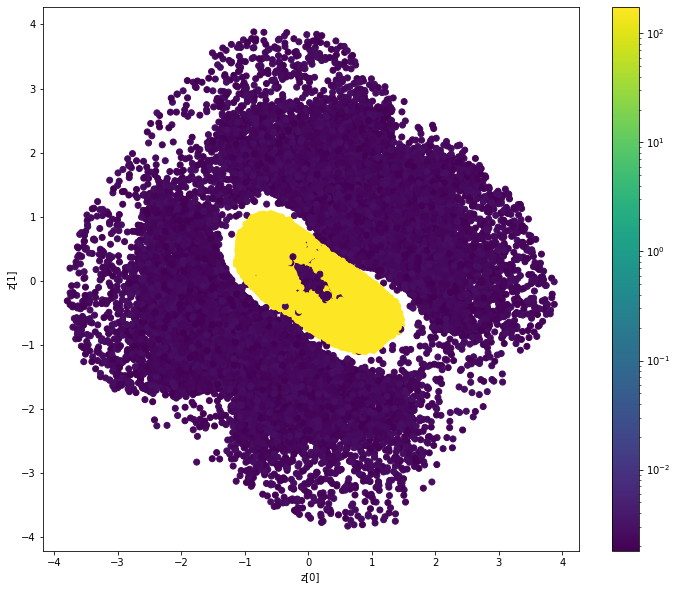

In [13]:
#Function that plots the latent space
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, norm=matplotlib.colors.LogNorm())
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

vae = load_model('vae_model')
plot_label_clusters(vae, X_train, y_train)

In [14]:
from tqdm.notebook import tqdm

outputs = np.zeros((100000,9))

#Sampling 100.000 times and generating data points
for i in tqdm(range(100000)):
    z_sample = np.array([[rng.normal(), rng.normal()]])
    x_decoded = vae.decoder.predict(z_sample)
    outputs[i,0] = i
    for j in range(8):
        true_val = (x_decoded[:,j] * (maxima[j] - minima[j])) + minima[j] #Undoing normalisation
        outputs[i,j+1] = true_val

#Creating .csv file with dataset
header = ['ID', 'E1', 'E2', 'p_x1', 'p_x2', 'p_y1', 'p_y2', 'p_z1', 'p_z2']

with open('bVAE_data.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    
    for i in range(100000):
        writer.writerow(outputs[i])

  0%|          | 0/100000 [00:00<?, ?it/s]

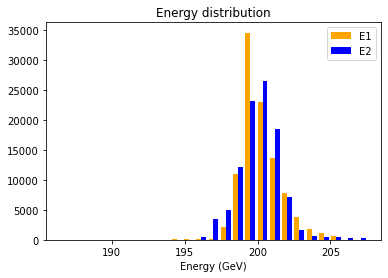

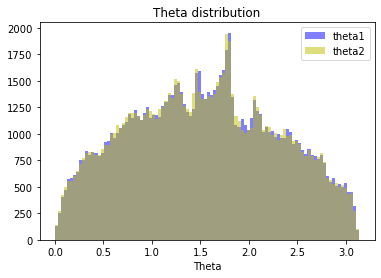

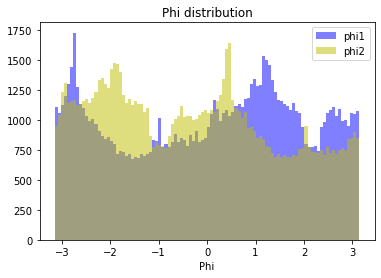

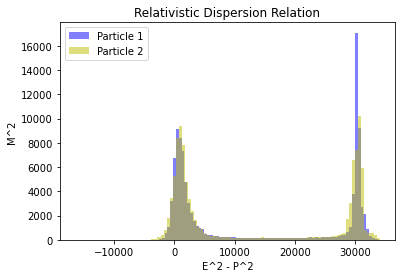

In [24]:
#Loading generated data file
gen_data = np.genfromtxt('bVAE_data.csv', delimiter=',') #Reading datafile
gen_data = np.delete(gen_data, 0, 0) #Removing header
gen_data = np.delete(gen_data, 0, 1) #Removing ID column
    


##Plotting histograms   
#Energy distribution
plt.hist([gen_data[:,0], gen_data[:,1]], label=['E1', 'E2'], bins=25, color=['orange','b'])
plt.title("Energy distribution")
plt.xlabel("Energy (GeV)")
plt.legend()
plt.show()


P1, theta1, phi1 = cart2sph(gen_data[:,2],gen_data[:,4],gen_data[:,6])
P2, theta2, phi2 = cart2sph(gen_data[:,3],gen_data[:,5],gen_data[:,7])

#Theta distribution
plt.hist(theta1, bins=100, label='theta1', alpha=0.5, color='b')
plt.hist(theta2, bins=100, label='theta2', alpha=0.5, color='y')
plt.title("Theta distribution")
plt.xlabel("Theta")
plt.legend()
plt.show()

#Phi distribution
plt.hist(phi1, bins=100, label='phi1', alpha=0.5, color='b')
plt.hist(phi2, bins=100, label='phi2', alpha=0.5, color='y')
plt.title("Phi distribution")
plt.xlabel("Phi")
plt.legend()
plt.show()

#Relativistic dispersion relation
px1_list = np.array(px1_list)
py1_list = np.array(py1_list)
pz1_list = np.array(pz1_list)
px2_list = np.array(px2_list)
py2_list = np.array(py2_list)
pz2_list = np.array(pz2_list)
E1_list = np.array(E1_list)
E2_list = np.array(E2_list)

P1_list = np.sqrt(gen_data[:,2]**2 + gen_data[:,4]**2 + gen_data[:,6]**2)
P2_list = np.sqrt(gen_data[:,3]**2 + gen_data[:,5]**2 + gen_data[:,7]**2)

plt.hist(gen_data[:,0]**2 - P1_list**2, bins=100, label='Particle 1', alpha=0.5, color='b')
plt.hist(gen_data[:,1]**2 - P2_list**2, bins=100, label='Particle 2', alpha=0.5, color='y')
plt.title("Relativistic Dispersion Relation")
plt.ylabel("M^2")
plt.xlabel("E^2 - P^2")
plt.legend()
plt.show()